## 可視化

In [1]:
import json
import pathlib
from pprint import pprint
import sys

import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="bright")
sns.set_style({"grid.color": "k"})

import japanize_matplotlib
from tqdm.auto import tqdm
import gspread


from judge_gpt import JudgeGPT, ColumnInfo
from judge_gpt.auth import auth_gcloud, set_openai_apikey_from_file
from judge_gpt.conf import read_conf
from judge_gpt.gss_reader import GSSReader


def plot_judge_stats(df_judge: pd.DataFrame, players: list[str]):
    agg_df = df_judge.groupby("judge", as_index=False).agg(
        player_count=("player_name", lambda x : len(set(x))),
        stats_difficulty_mean=("difficulty", "mean"),
        stats_variation_mean=("variation", "mean"),
        stats_refined_mean=("refined", "mean"),
        stats_performance_mean=("performance", "mean"),
        stats_difficulty_std=("difficulty", "std"),
        stats_variation_std=("variation", "std"),
        stats_refined_std=("refined", "std"),
        stats_performance_std=("performance", "std"),
    )
    
    assert (agg_df["player_count"] == len(players)).all(), "Judge result is missing"
    
    agg_df = agg_df.set_index("judge").T
    display(agg_df)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    agg_df.loc[[
        "stats_difficulty_mean",
        "stats_variation_mean",
        "stats_refined_mean",
        "stats_performance_mean",
    ], :].plot.bar(ax=ax1)
    
    agg_df.loc[[
        "stats_difficulty_std",
        "stats_variation_std",
        "stats_refined_std",
        "stats_performance_std",
    ], :].plot.bar(ax=ax2)
    ax1.grid()
    ax2.grid()

In [2]:
# 設定ファイル
conf_judge, conf_response_schema = read_conf(
    "./conf/pojc_20240212/judge.yaml",
    "./conf/pojc_20240212/response_schema.yaml",
)

# 認証
gss_reader = GSSReader(conf_judge["gss"])

## 結果シートの読み込み

In [3]:
result_all = gss_reader.get_ws_as_df("1YsBr5sCKTIl6WBTCk0codQWmmNjk_O_RwufV0pZXpTM")
result_diabolo = result_all.iloc[2:10, :-2].reset_index(drop=True)
result_diabolo.columns = result_all.iloc[1, :-2].values
result_toss = result_all.iloc[15:21, :-2].reset_index(drop=True)
result_toss.columns = result_all.iloc[14, :-2].values
display(result_diabolo)
display(result_toss)

演技順      選手名    難易度   多彩性度  操作安定度   演技構成     合計 順位
0   1     トムコム     23   11.5     17     19   70.5  5
1   3  YAMASHO   17.5    8.5  10.25   16.5  52.75  8
2   5   スドウケイタ   28.5     11  19.25  18.25     77  4
3   7     あんそに     23   12.5  17.75  16.75     70  6
4   8     市川優真  25.25     15  20.75     22     83  2
5  10     しんたく   18.5   10.5  17.25  21.25   67.5  7
6  12      ひかる  21.75  13.75  21.25     22  78.75  3
7  14    ツダマナト  30.25  14.75     20   20.5   85.5  1

演技順       選手名    難易度   多彩性度  操作安定度   演技構成     合計 順位
0   2  だけもとてつろう  11.75    6.5    7.5   11.5  37.25  6
1   4      安江将貴   18.5  12.75  13.75   15.5   60.5  3
2   6         ち      7      5  15.25  16.75     44  5
3   9       齋藤玲     22  14.25     16     18  70.25  1
4  11        どい  21.25     14   12.5     12  59.75  4
5  13        ほり  21.25  13.25     16  14.75  65.25  2

## 可視化

In [43]:
columns = ["難易度", "多彩性度", "操作安定度", "演技構成"]
max_points = {
    "難易度": 35, 
    "多彩性度": 15,
    "操作安定度": 25,
    "演技構成": 25,
}

def save_pie_chart(df: pd.DataFrame):
    player_names = df["選手名"].values
    for player_name in player_names:
        fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
        axs = axs.flatten()
        
        for idx, (ax, col) in enumerate(zip(axs, columns)):
                
            point=df.query(f"選手名 == '{player_name}'")[col].astype(float).values[0]
            
            ax.pie(
                [point, max_points[col] - point],
                labels=[f"{100* point / max_points[col]:.1f}%", None],
                colors=(sns.color_palette()[idx], (200/256, 200/256, 200/256)),
                radius=1,
                wedgeprops=dict(width=0.7, edgecolor="k"),
                pctdistance=0.65, 
                startangle=90,
                counterclock=False,
                textprops={"size": 15},
            )
        
            ax.set_title(col, fontsize=15)

        fig.gca().spines["right"].set_visible(False)
        fig.gca().spines["top"].set_visible(False)
        fig.gca().spines["bottom"].set_visible(False)
        fig.gca().spines["left"].set_visible(False)
        fig.tight_layout()
        
        fig.savefig(f"./output/{player_name}_pie_chart.png", transparent=True, dpi=300)


def save_hist_chart(df: pd.DataFrame):
    player_names = df["選手名"].values
    for player_name in player_names:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=350)
    
        bar_plot_data = df.query(f"選手名 == '{player_name}'")[columns].astype(float)
        sns.barplot(
            data=bar_plot_data,
            edgecolor="k",
            ax=ax,
        )
        for cont in ax.containers:
            ax.bar_label(cont, fontsize=15, label_type="edge", padding=5)
        
        ax.grid("brack", axis="y", linestyle=":")
        ax.set_ylim(-0.1, 37.5)
        
        fig.tight_layout()
        fig.gca().spines["right"].set_visible(False)
        fig.gca().spines["top"].set_visible(False)
        fig.gca().spines["bottom"].set_visible(False)
        fig.gca().spines["left"].set_visible(False)
        fig.tight_layout()
        
        fig.savefig(f"./output/{player_name}_hist.png", transparent=True, dpi=350)

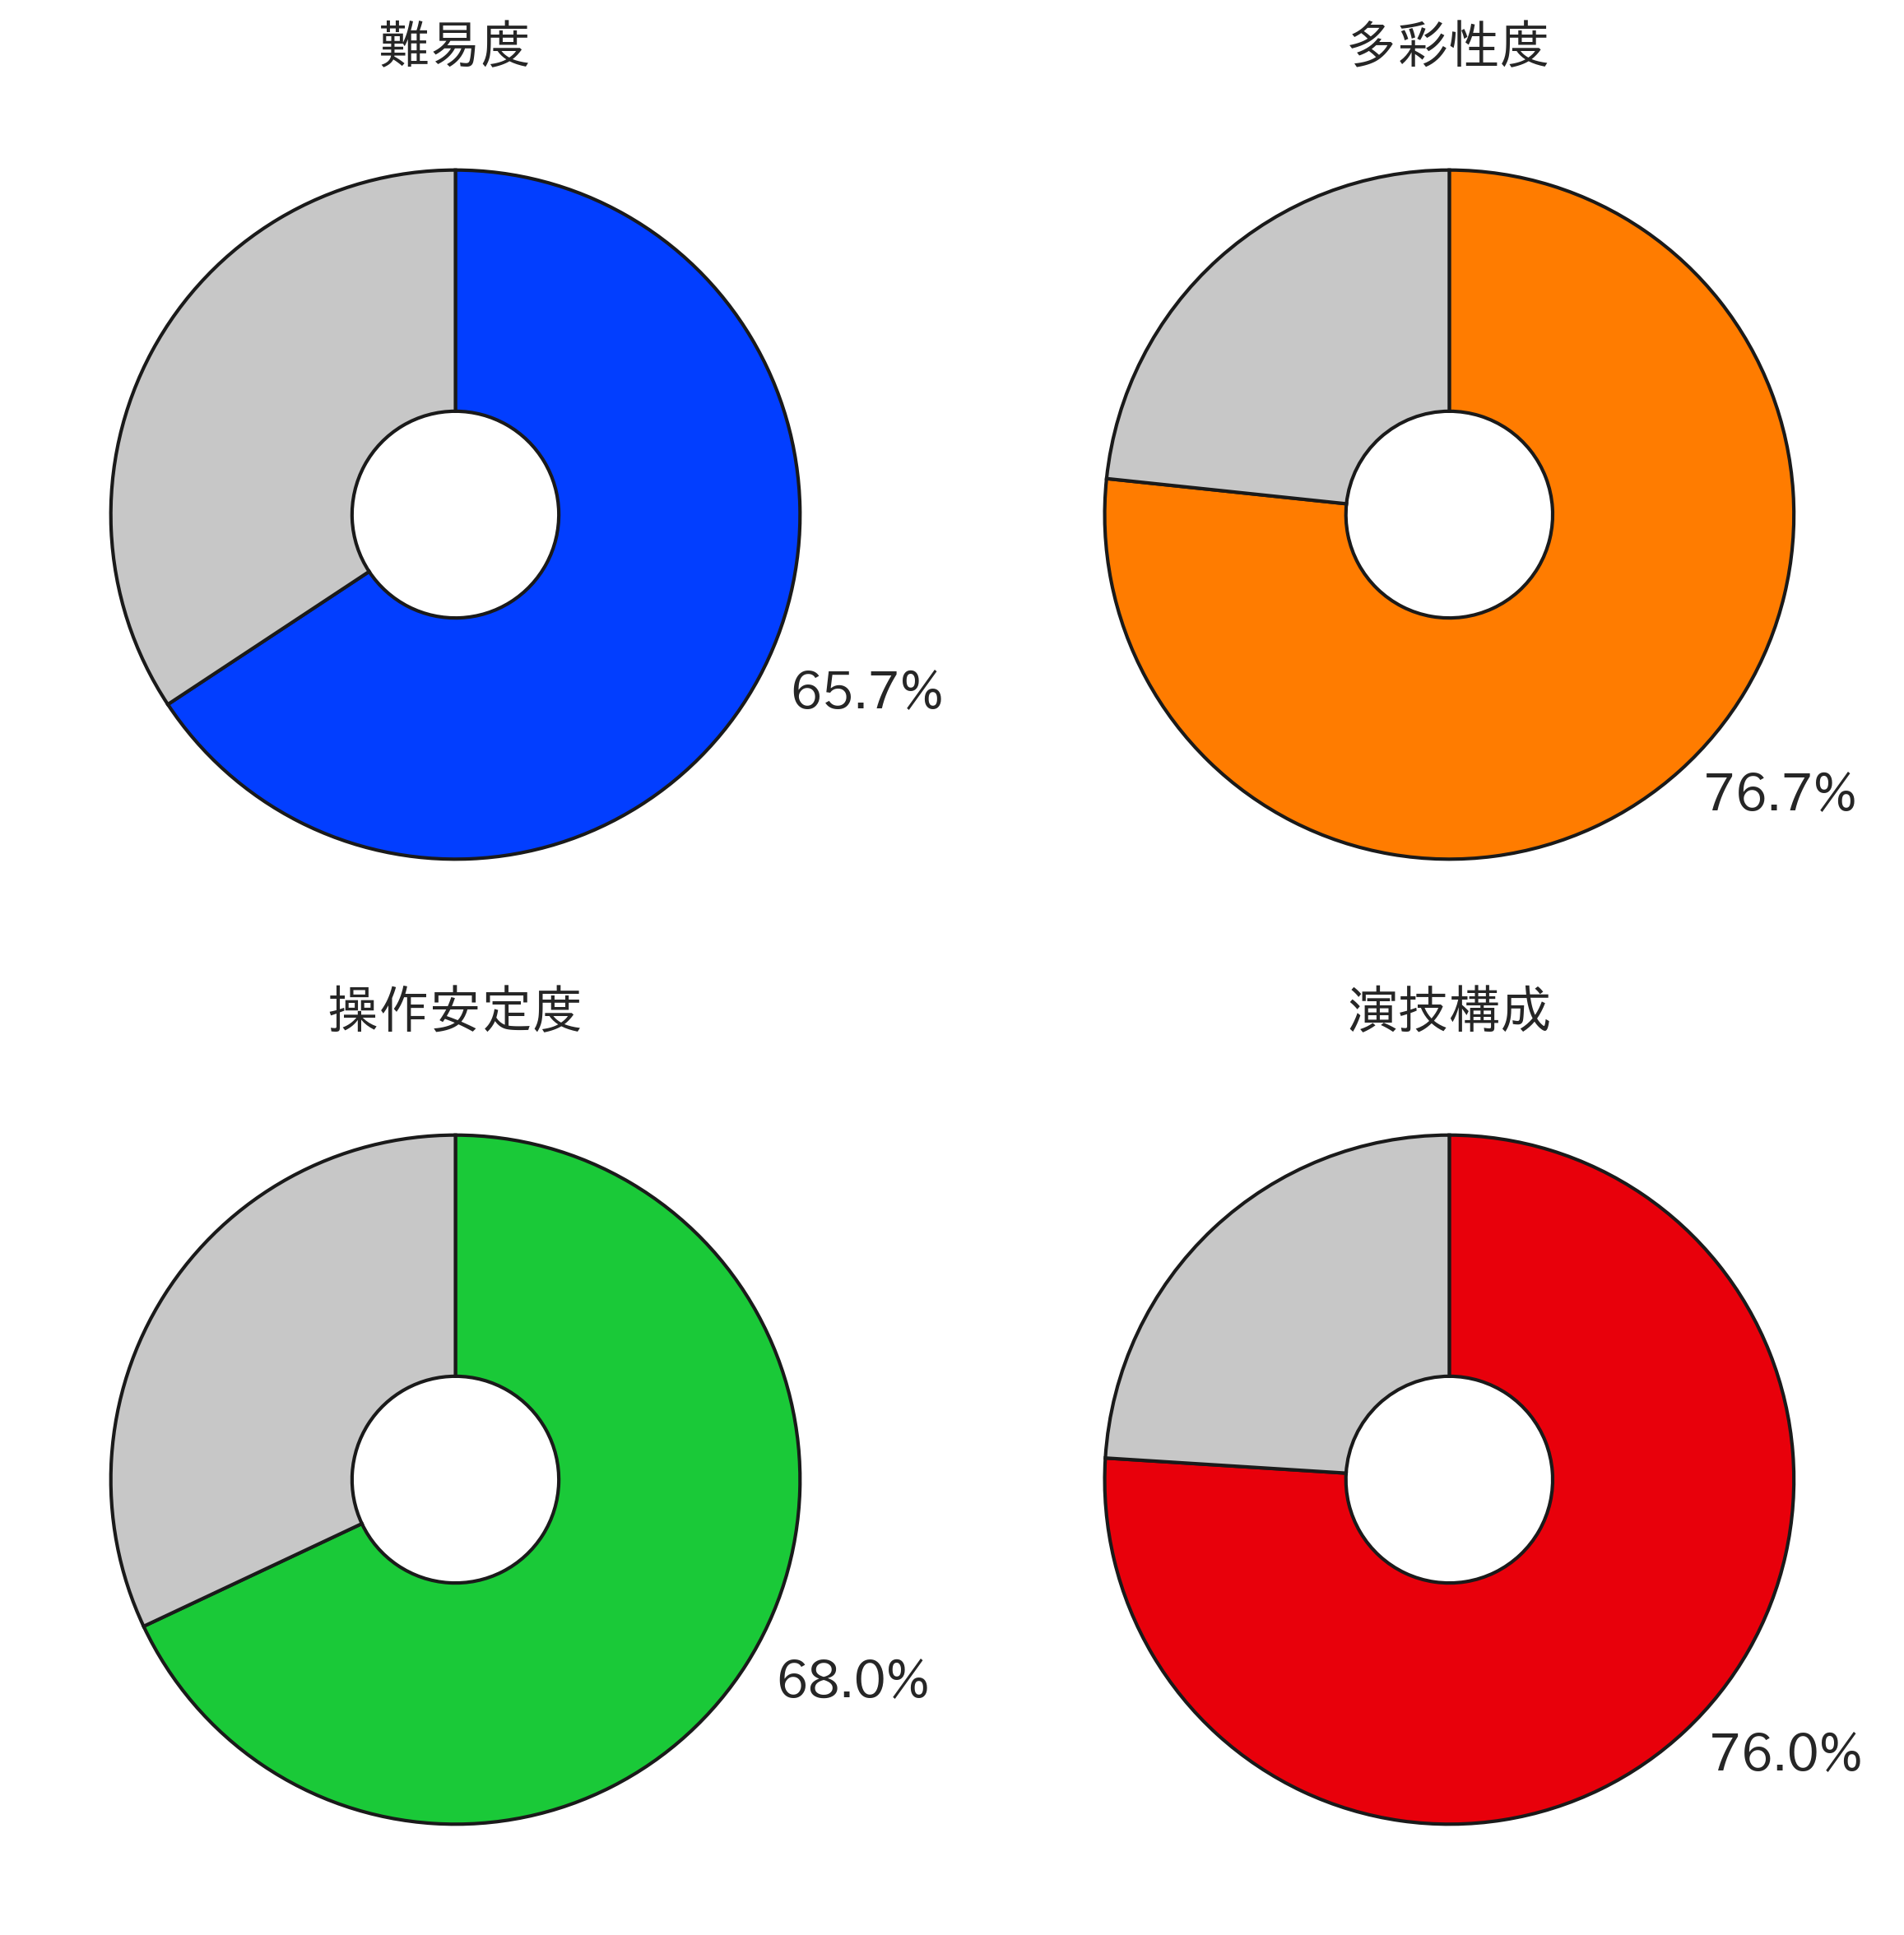

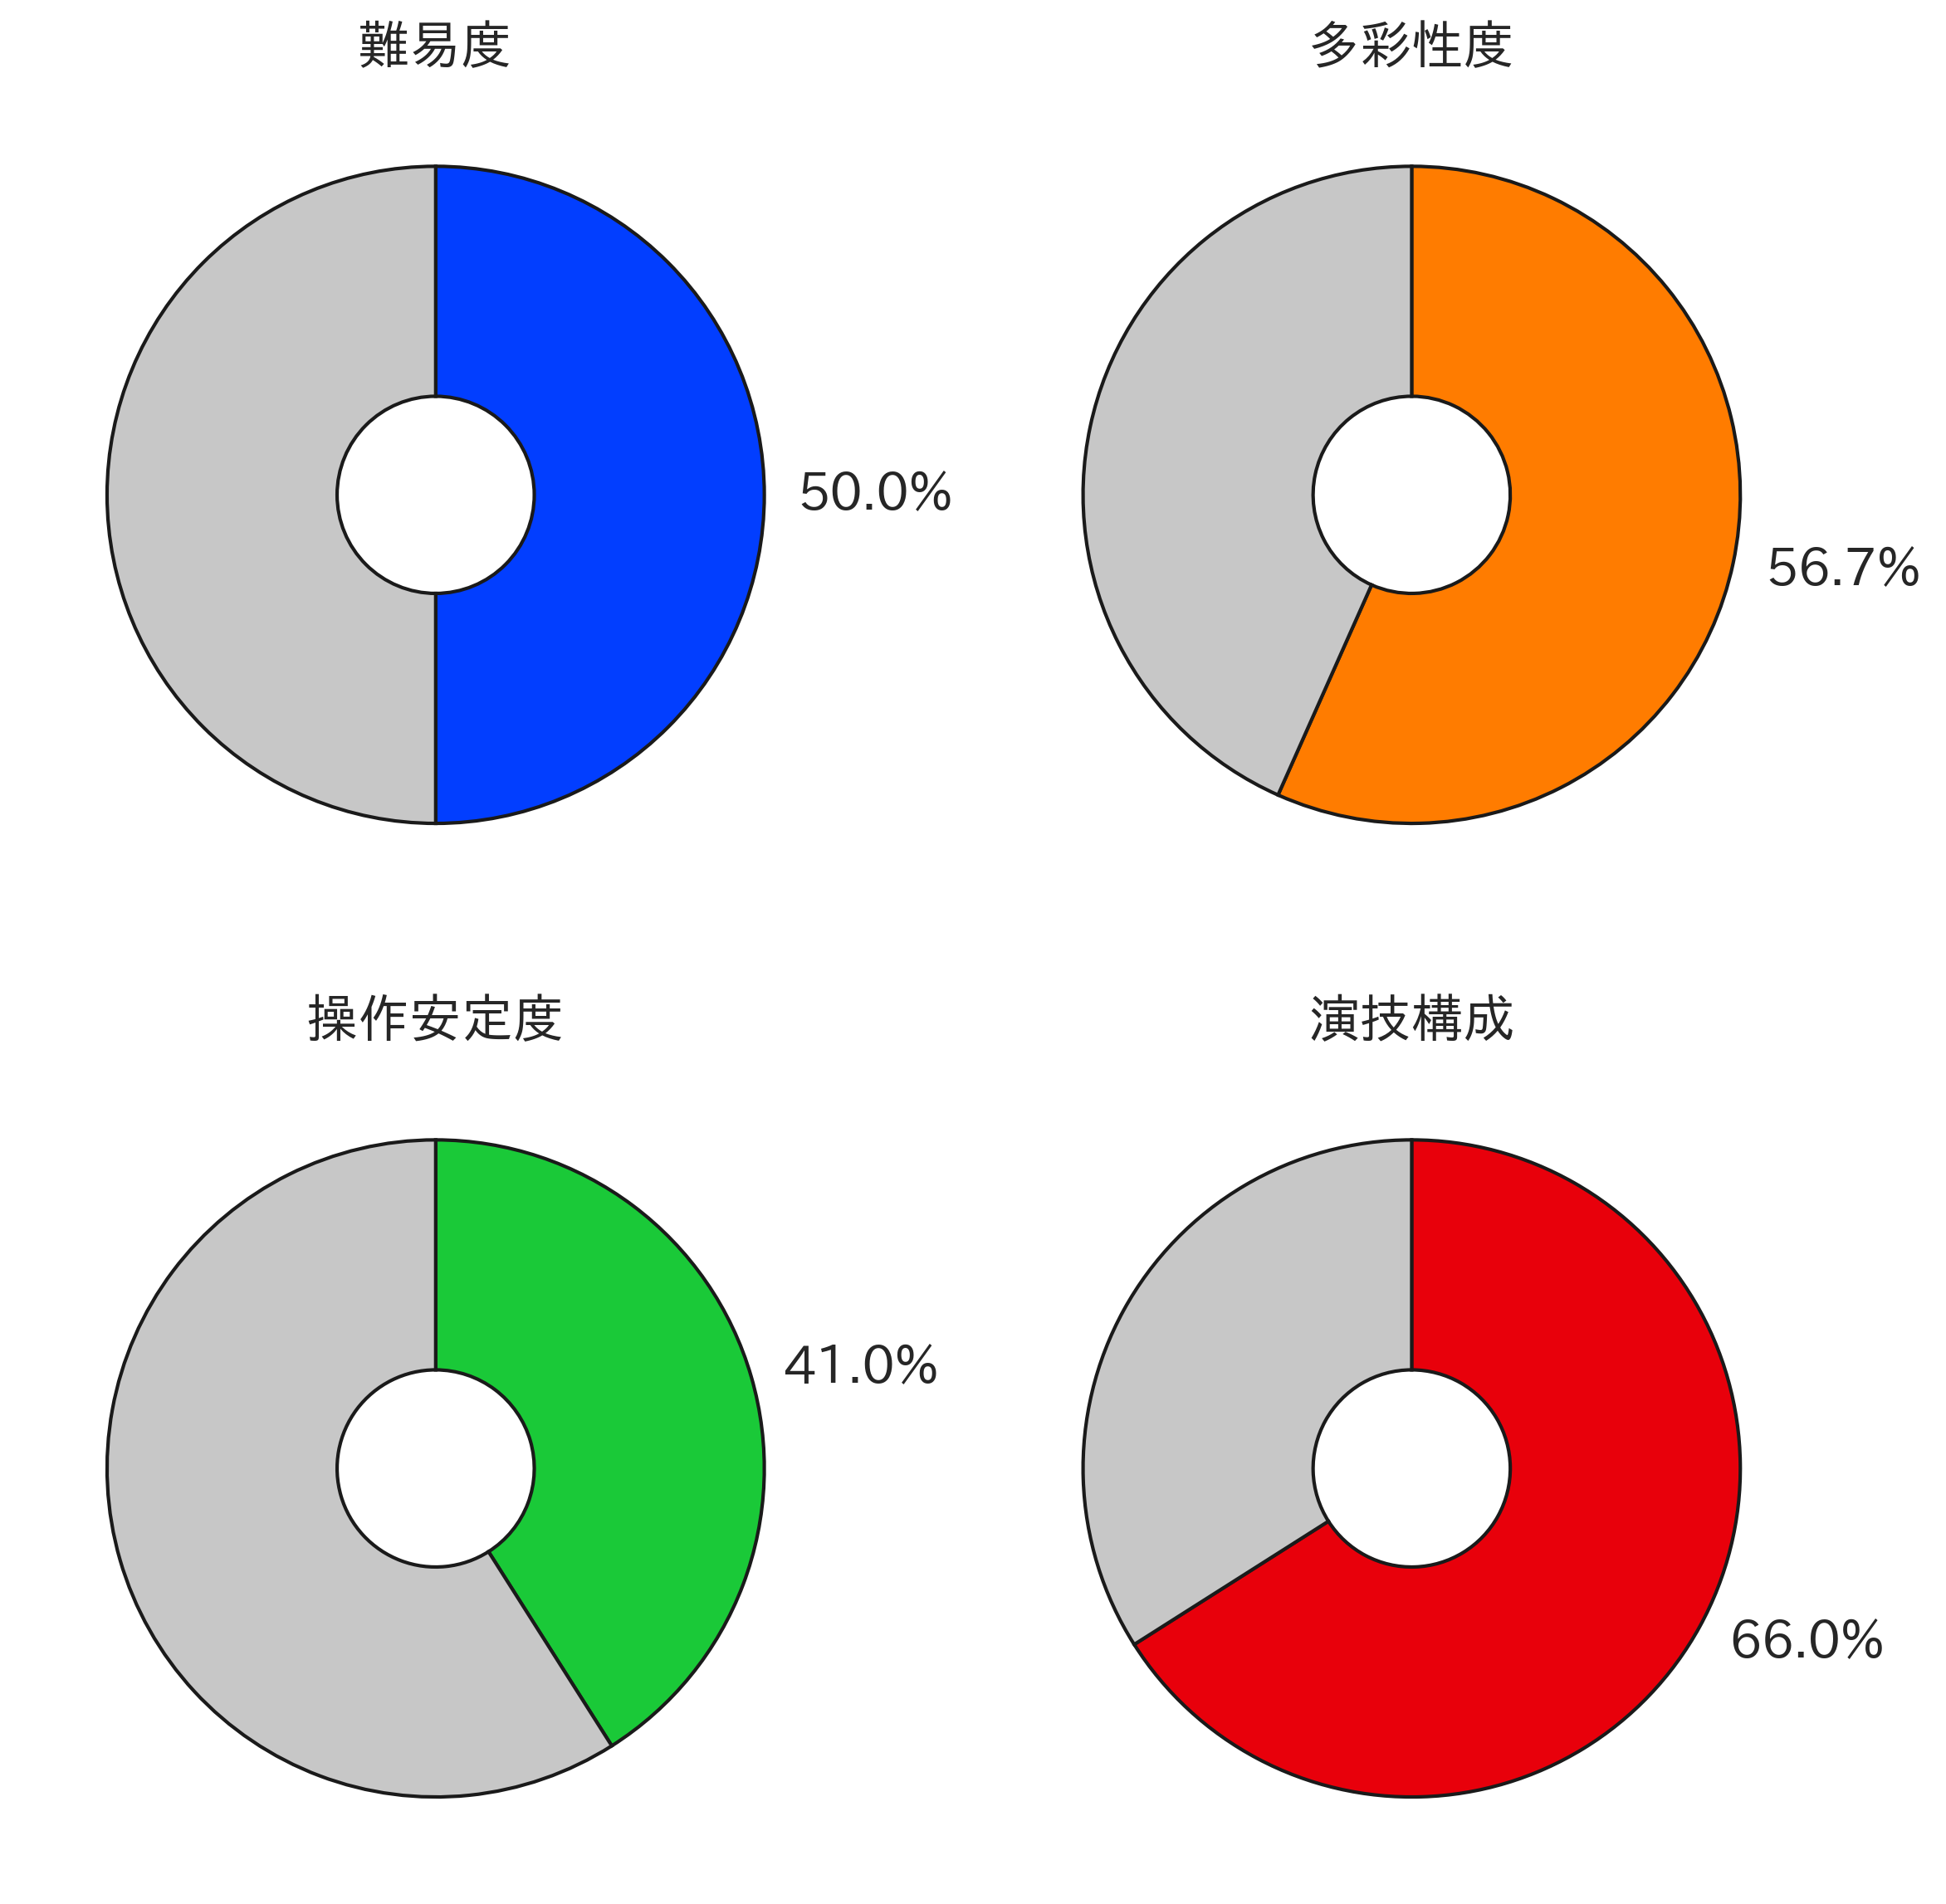

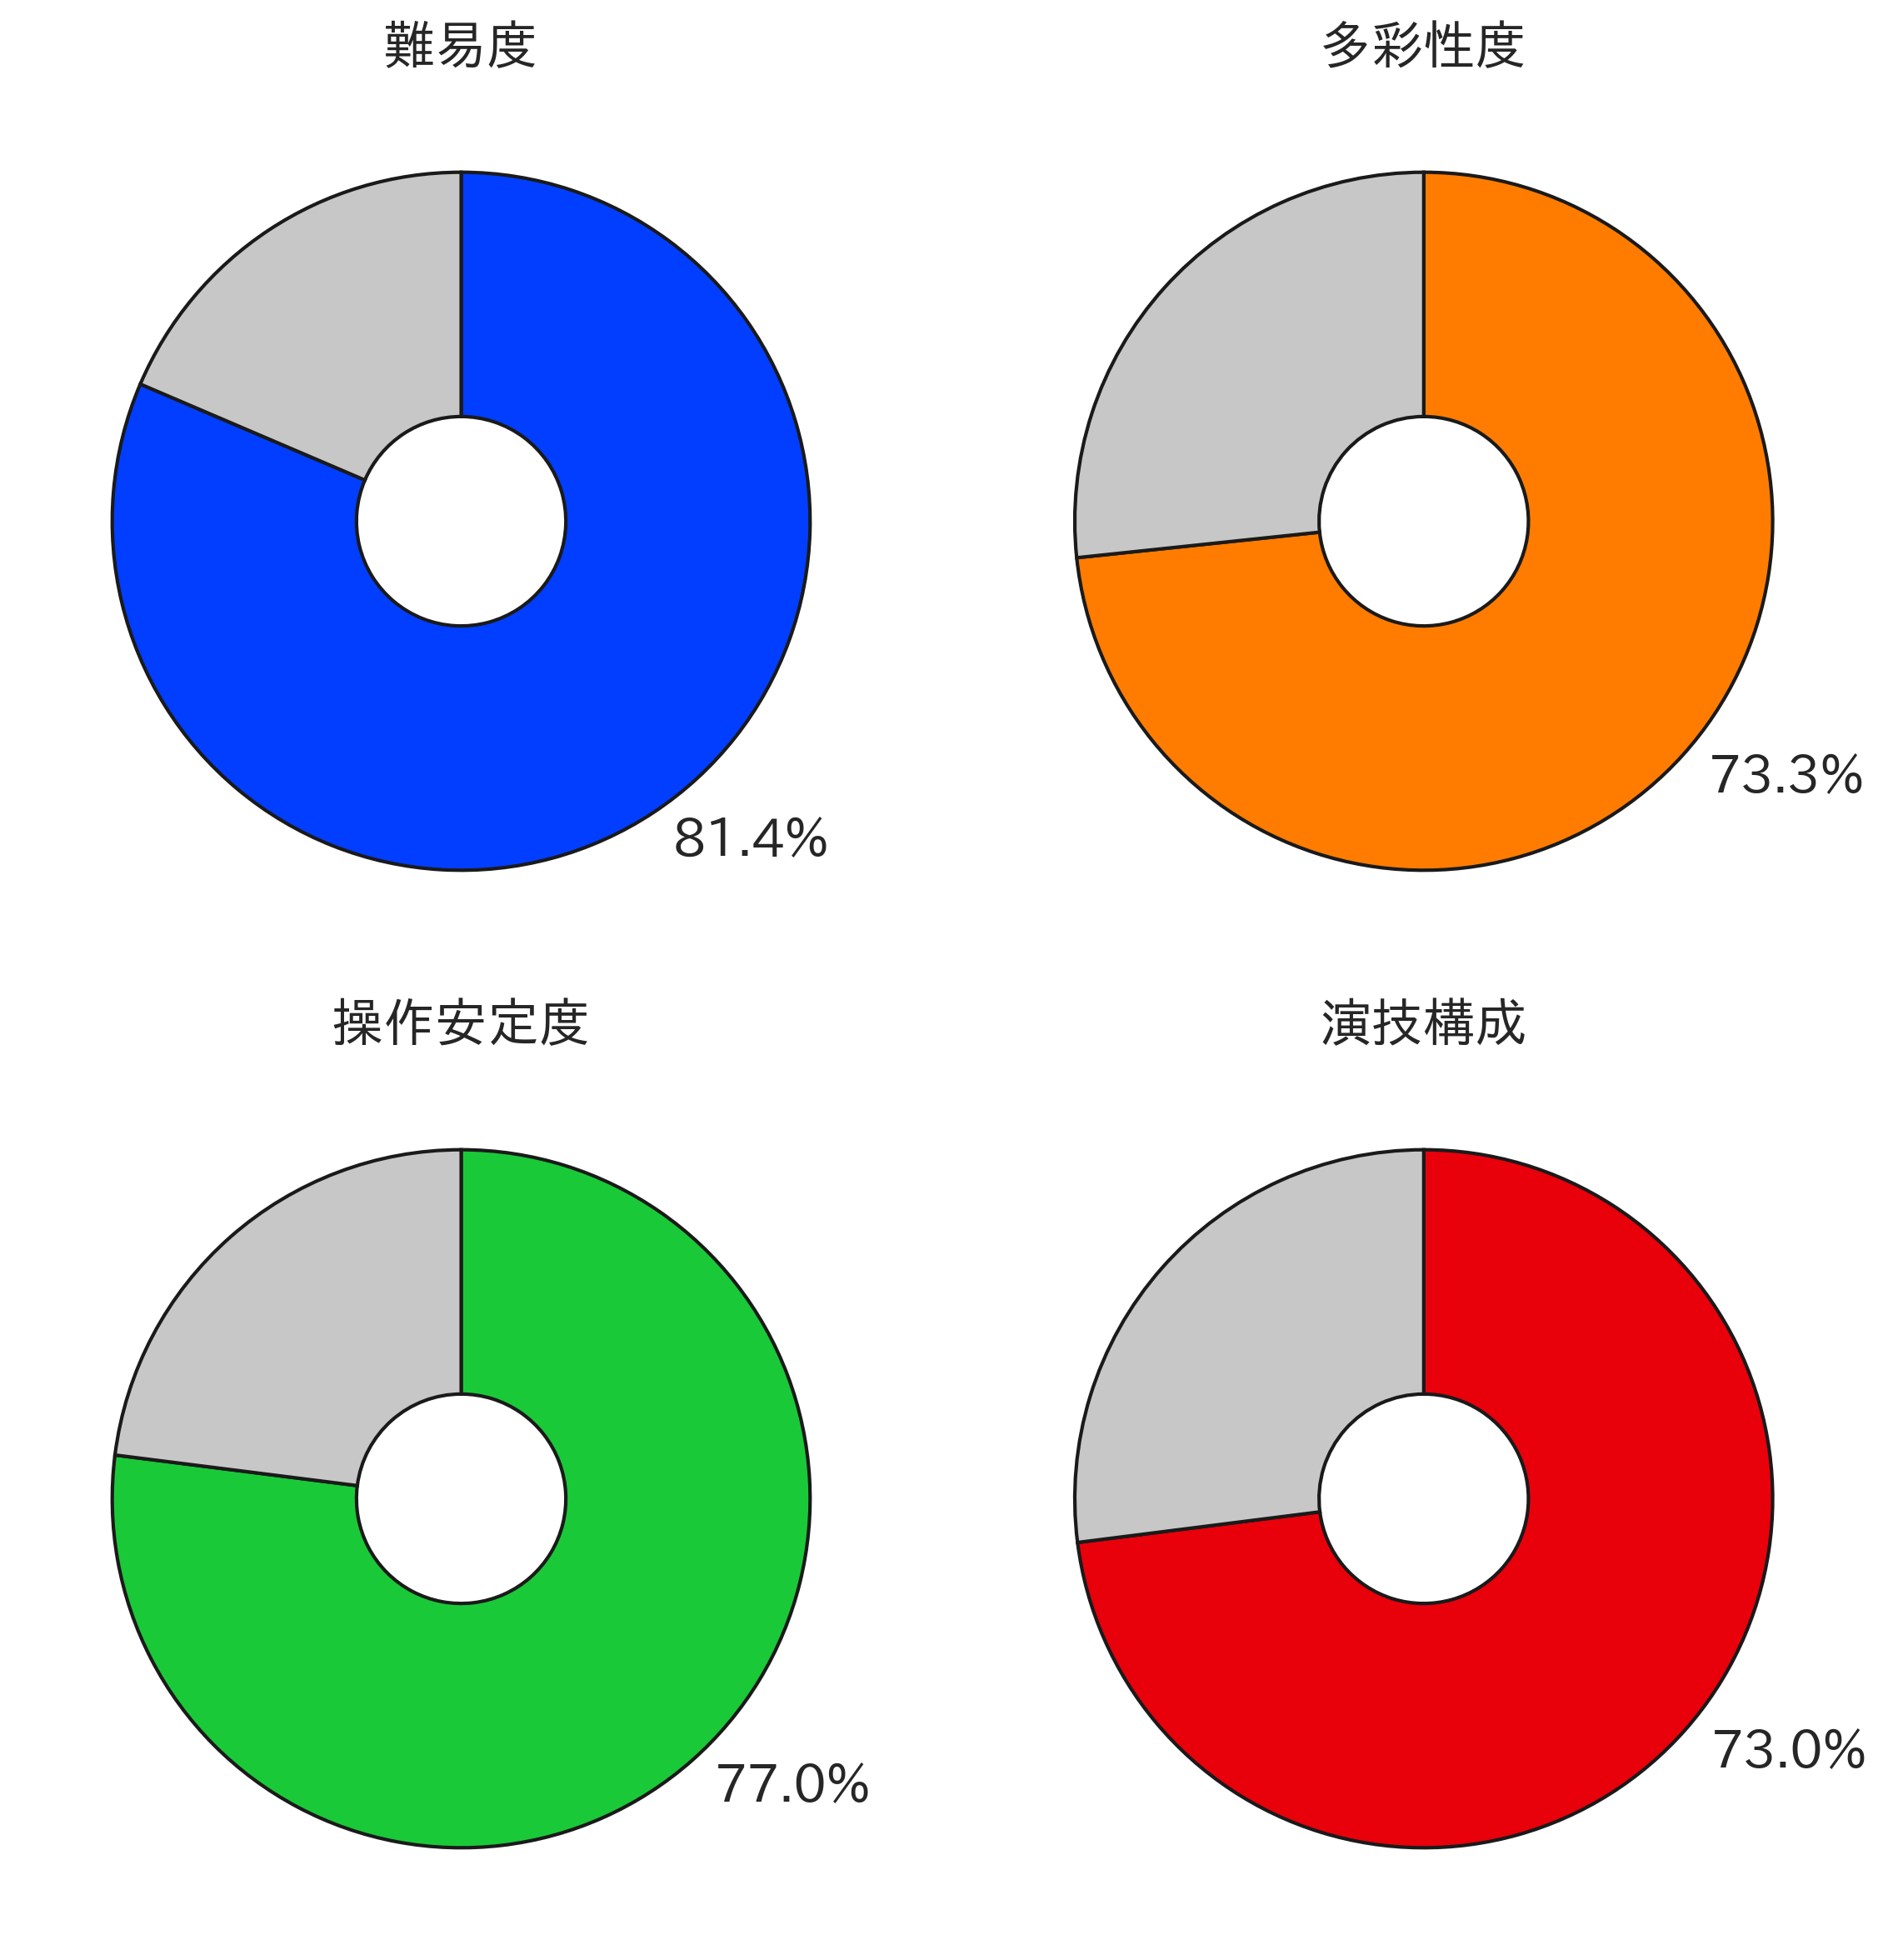

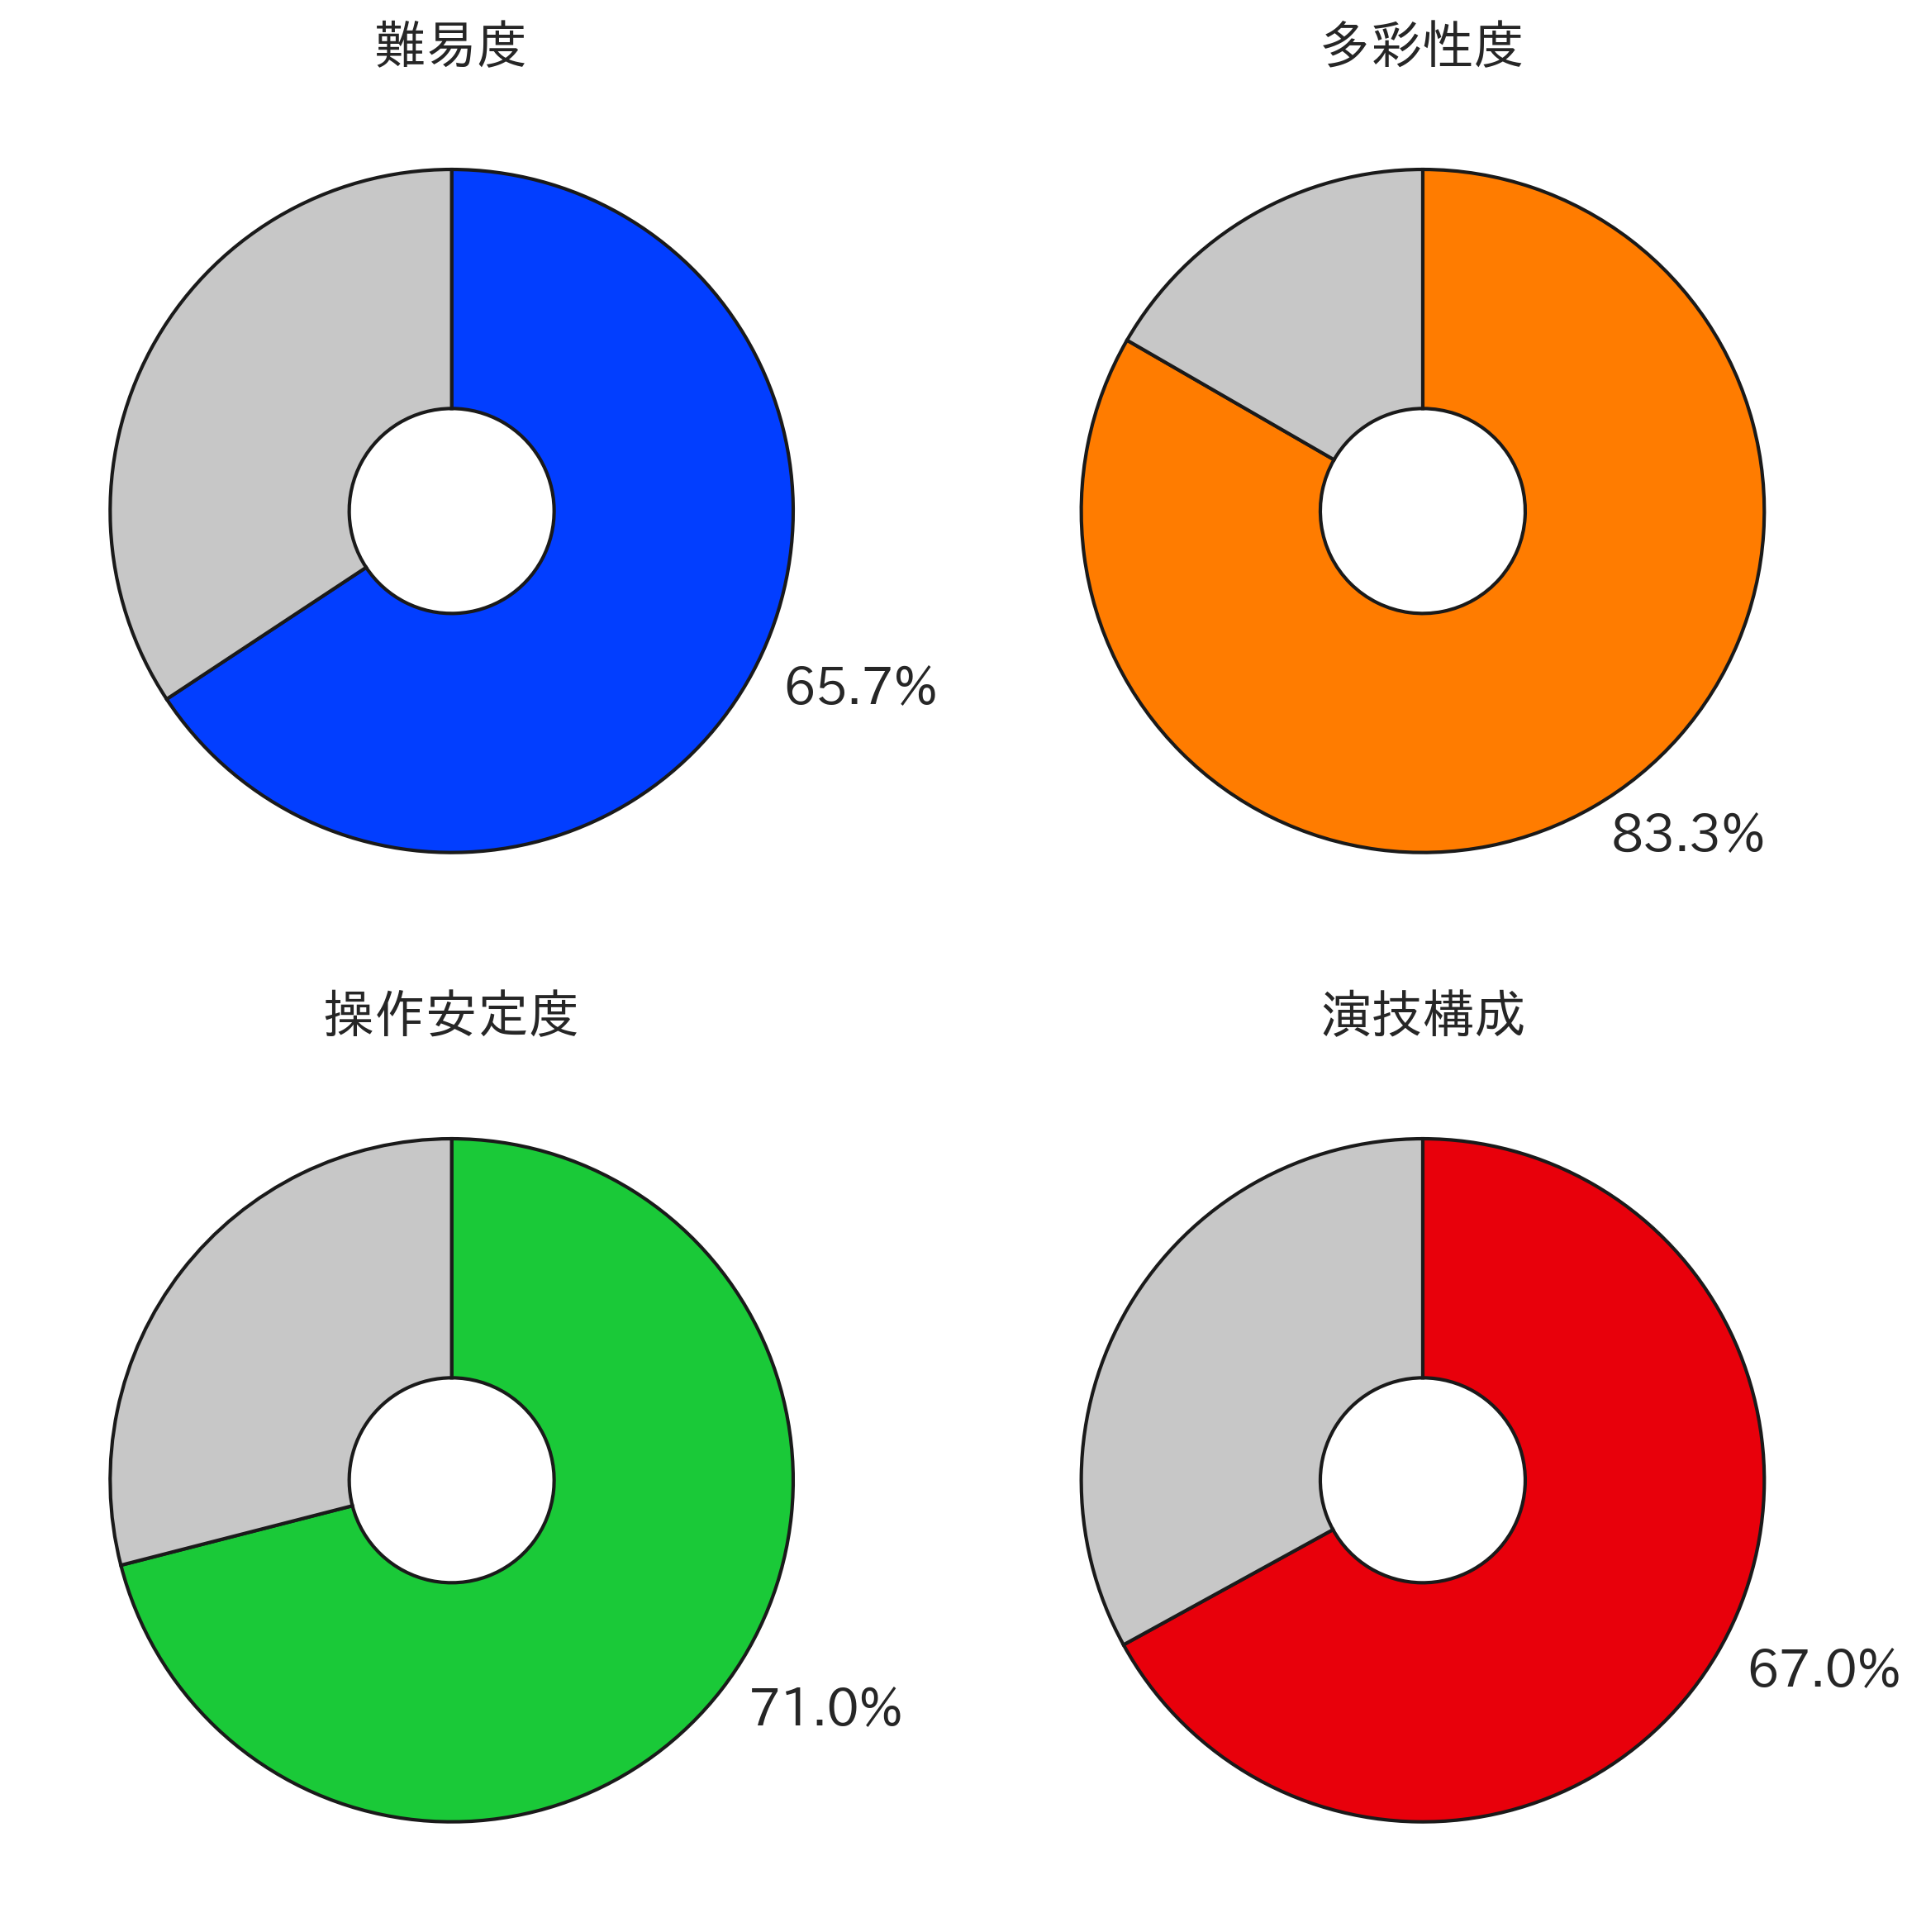

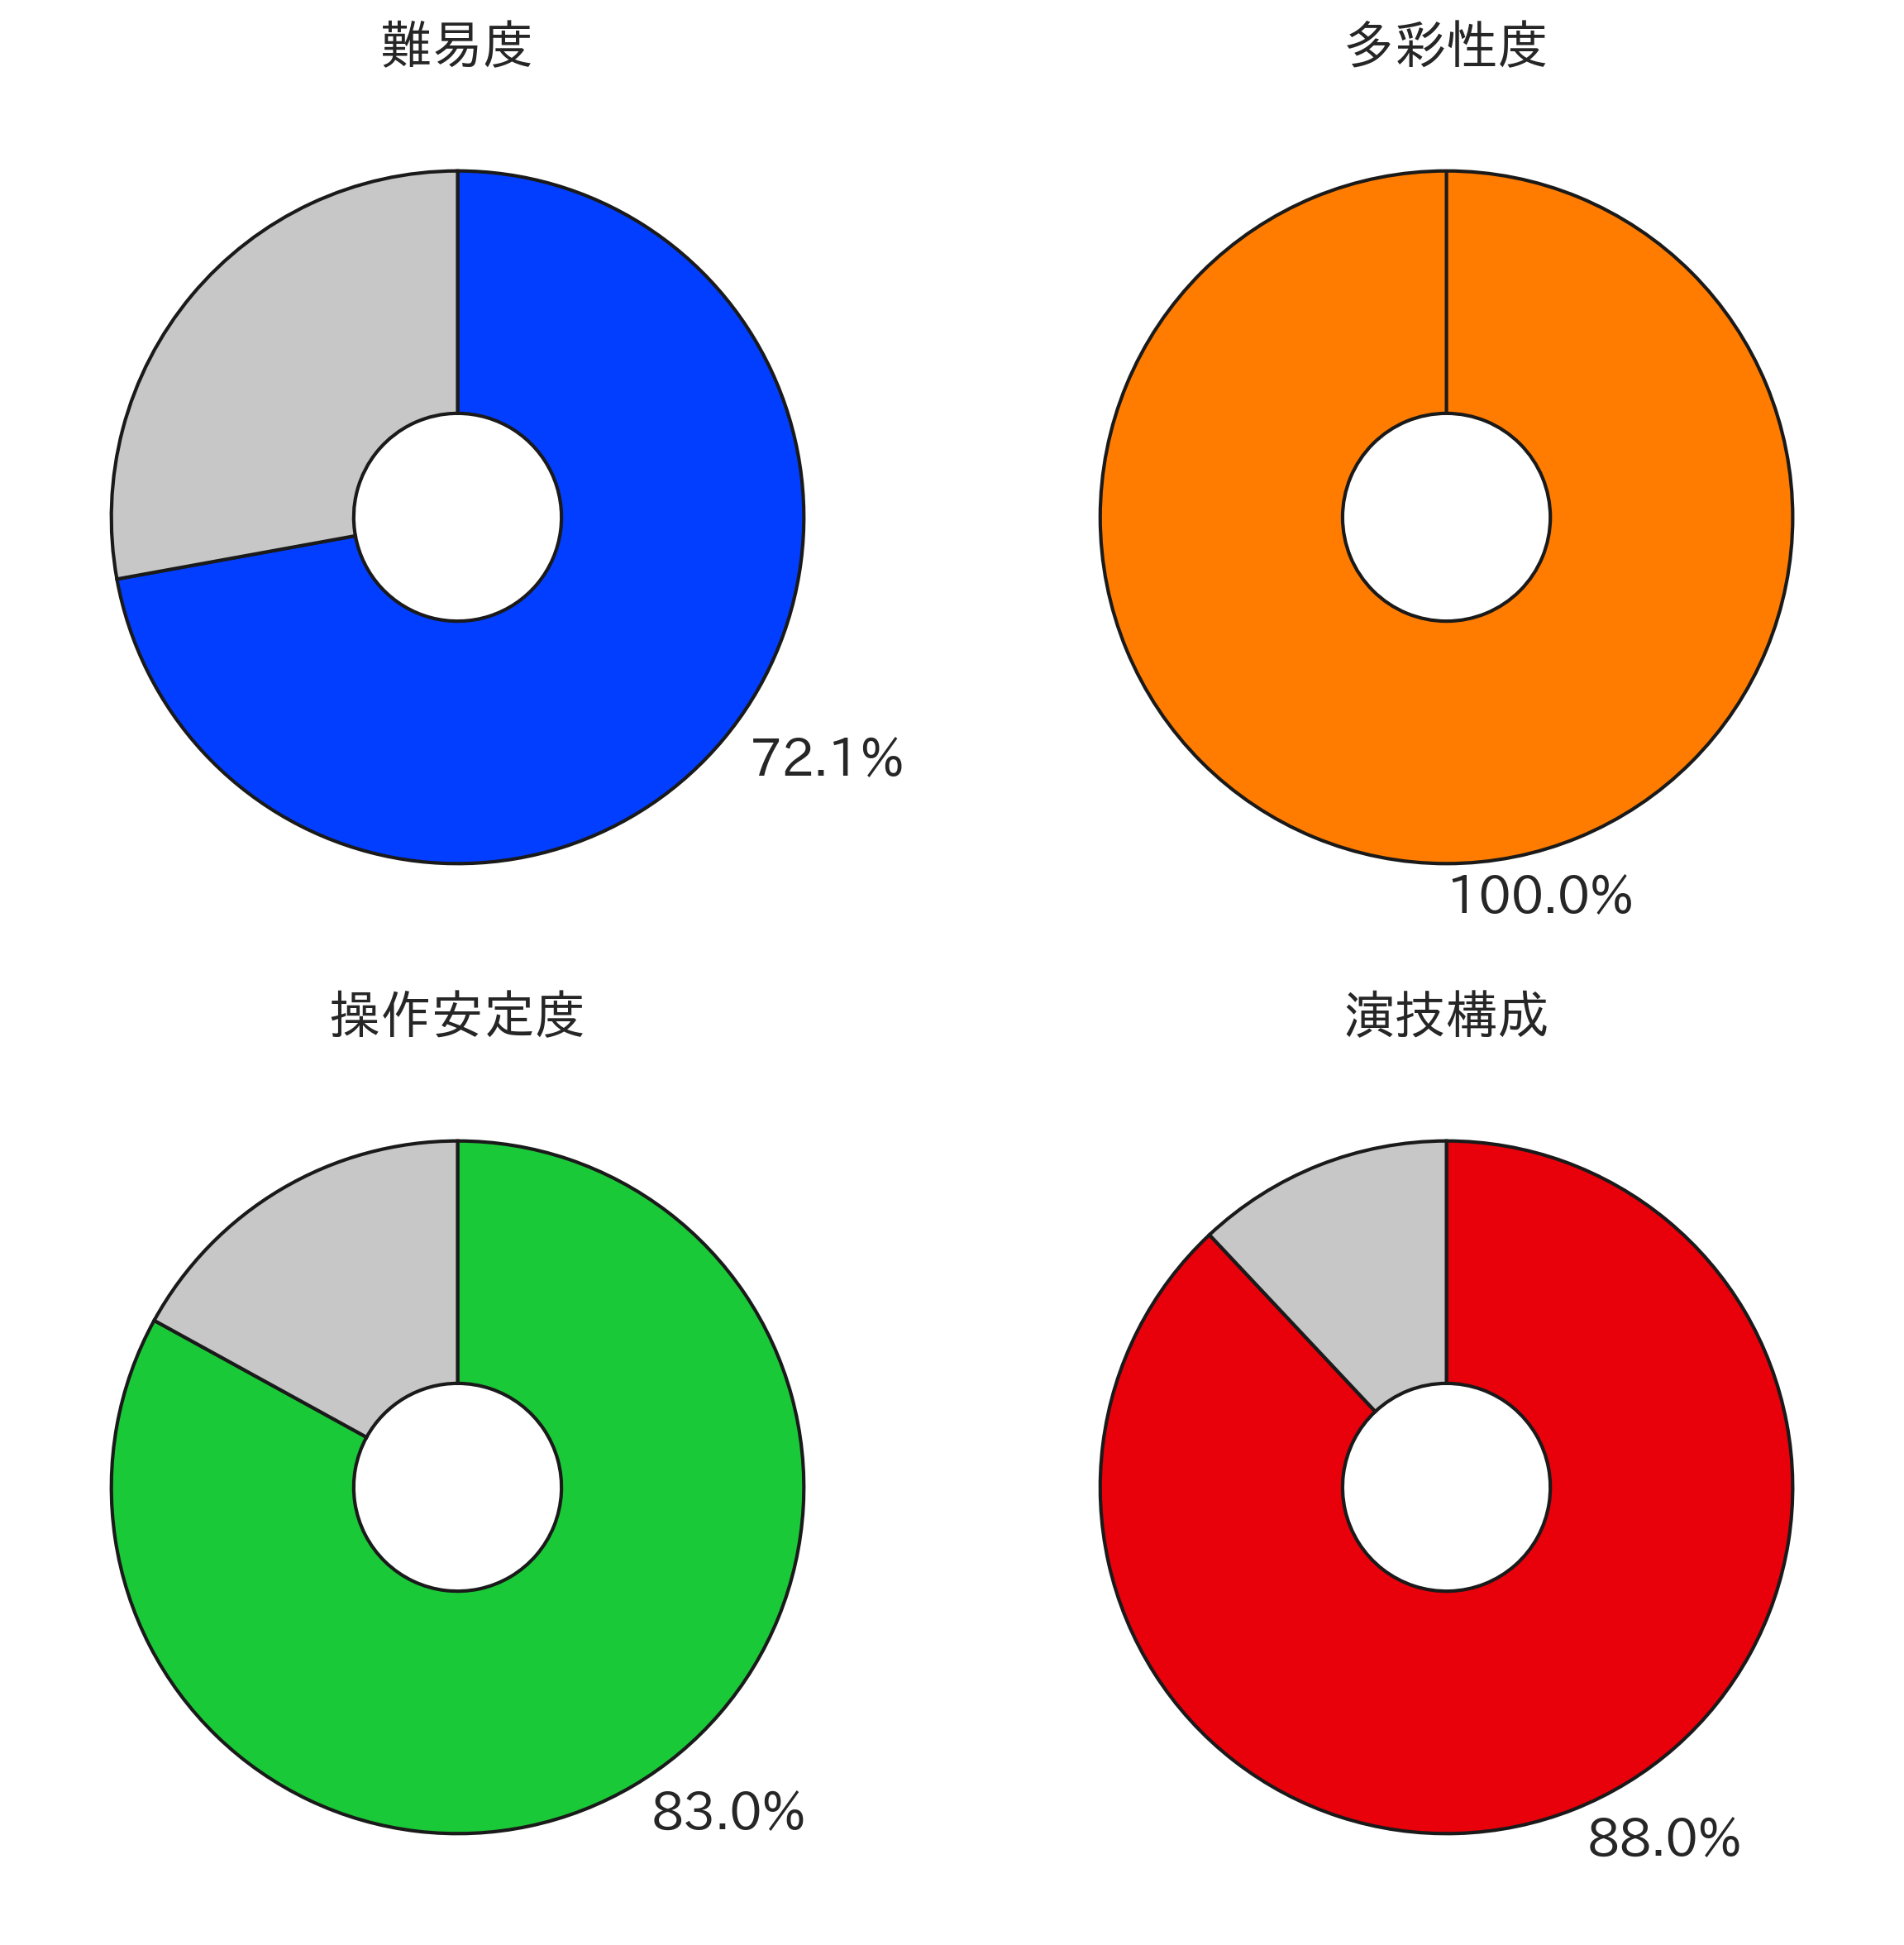

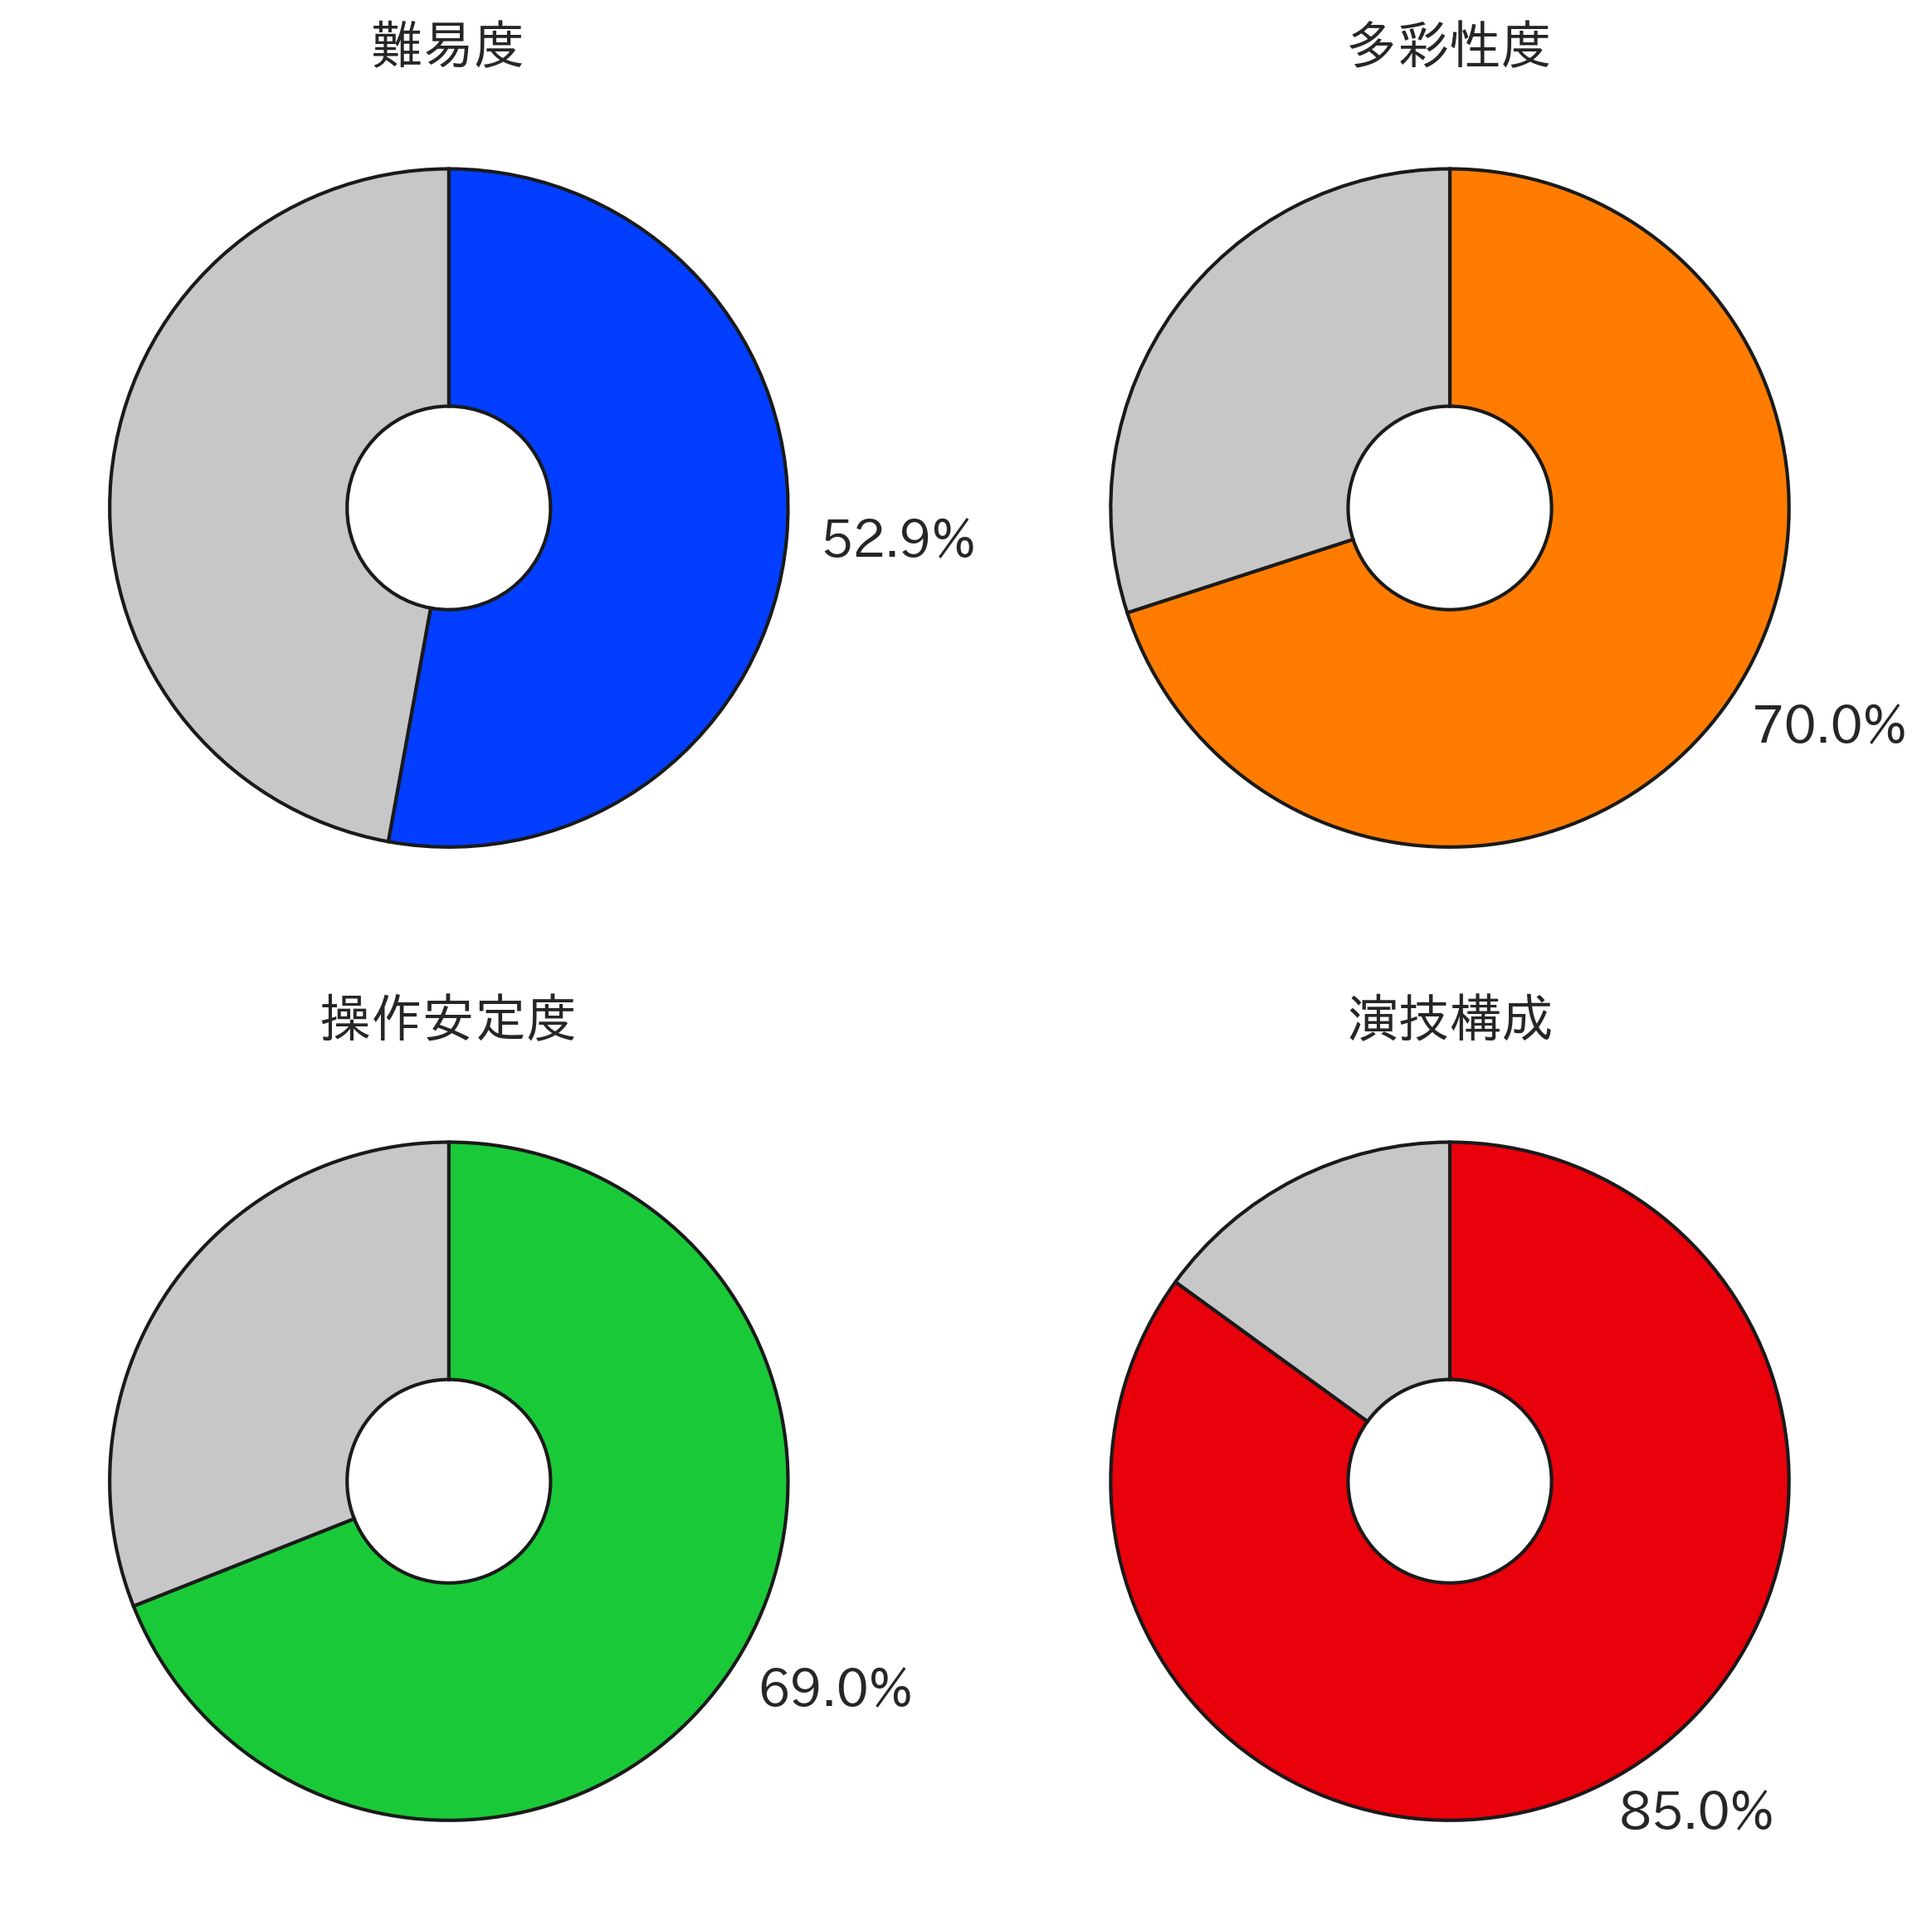

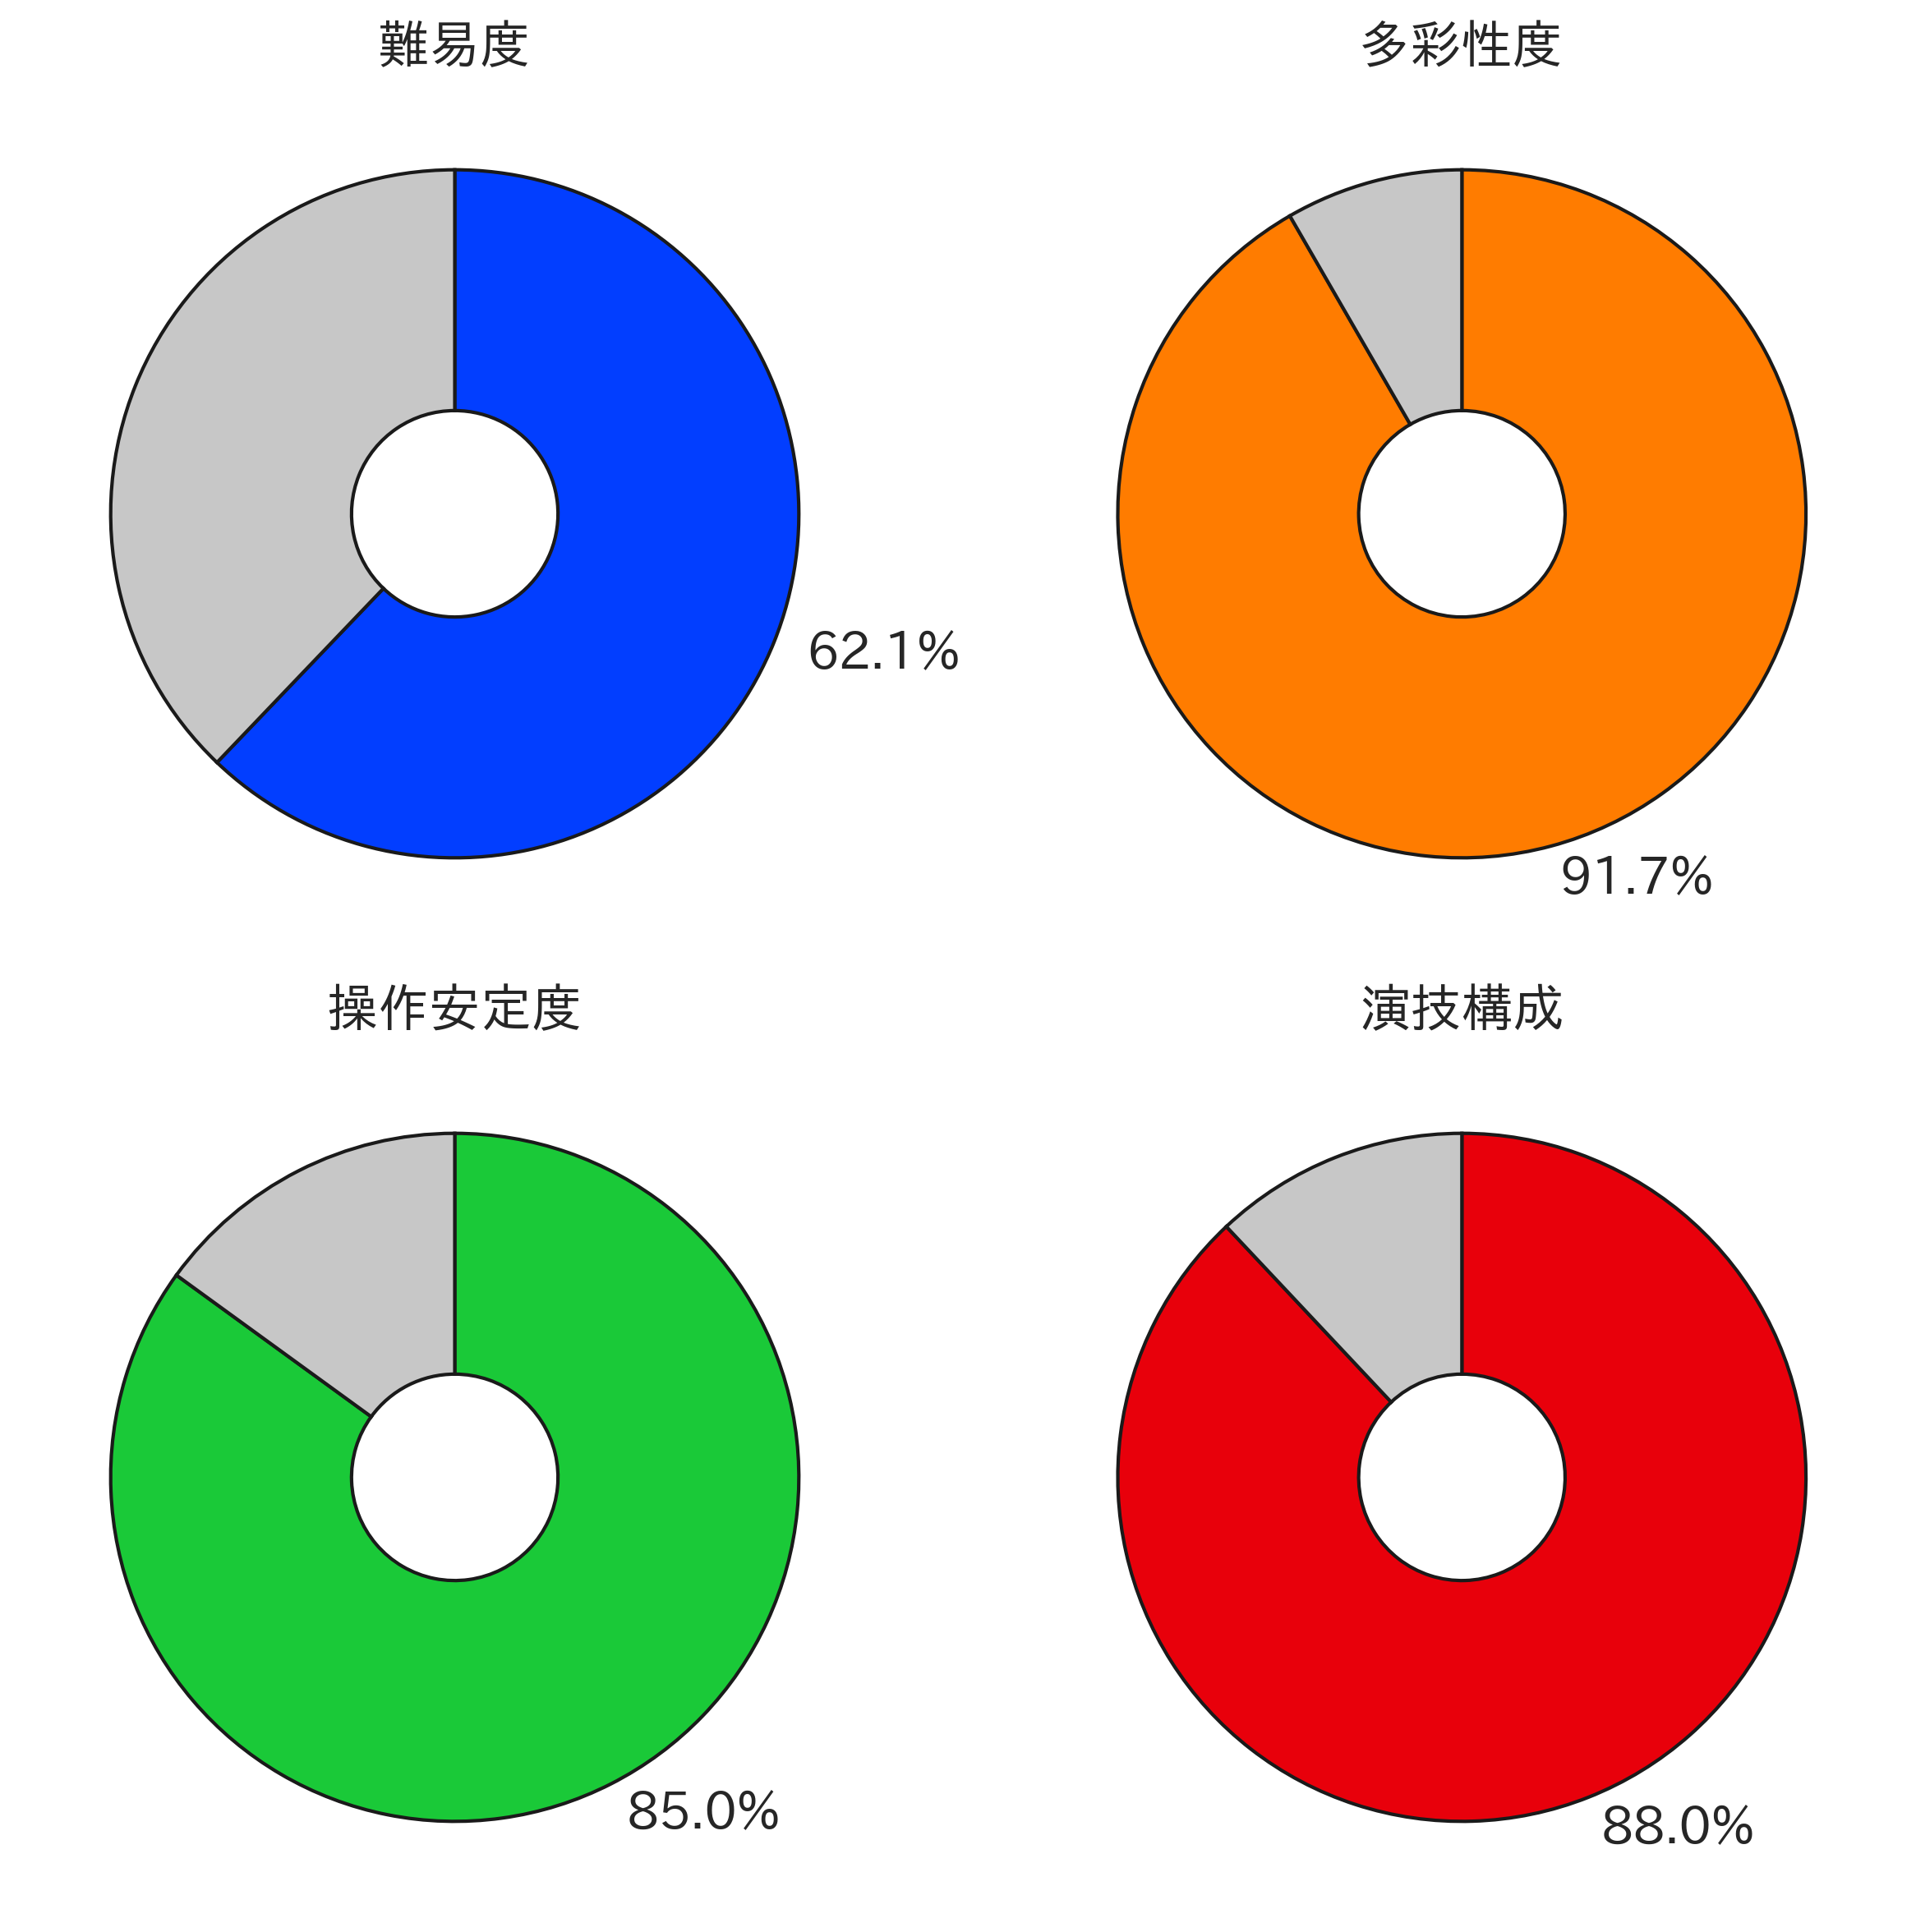

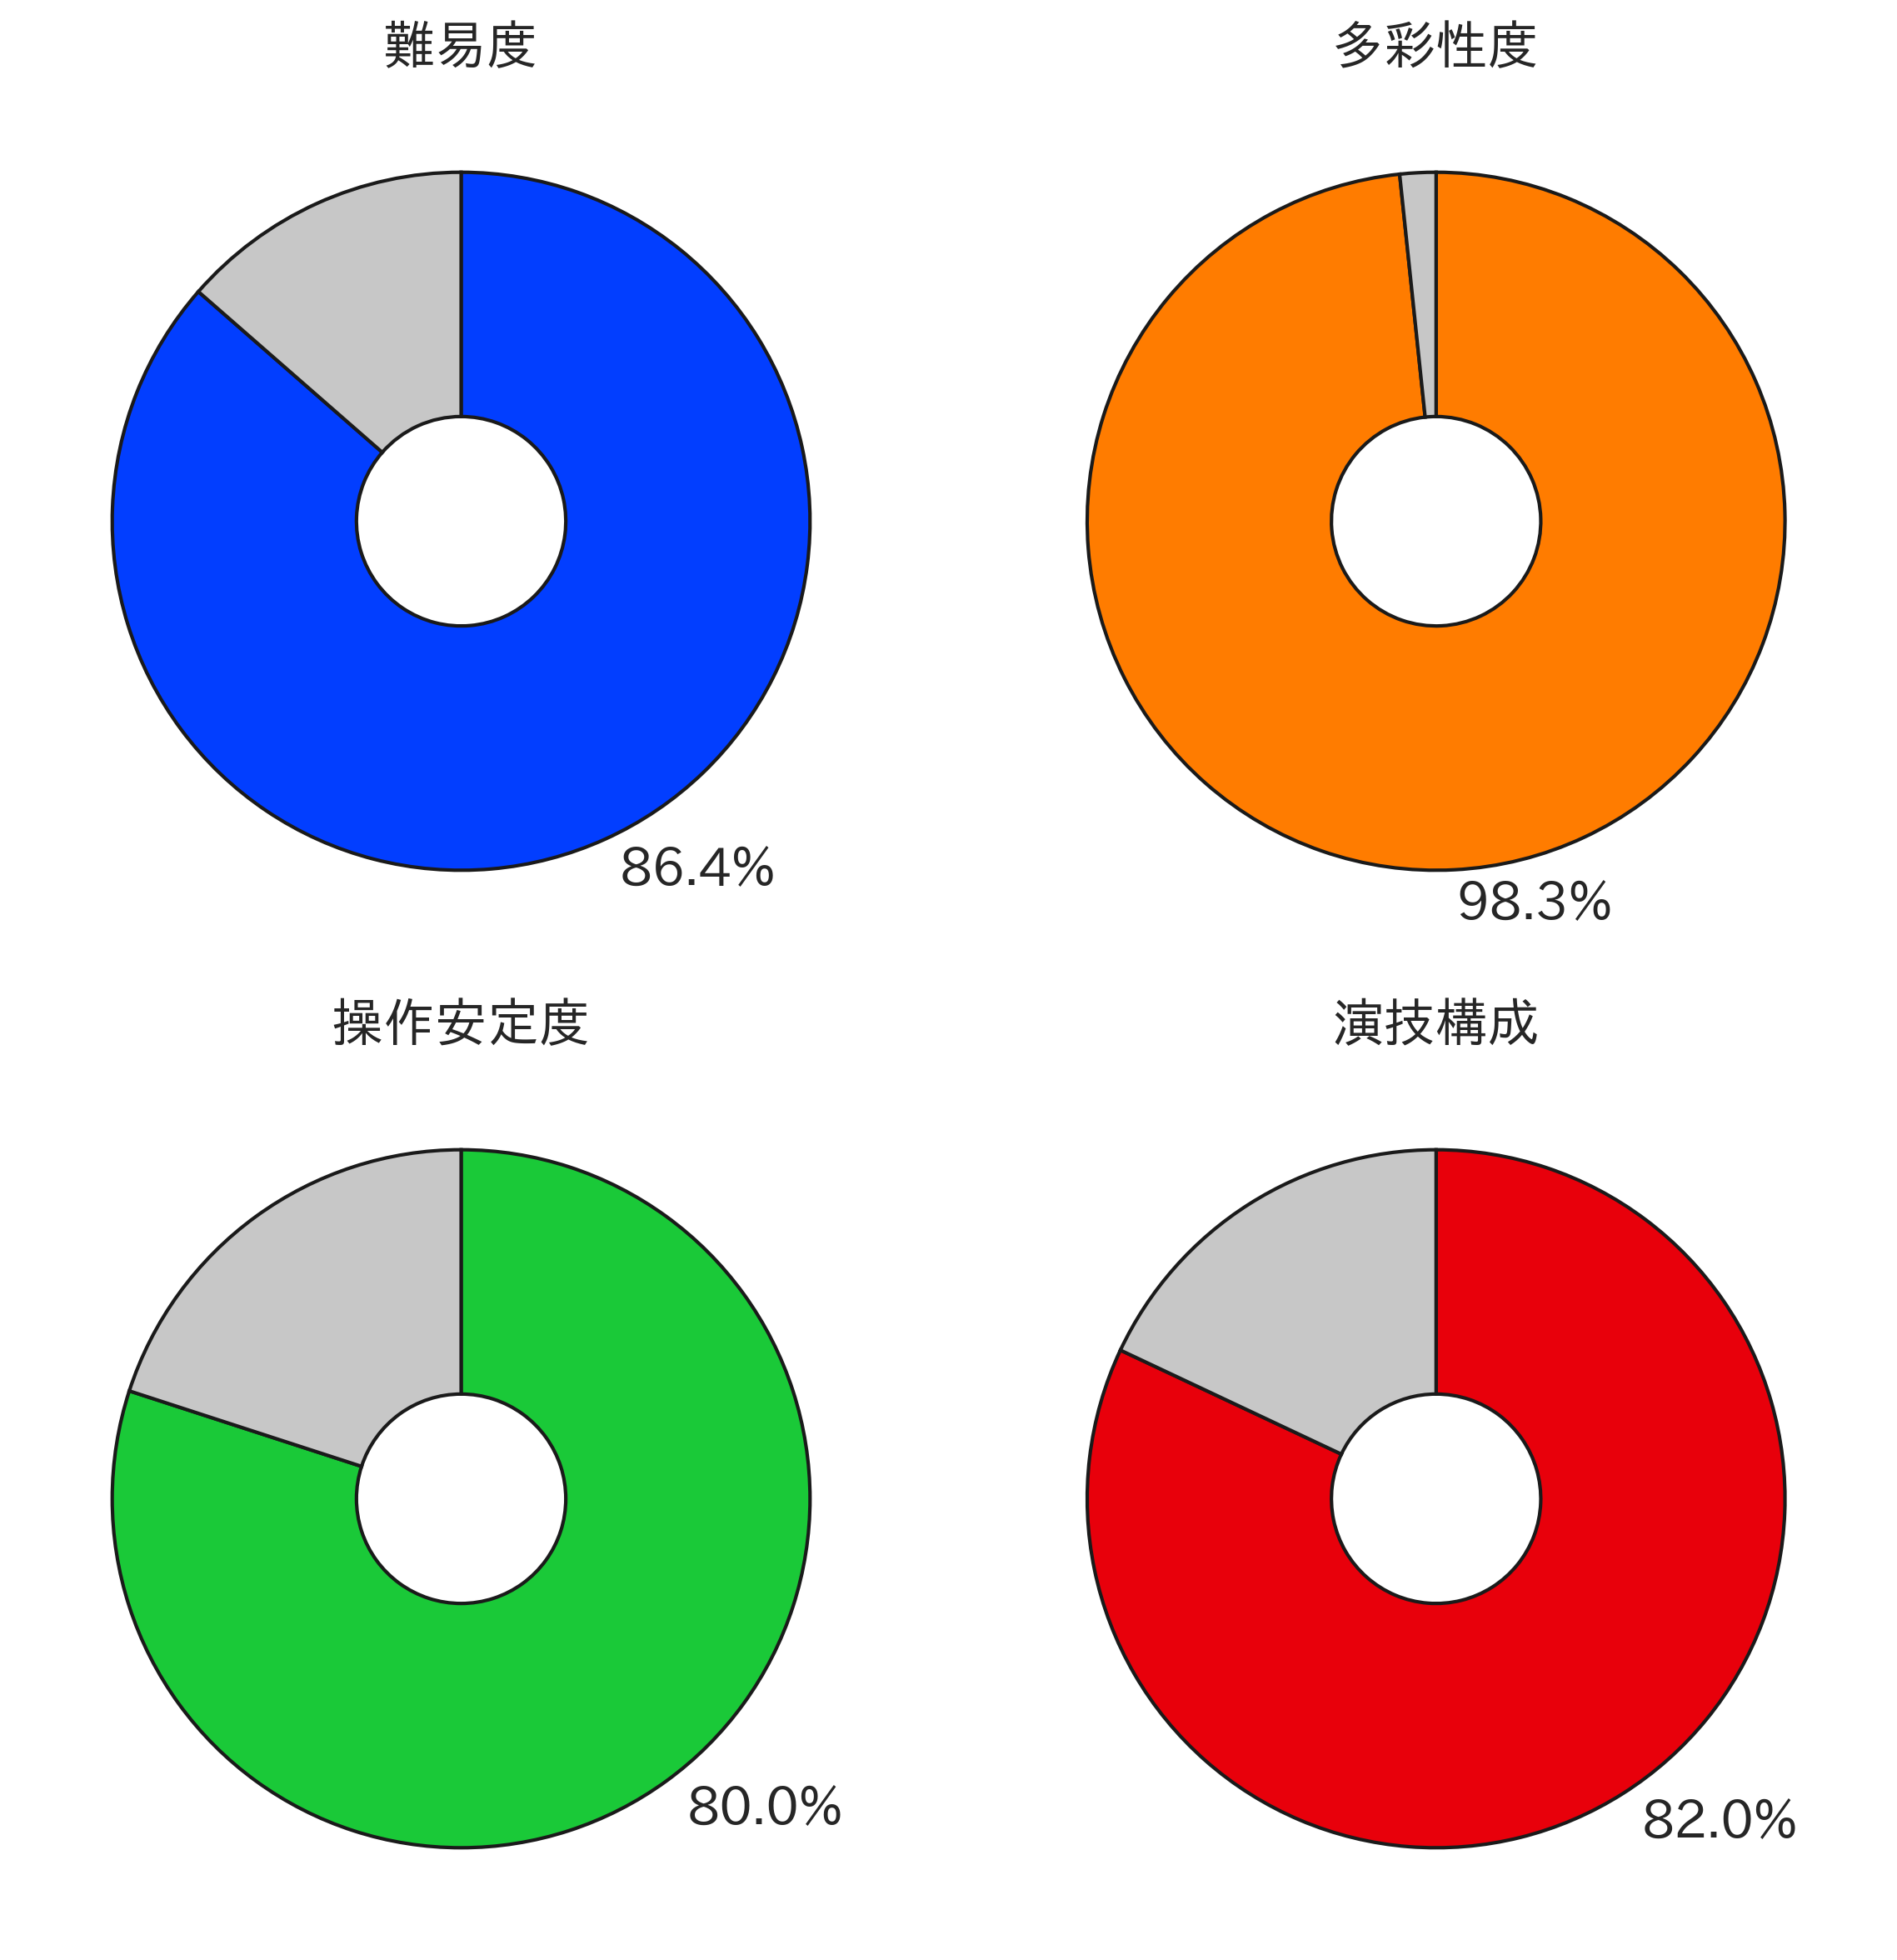

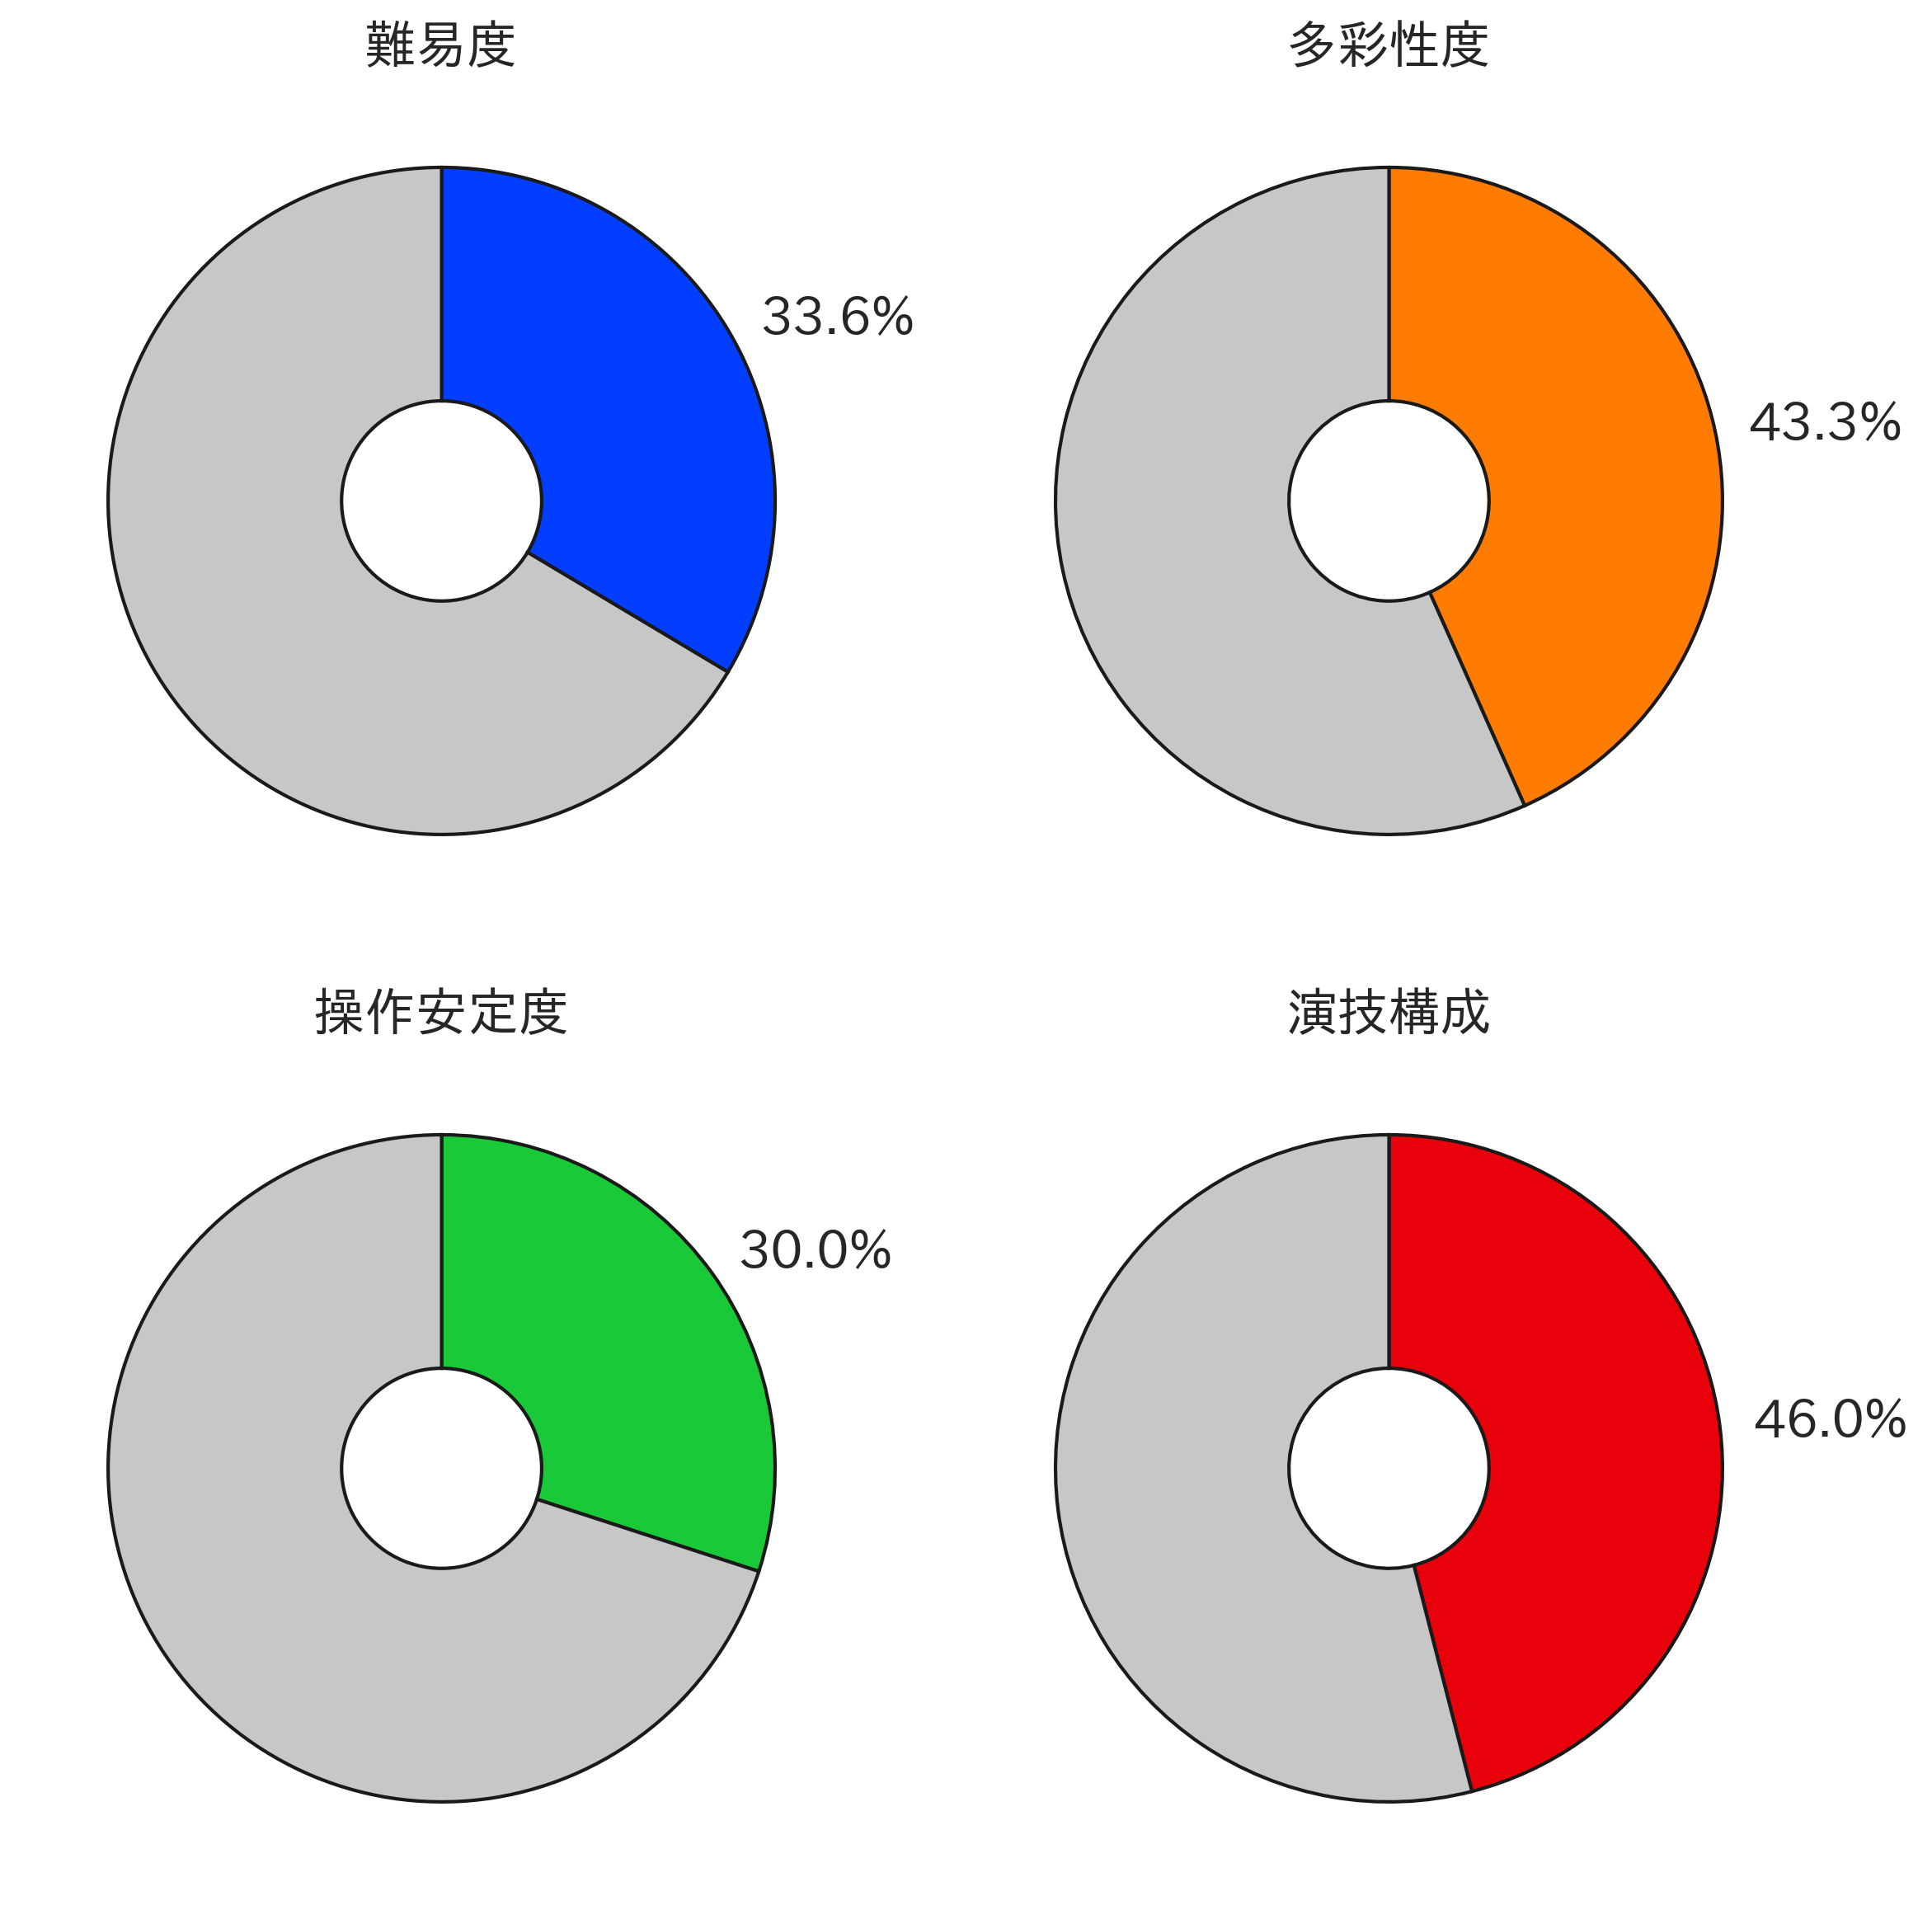

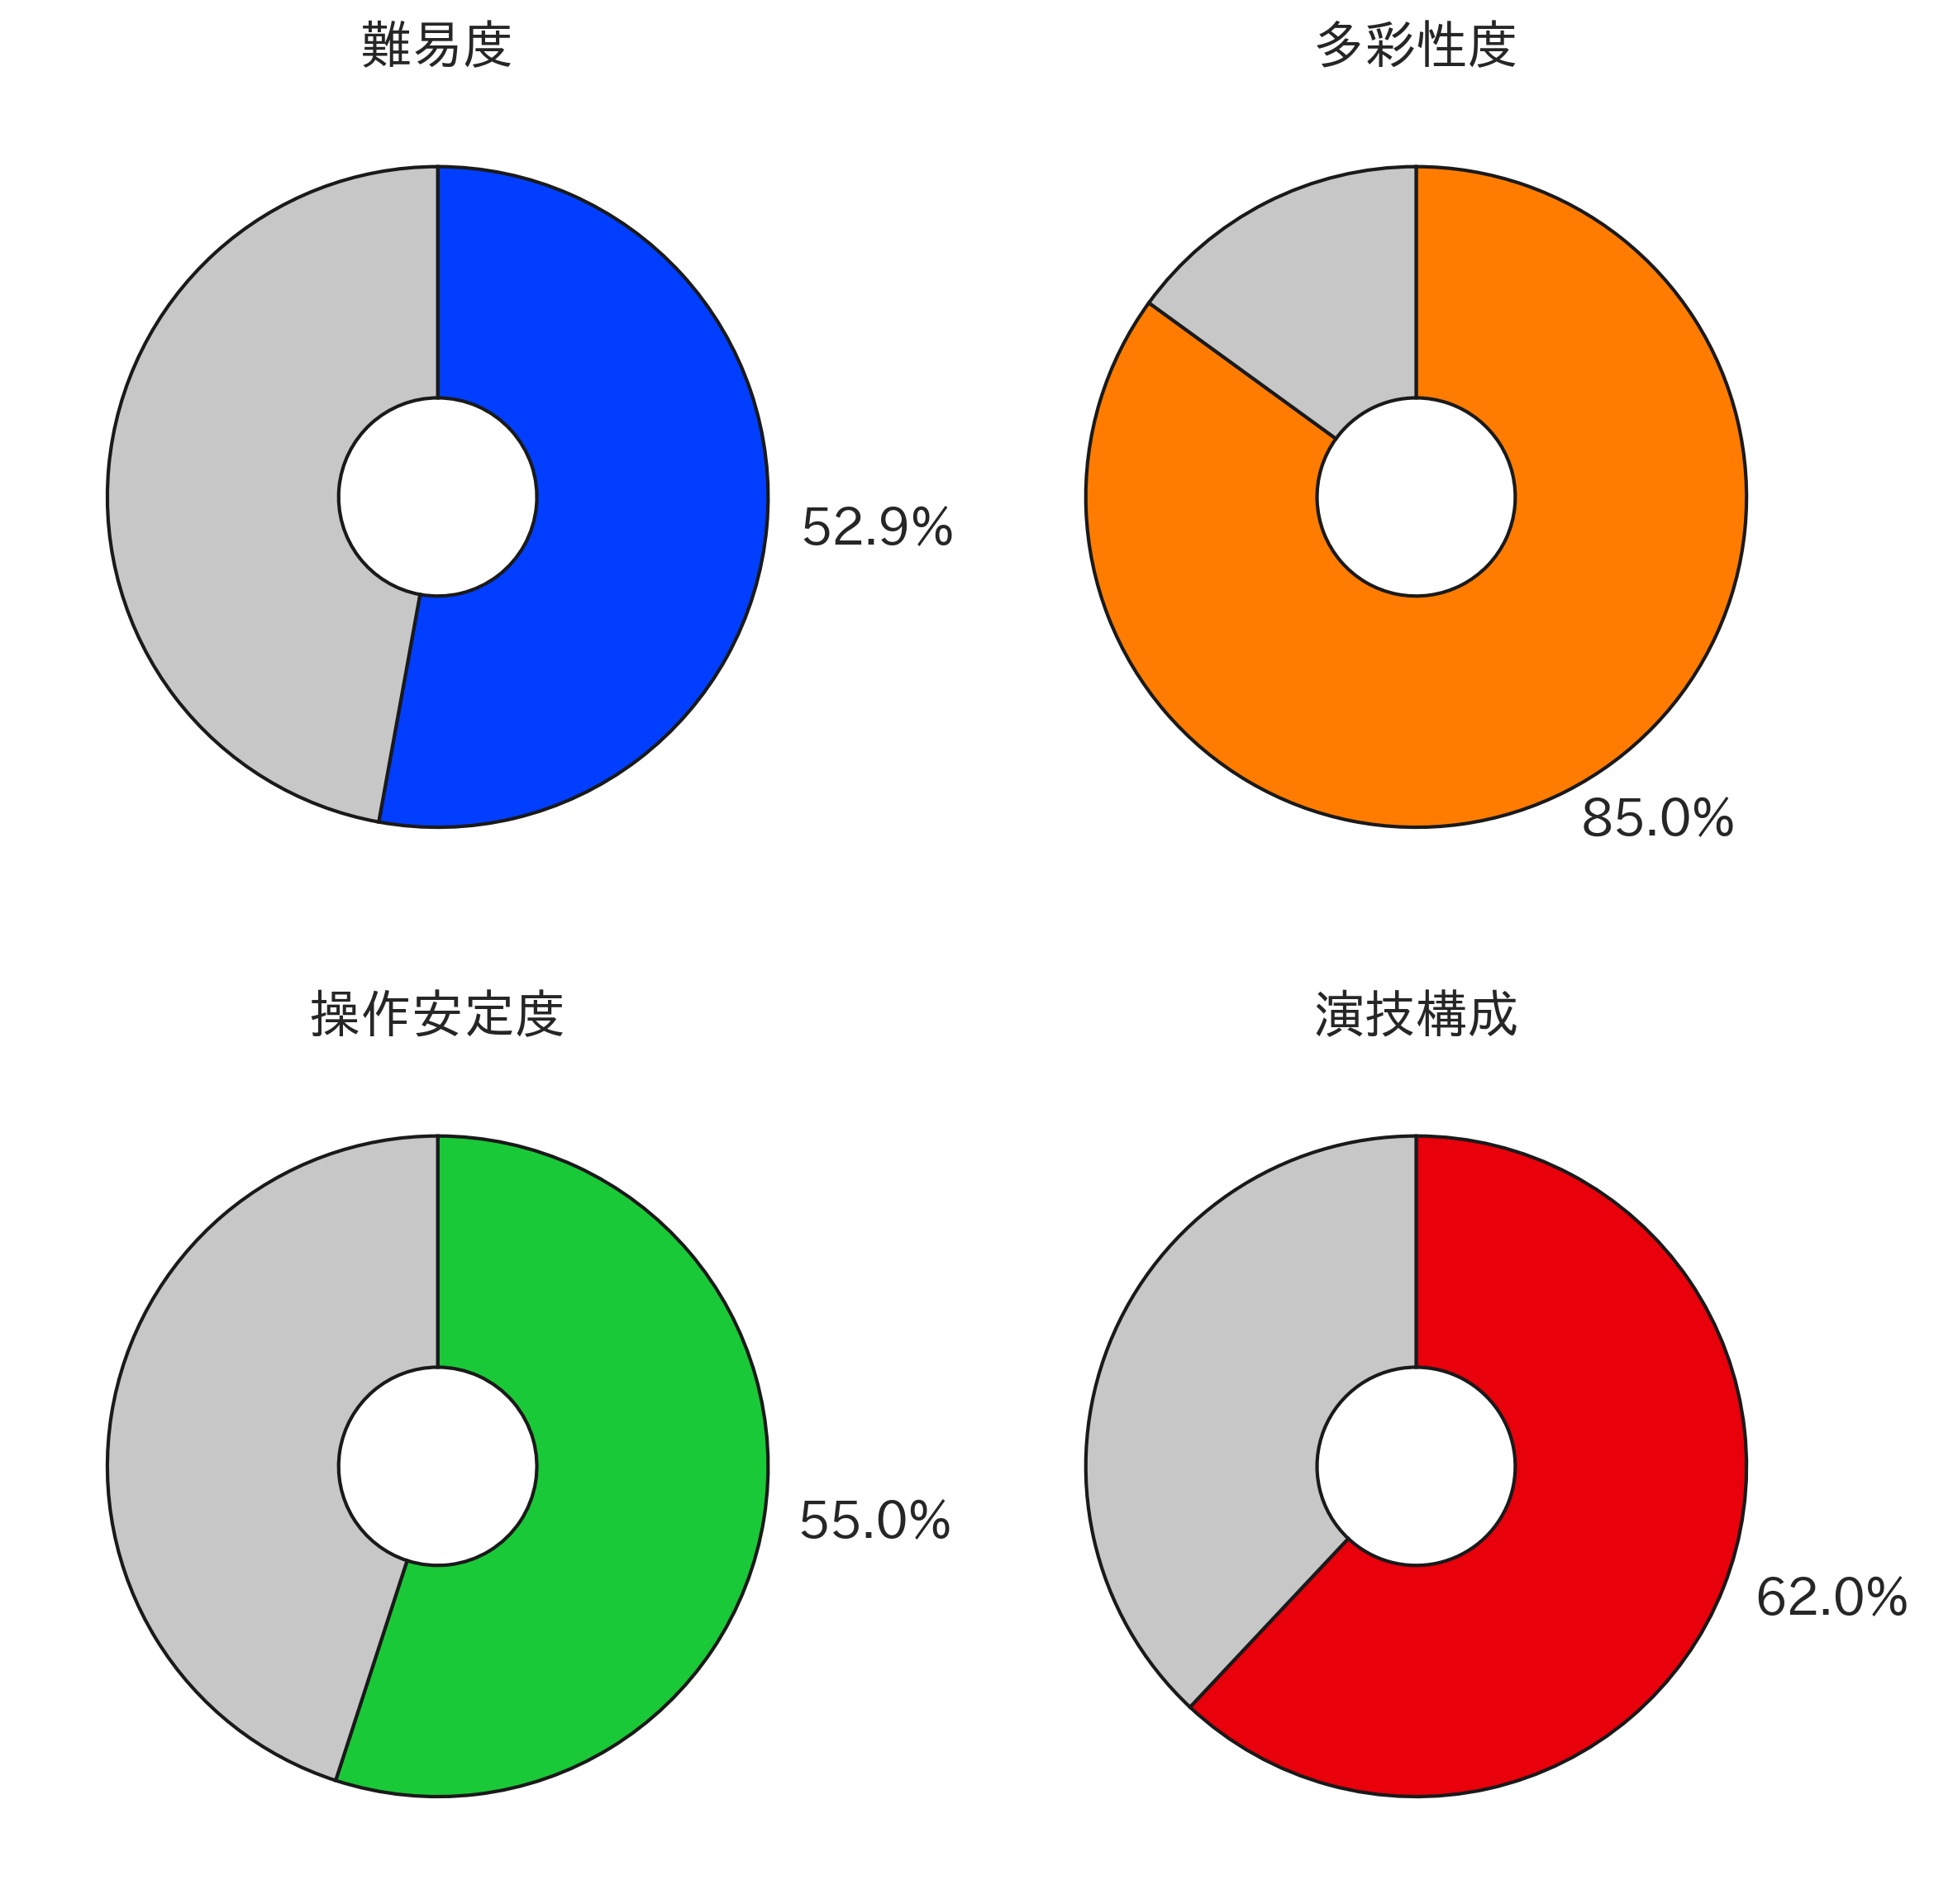

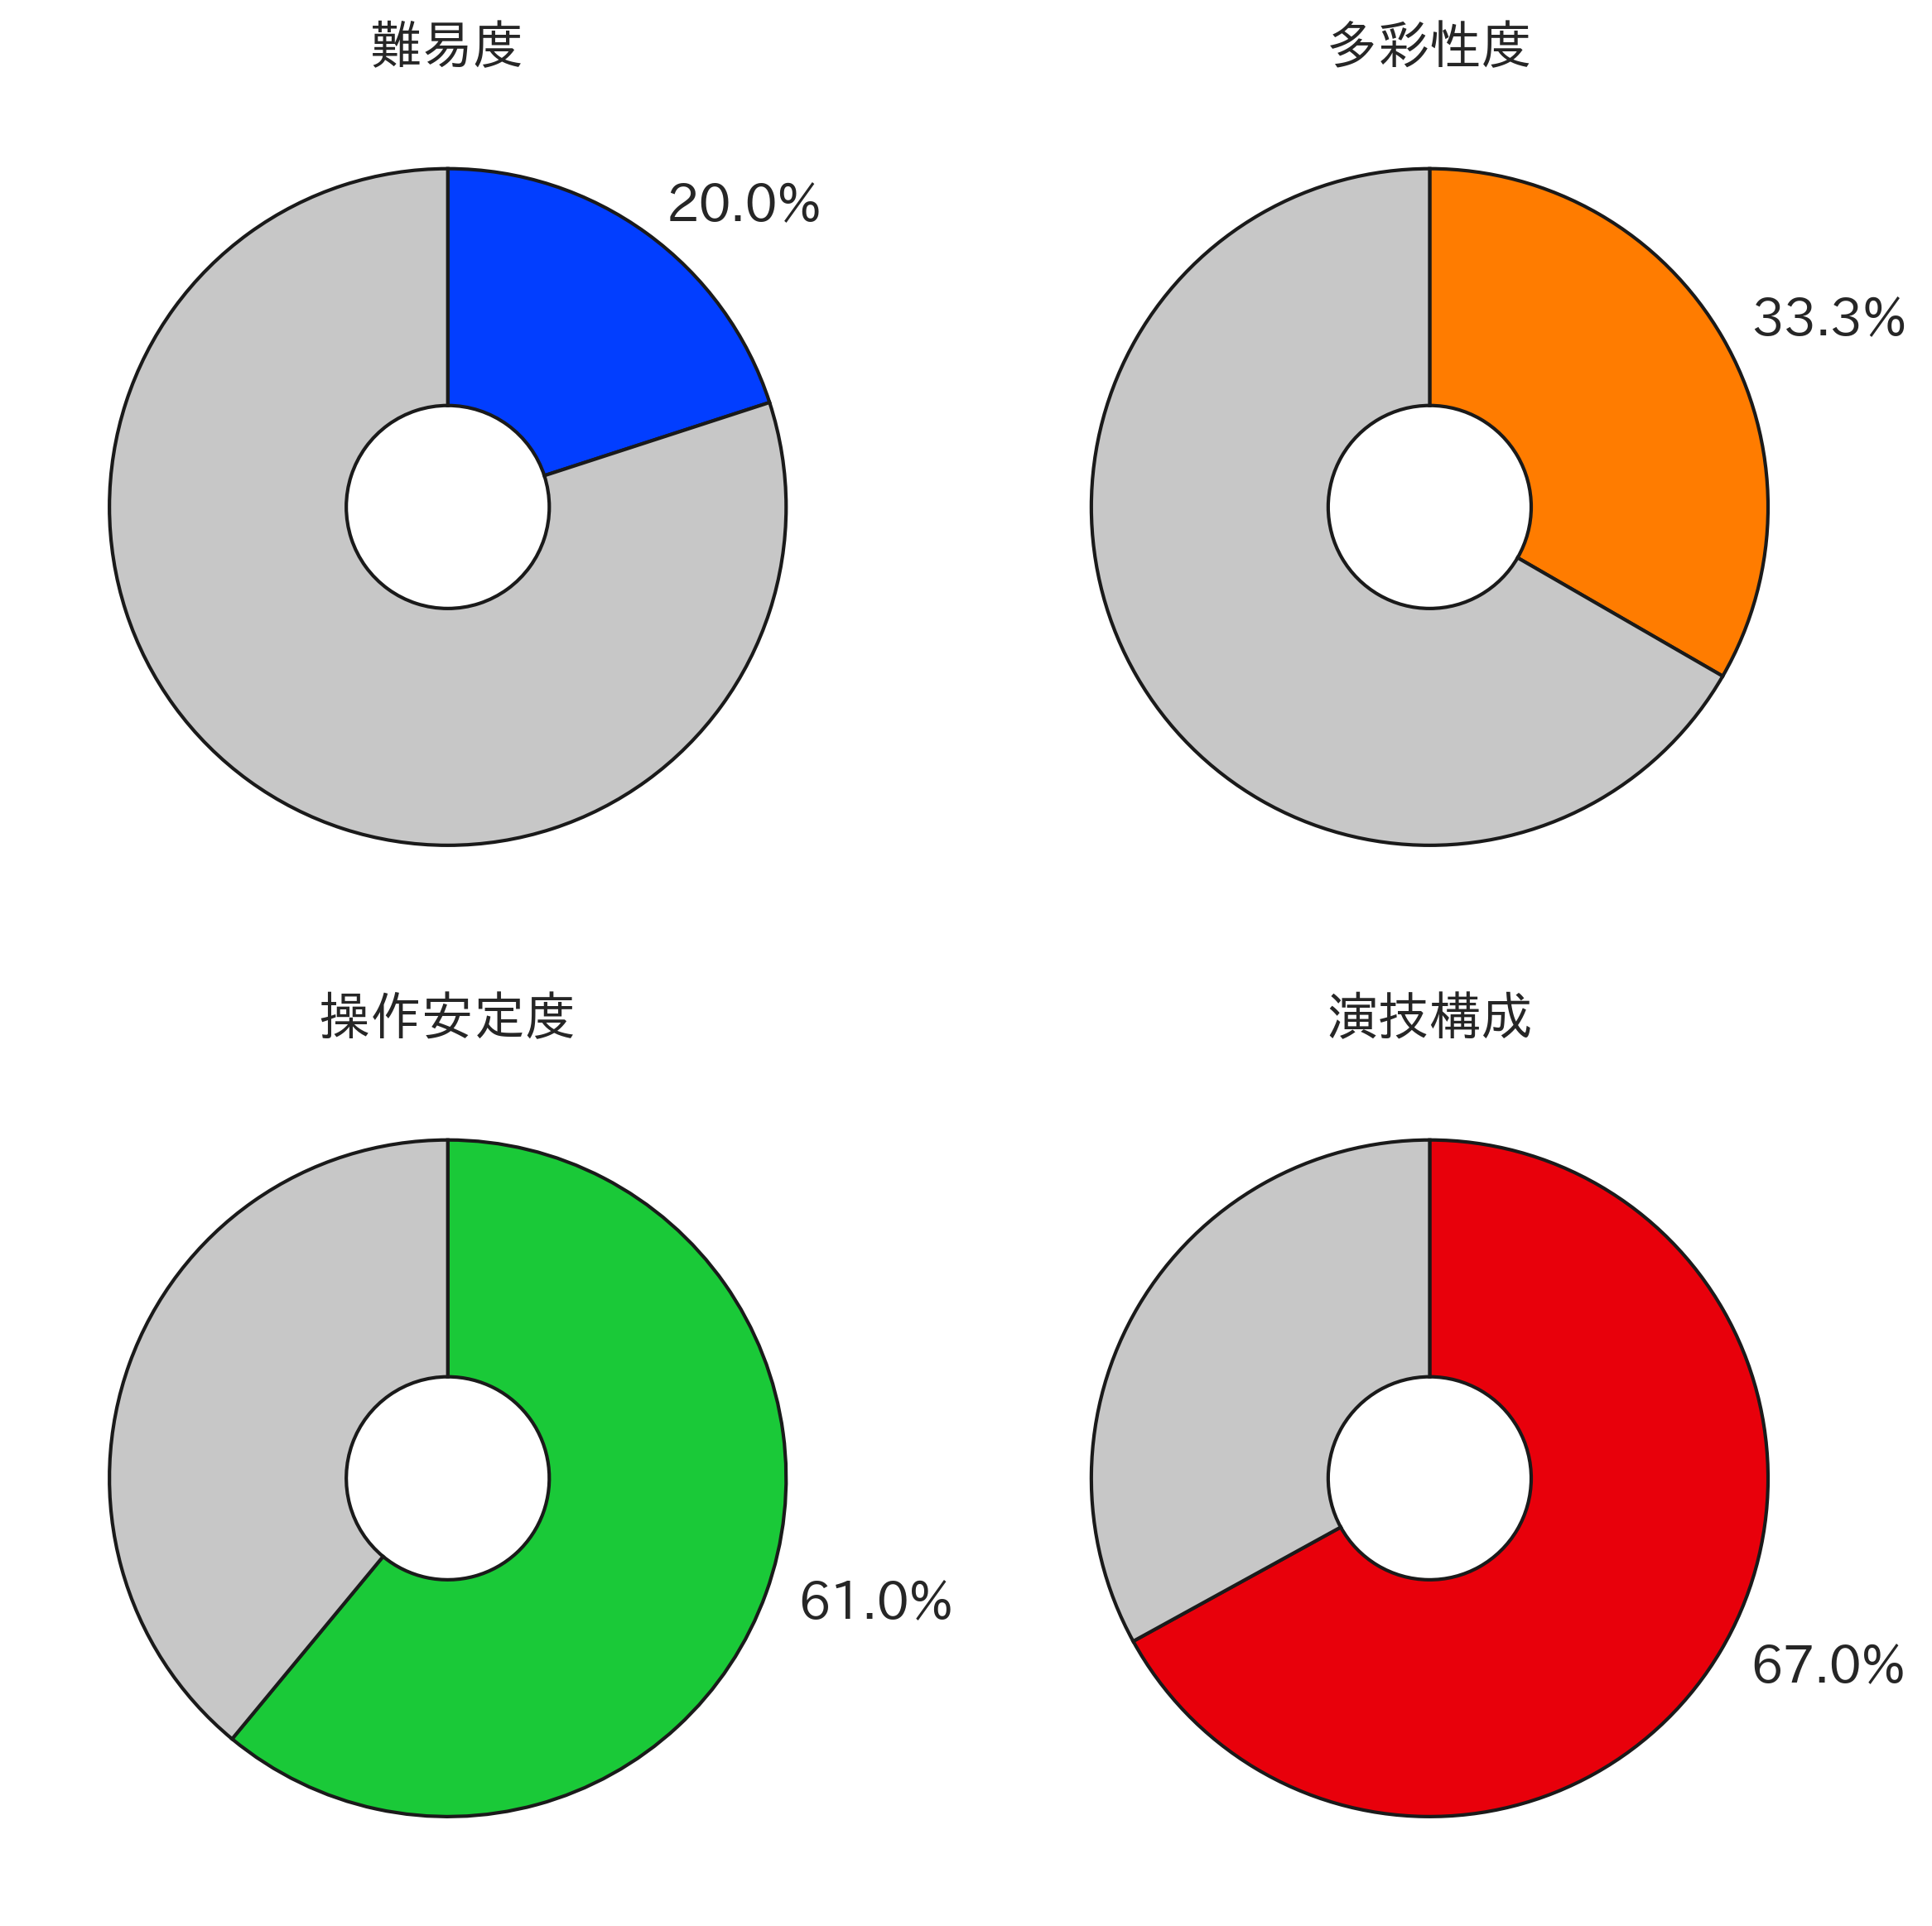

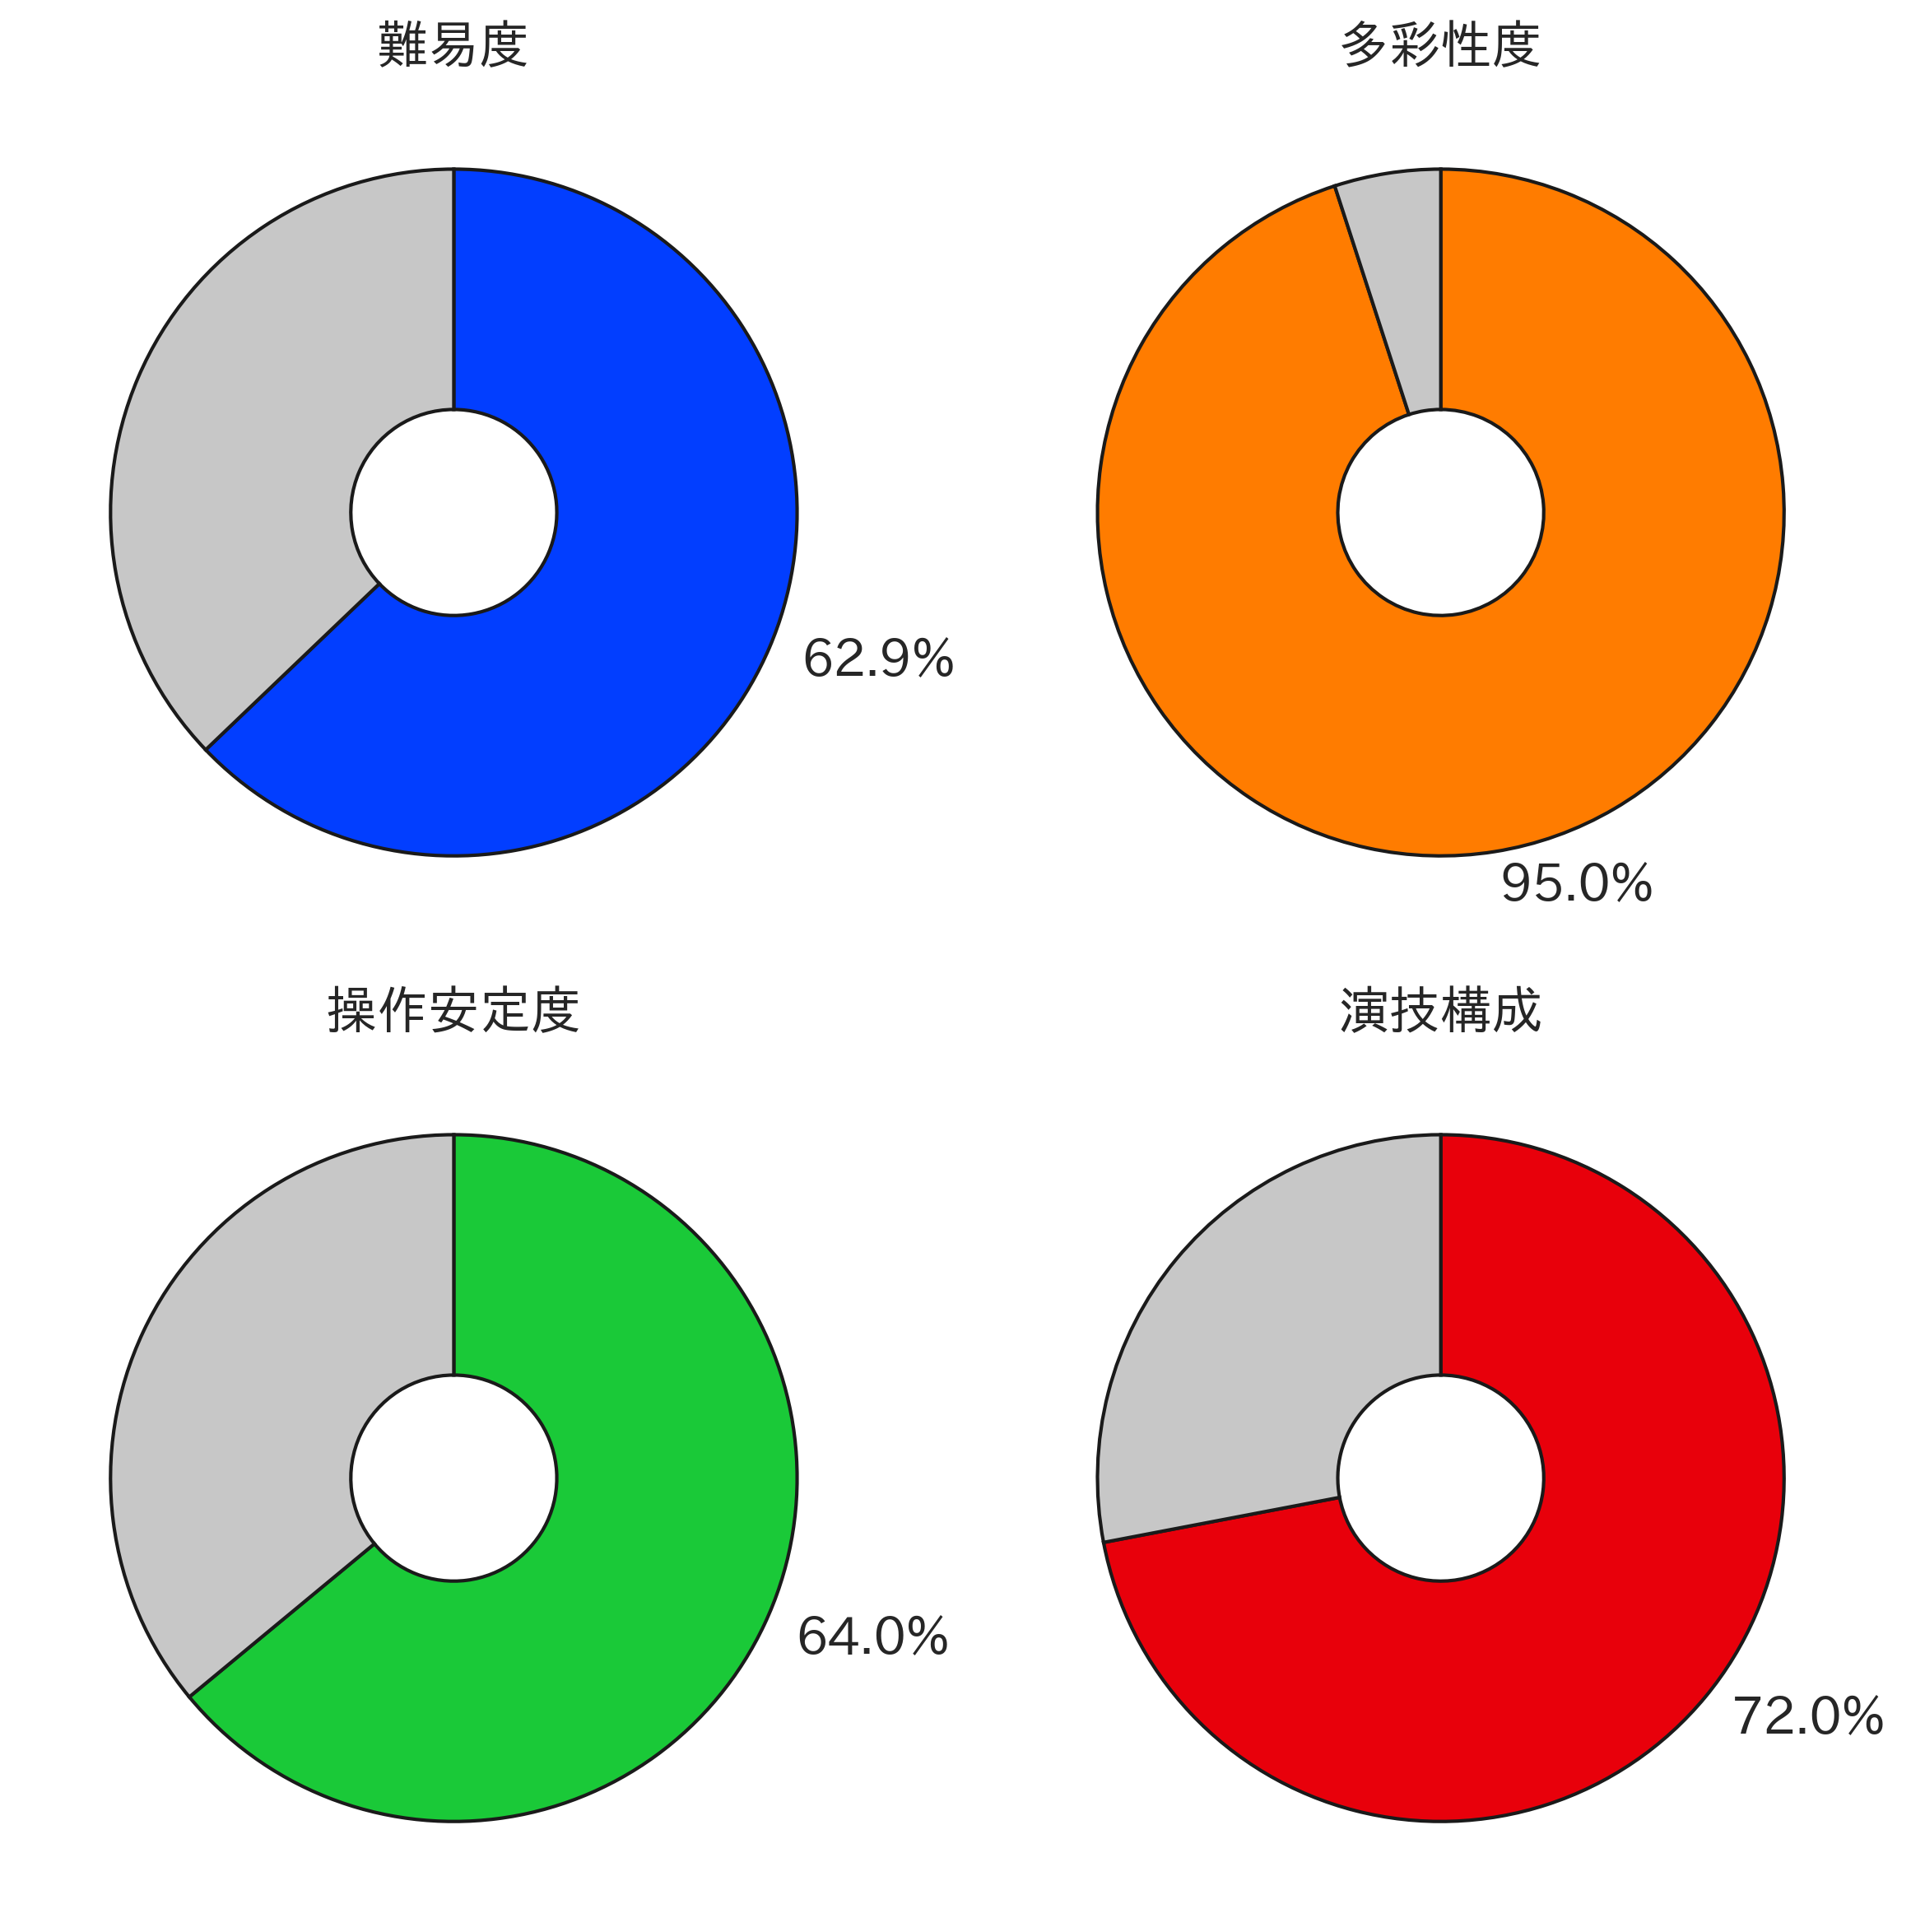

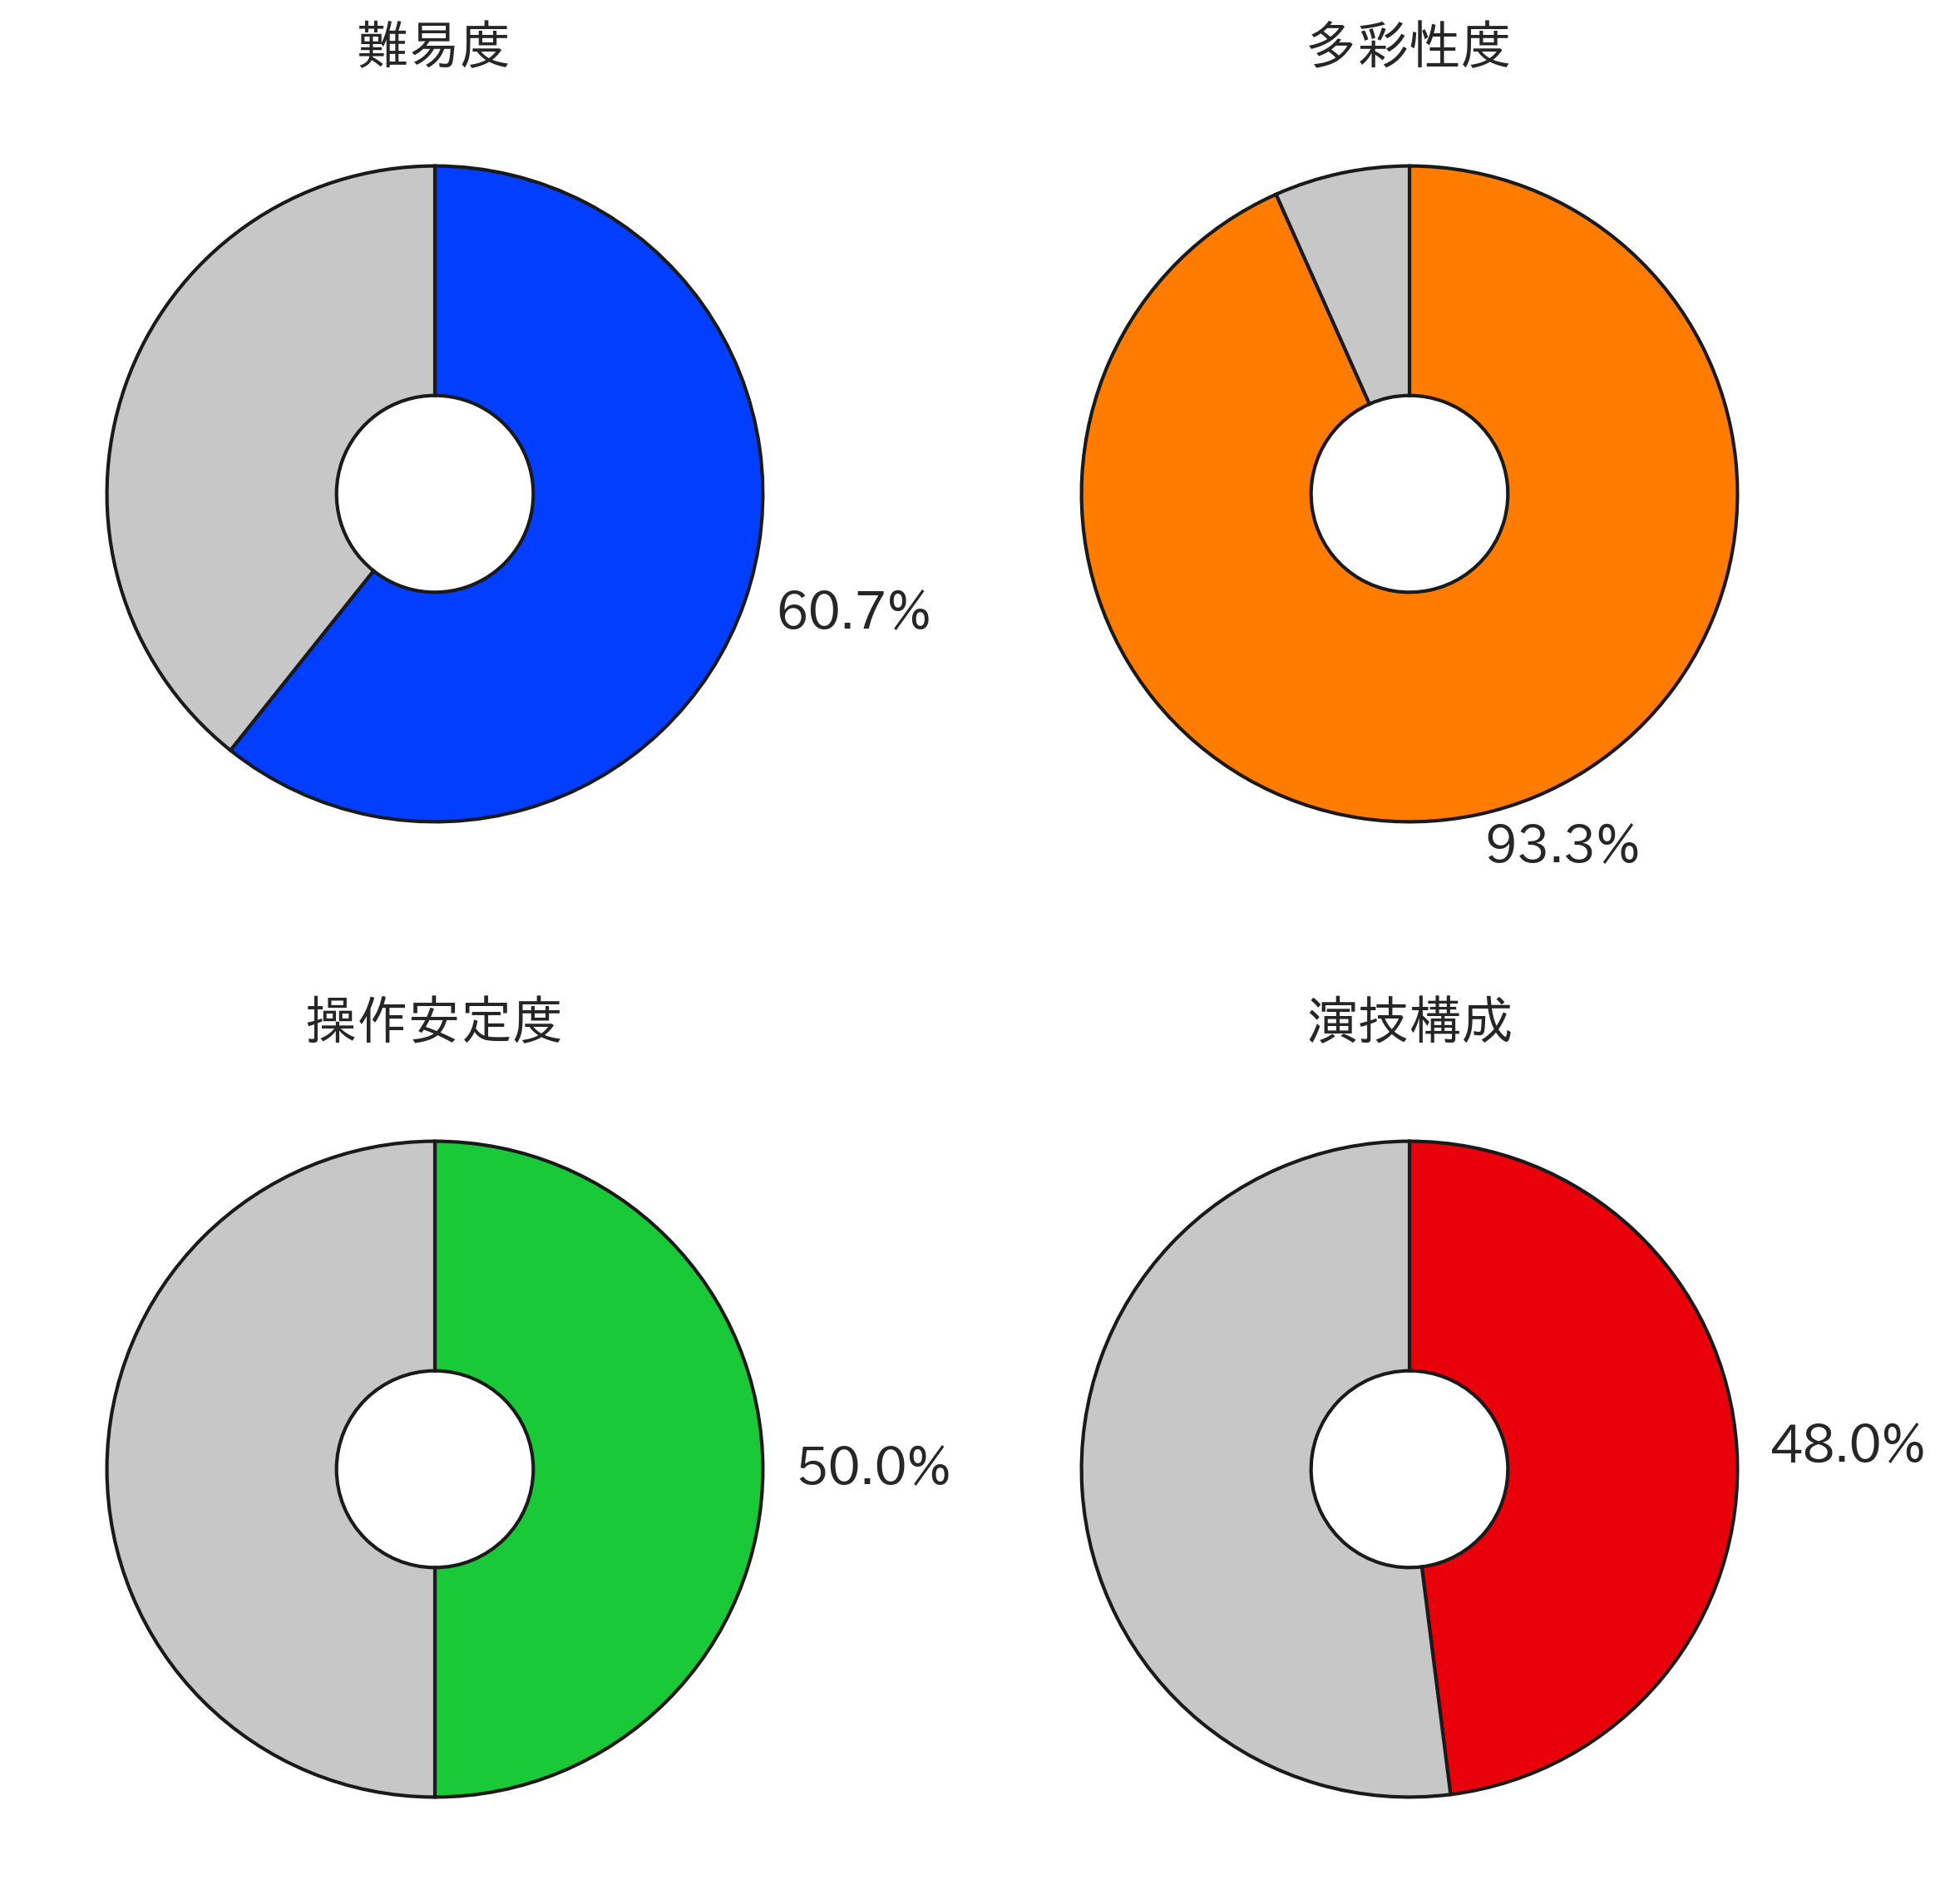

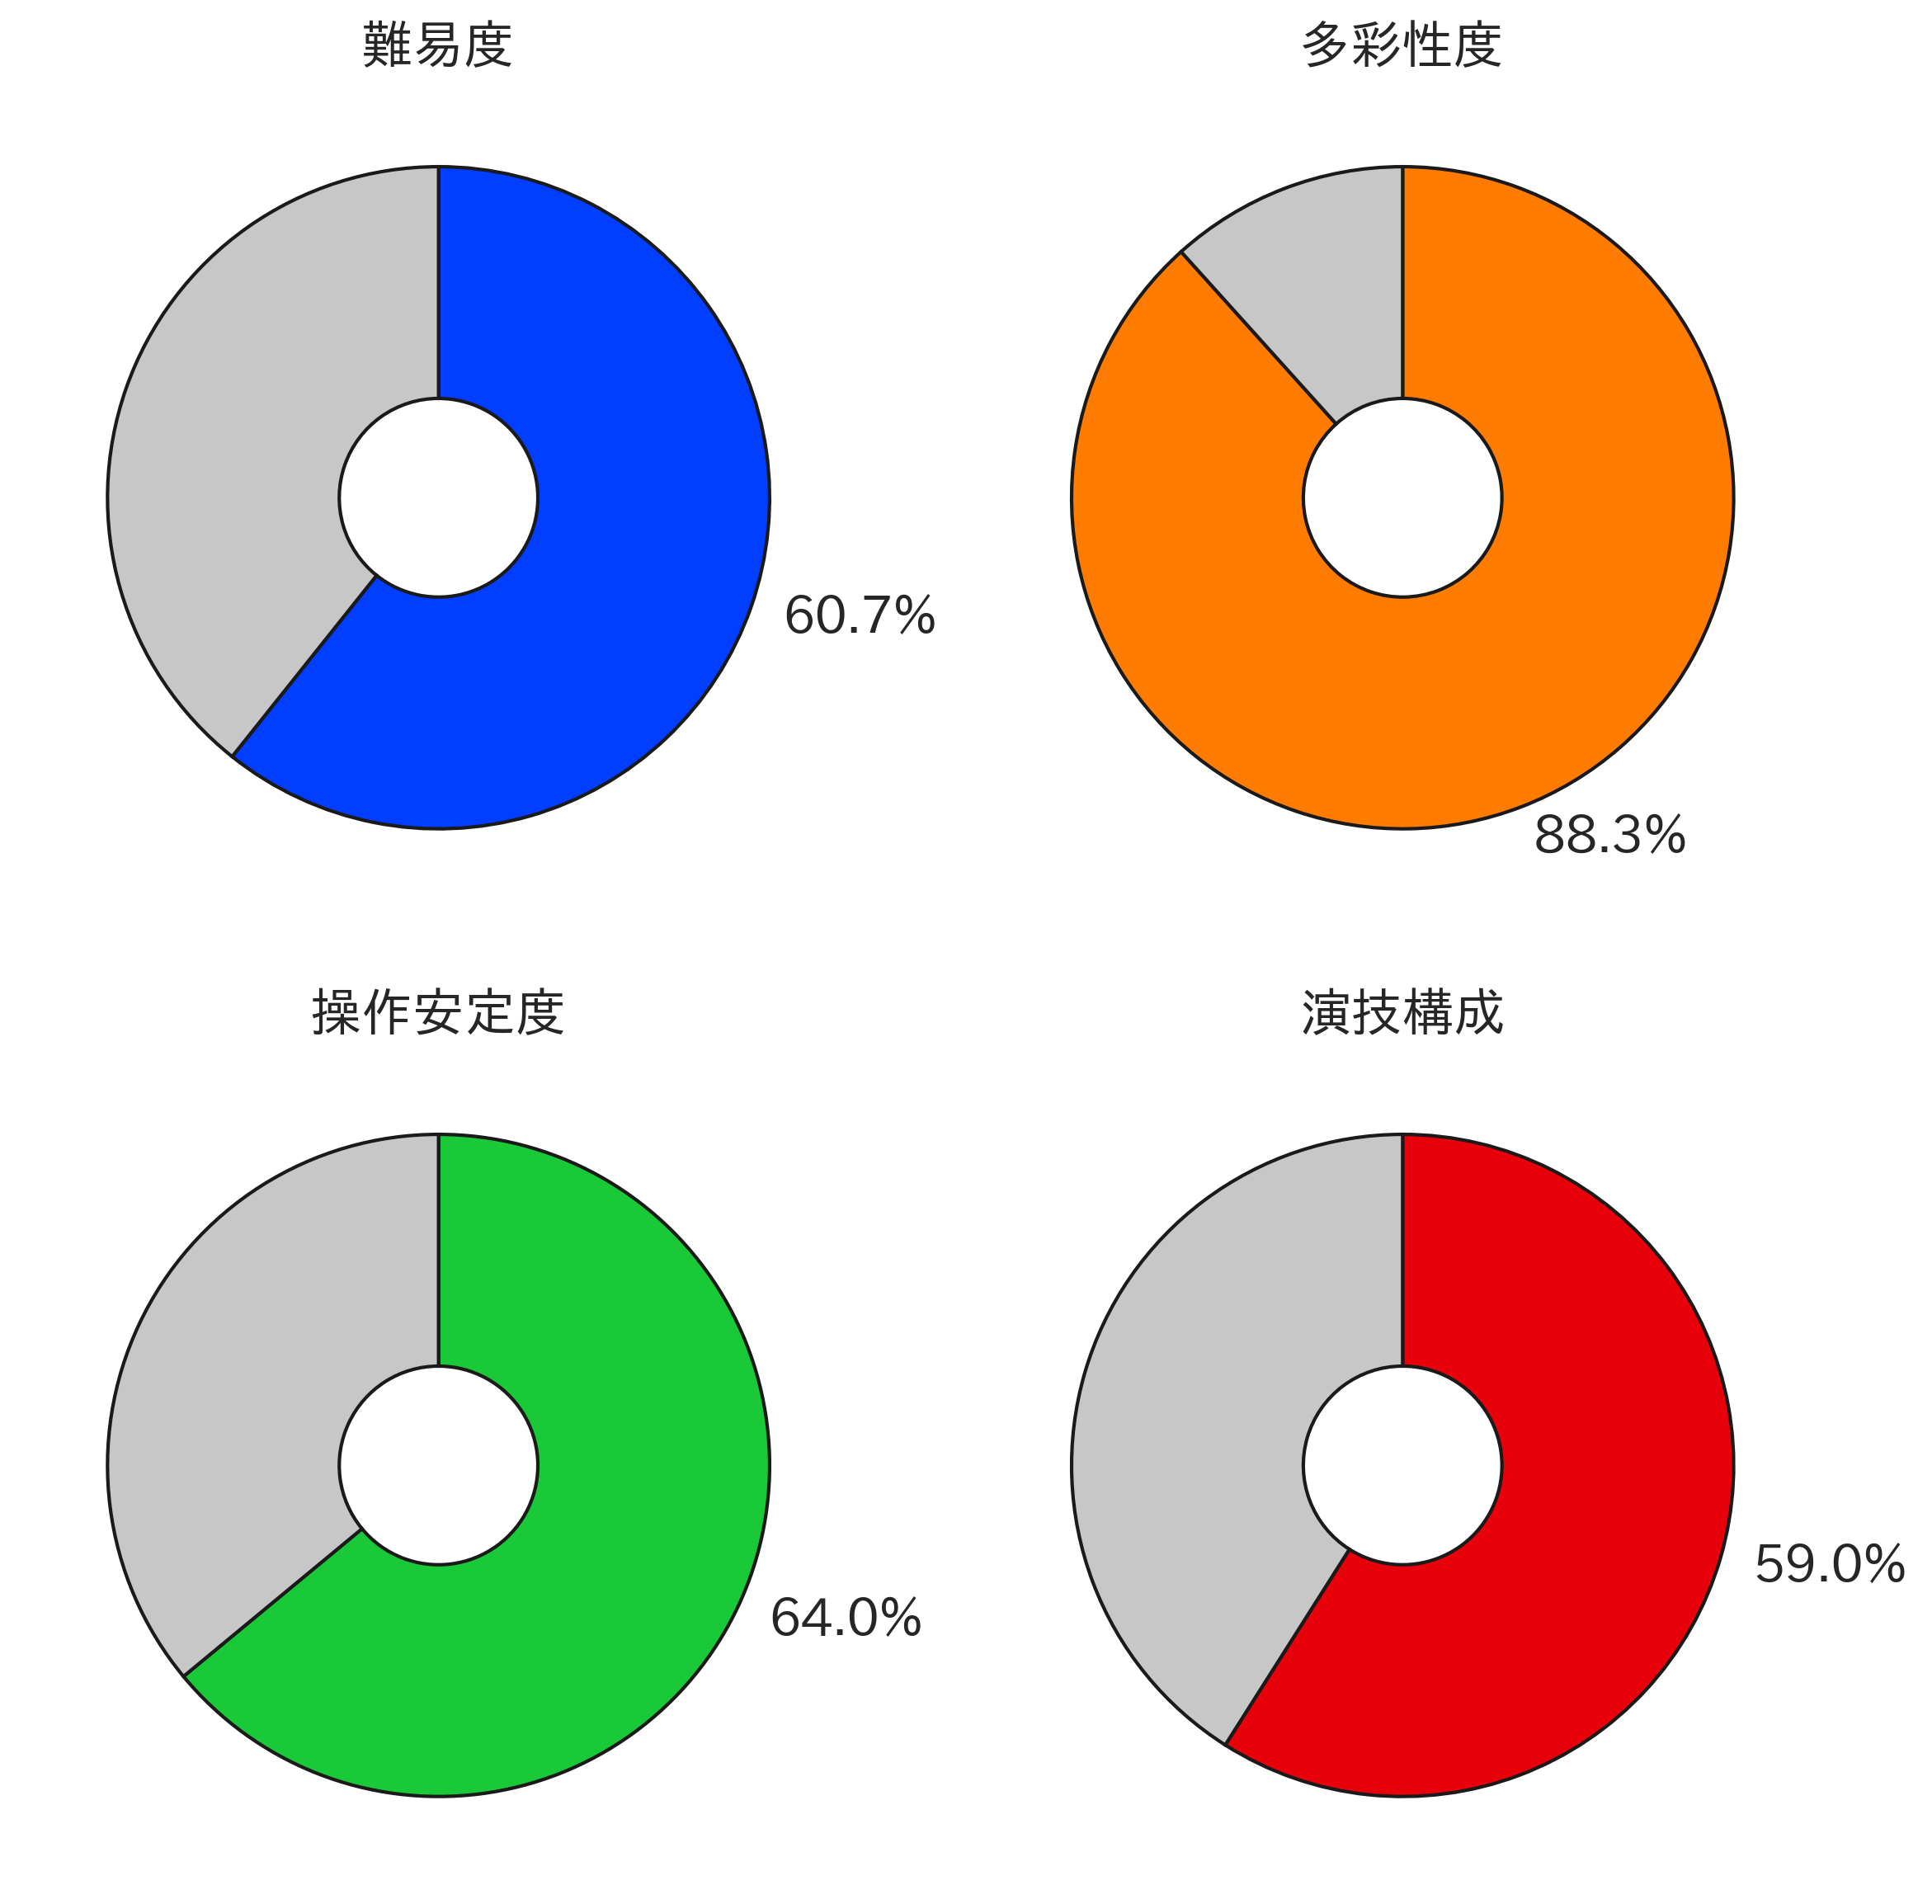

In [44]:
save_pie_chart(result_diabolo)
save_pie_chart(result_toss)

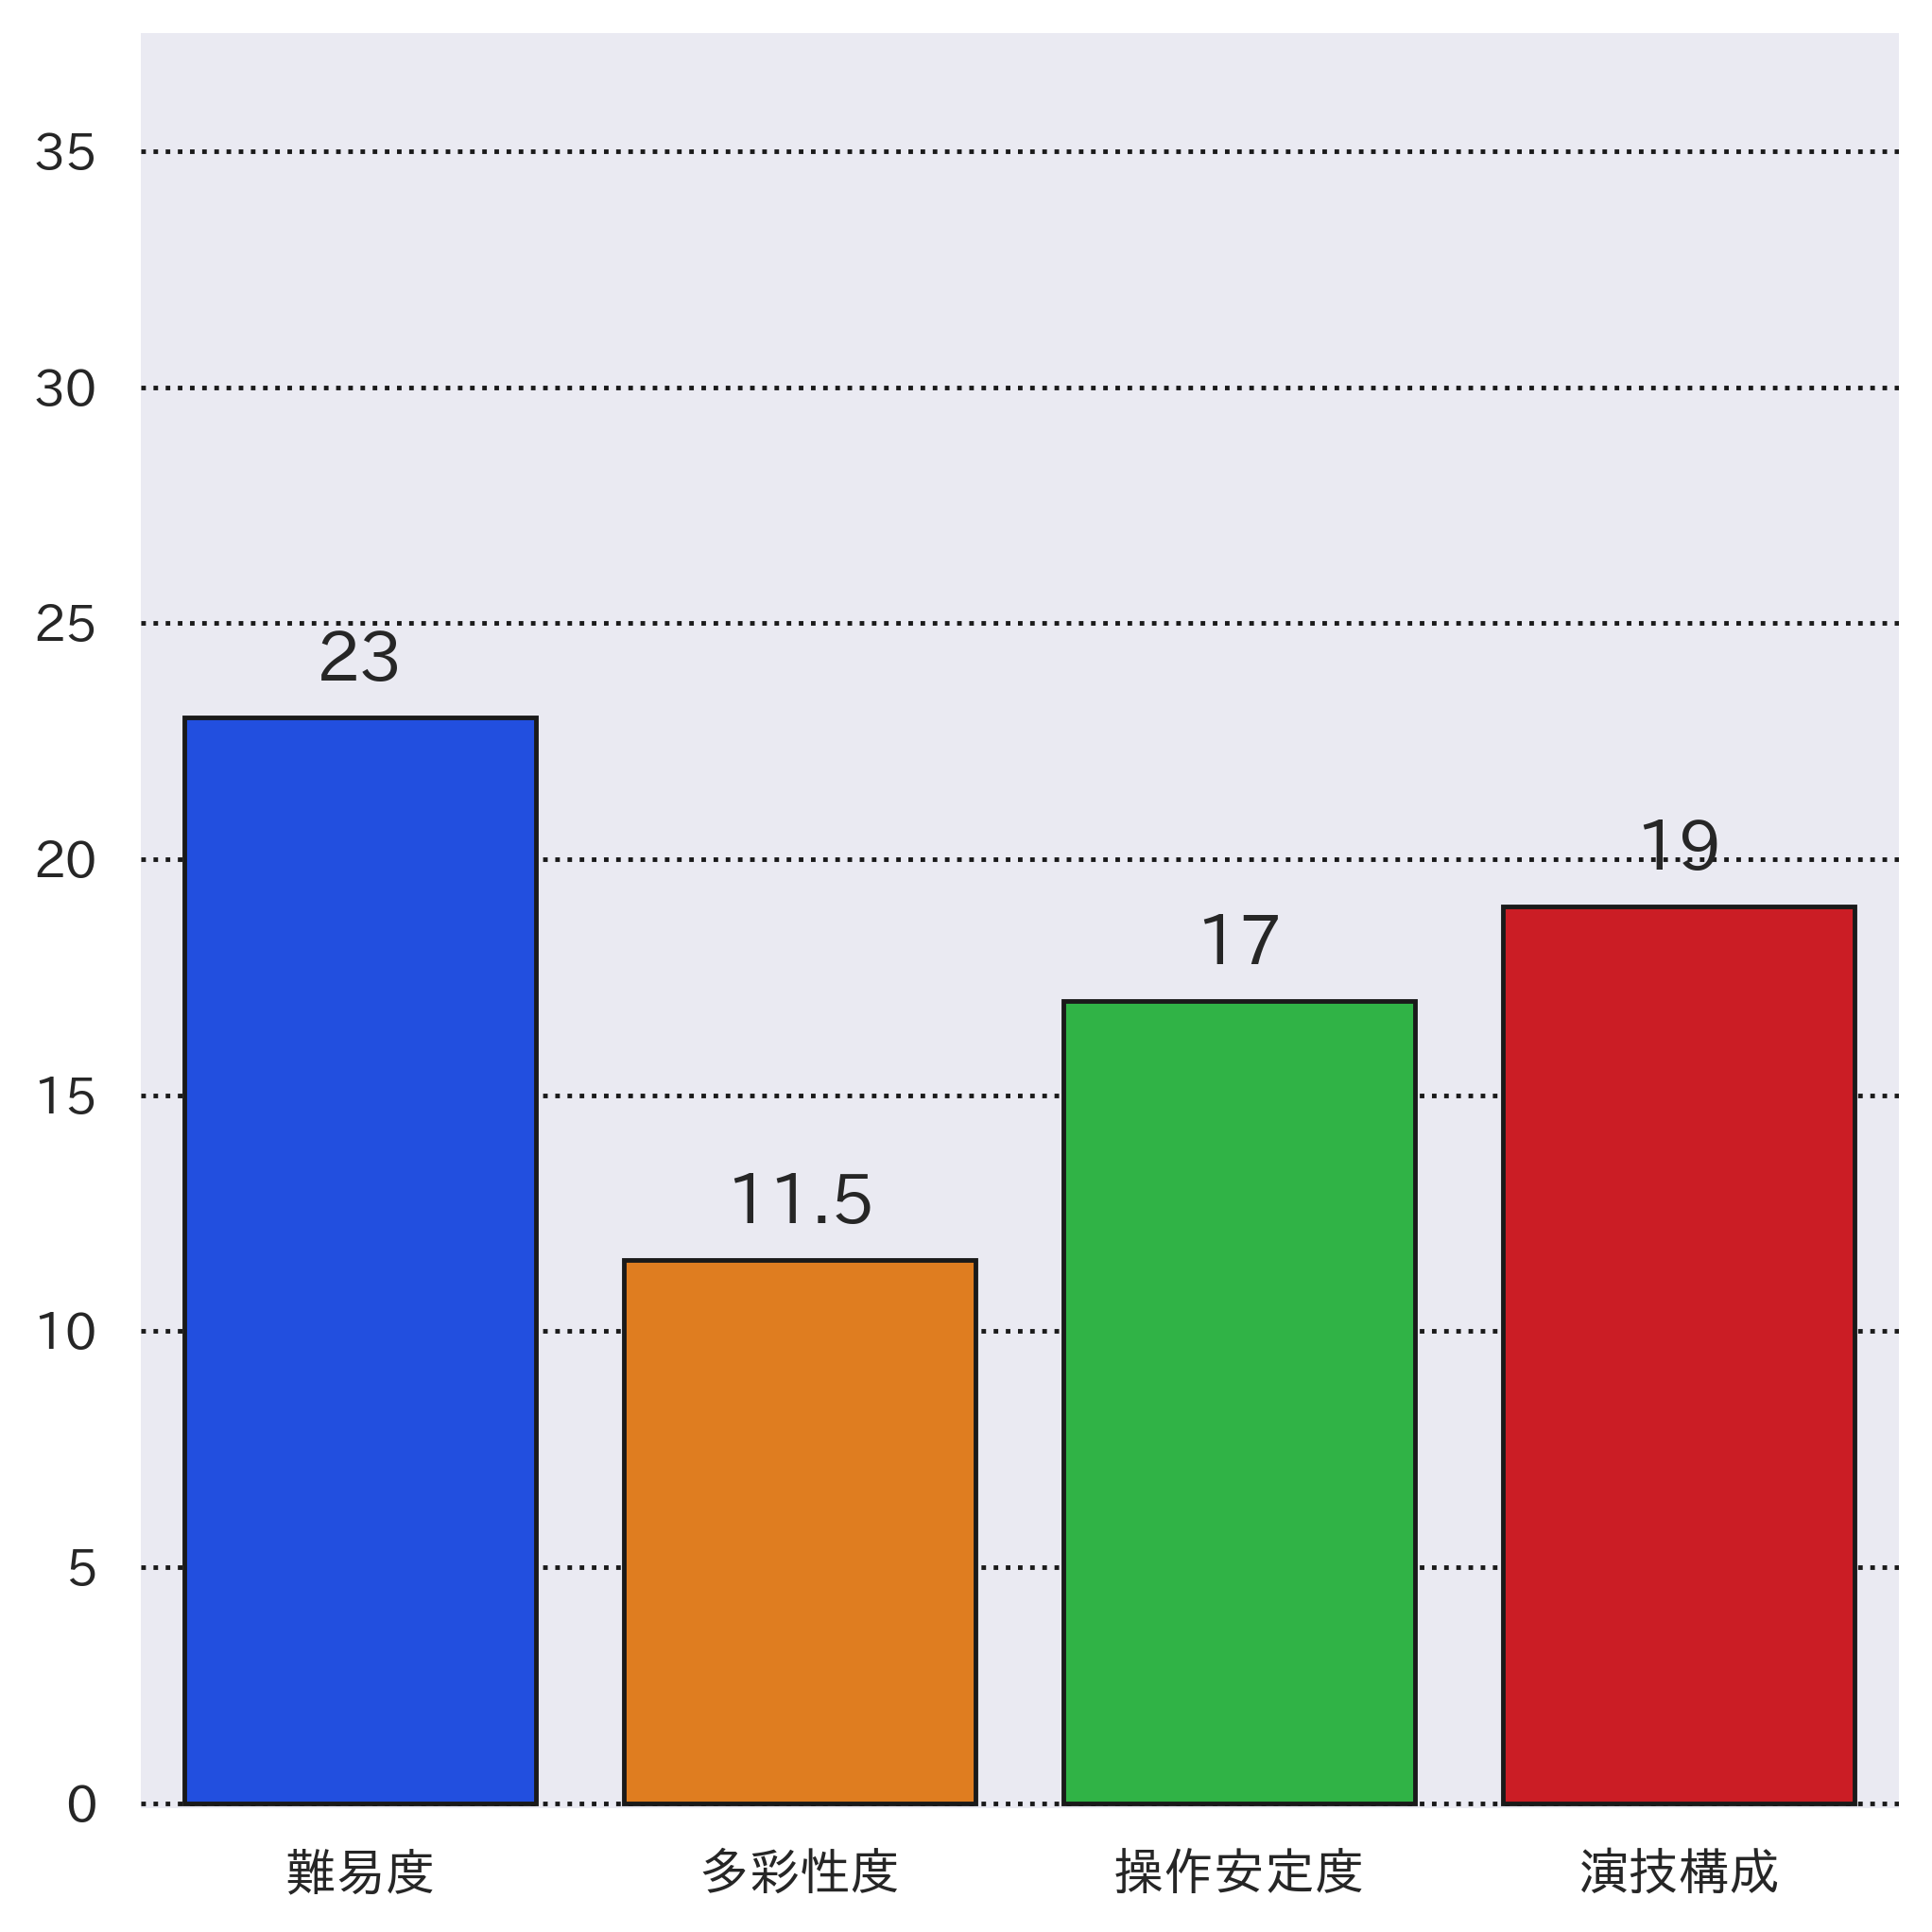

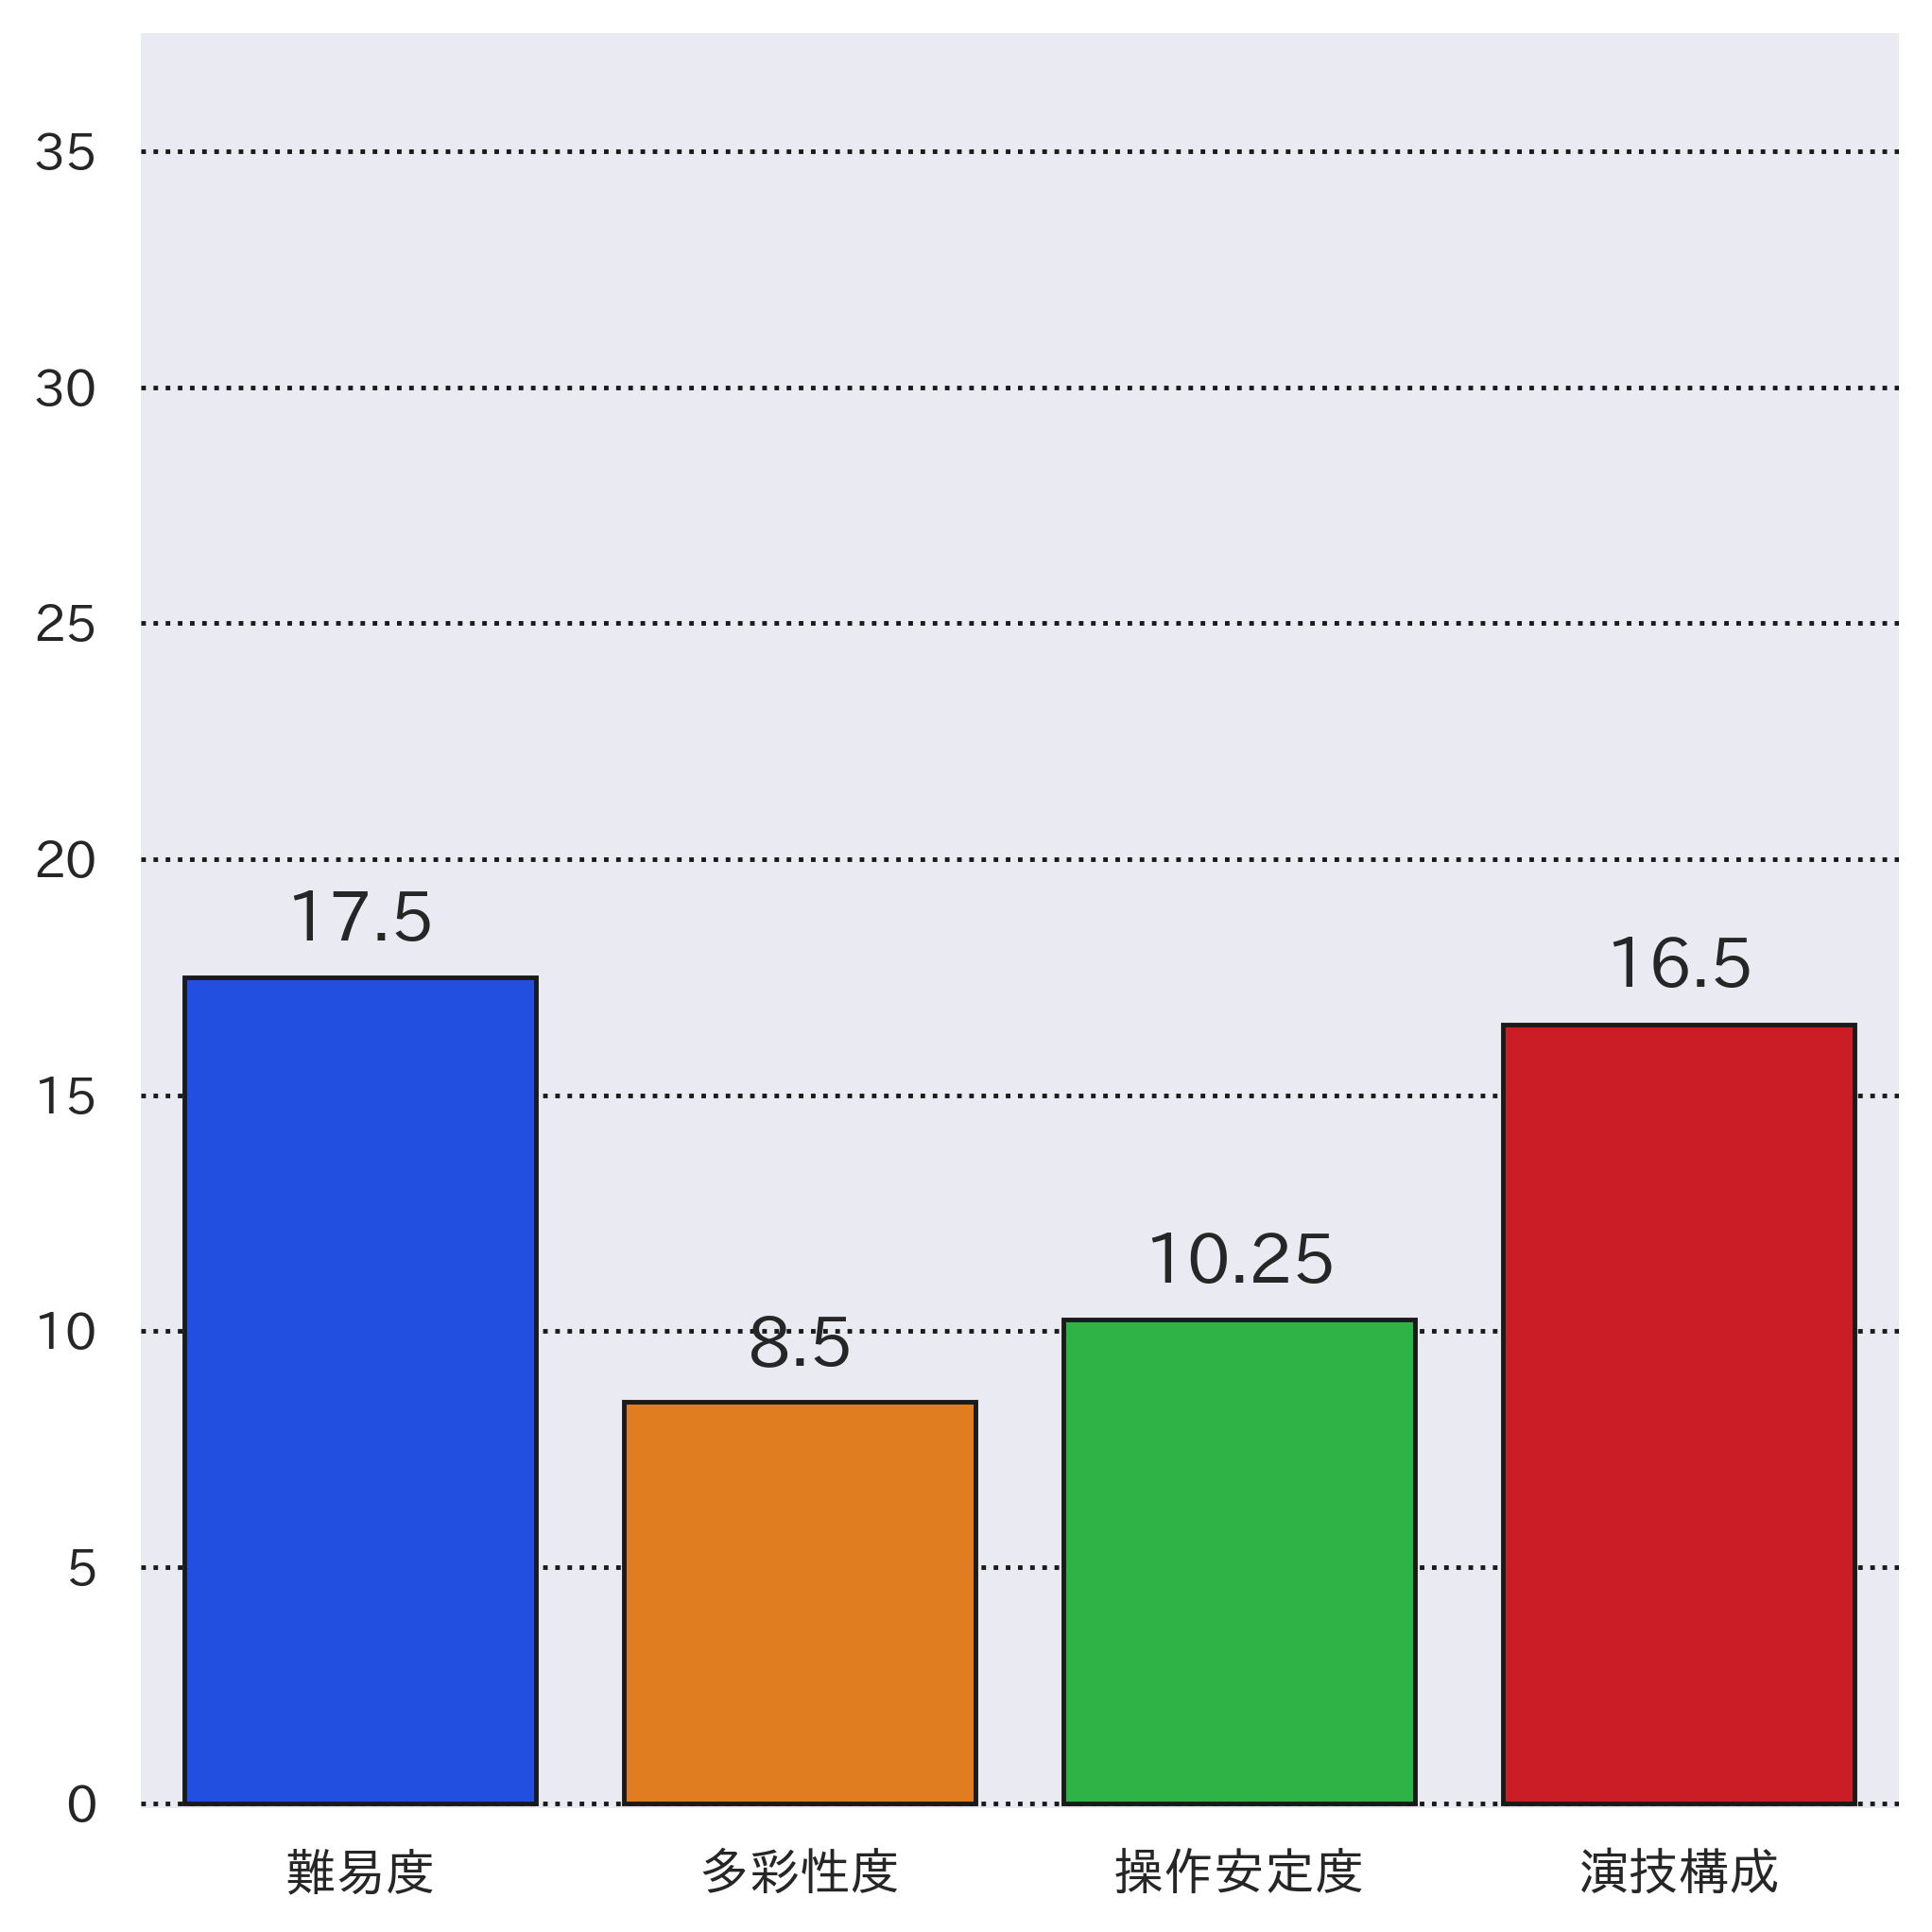

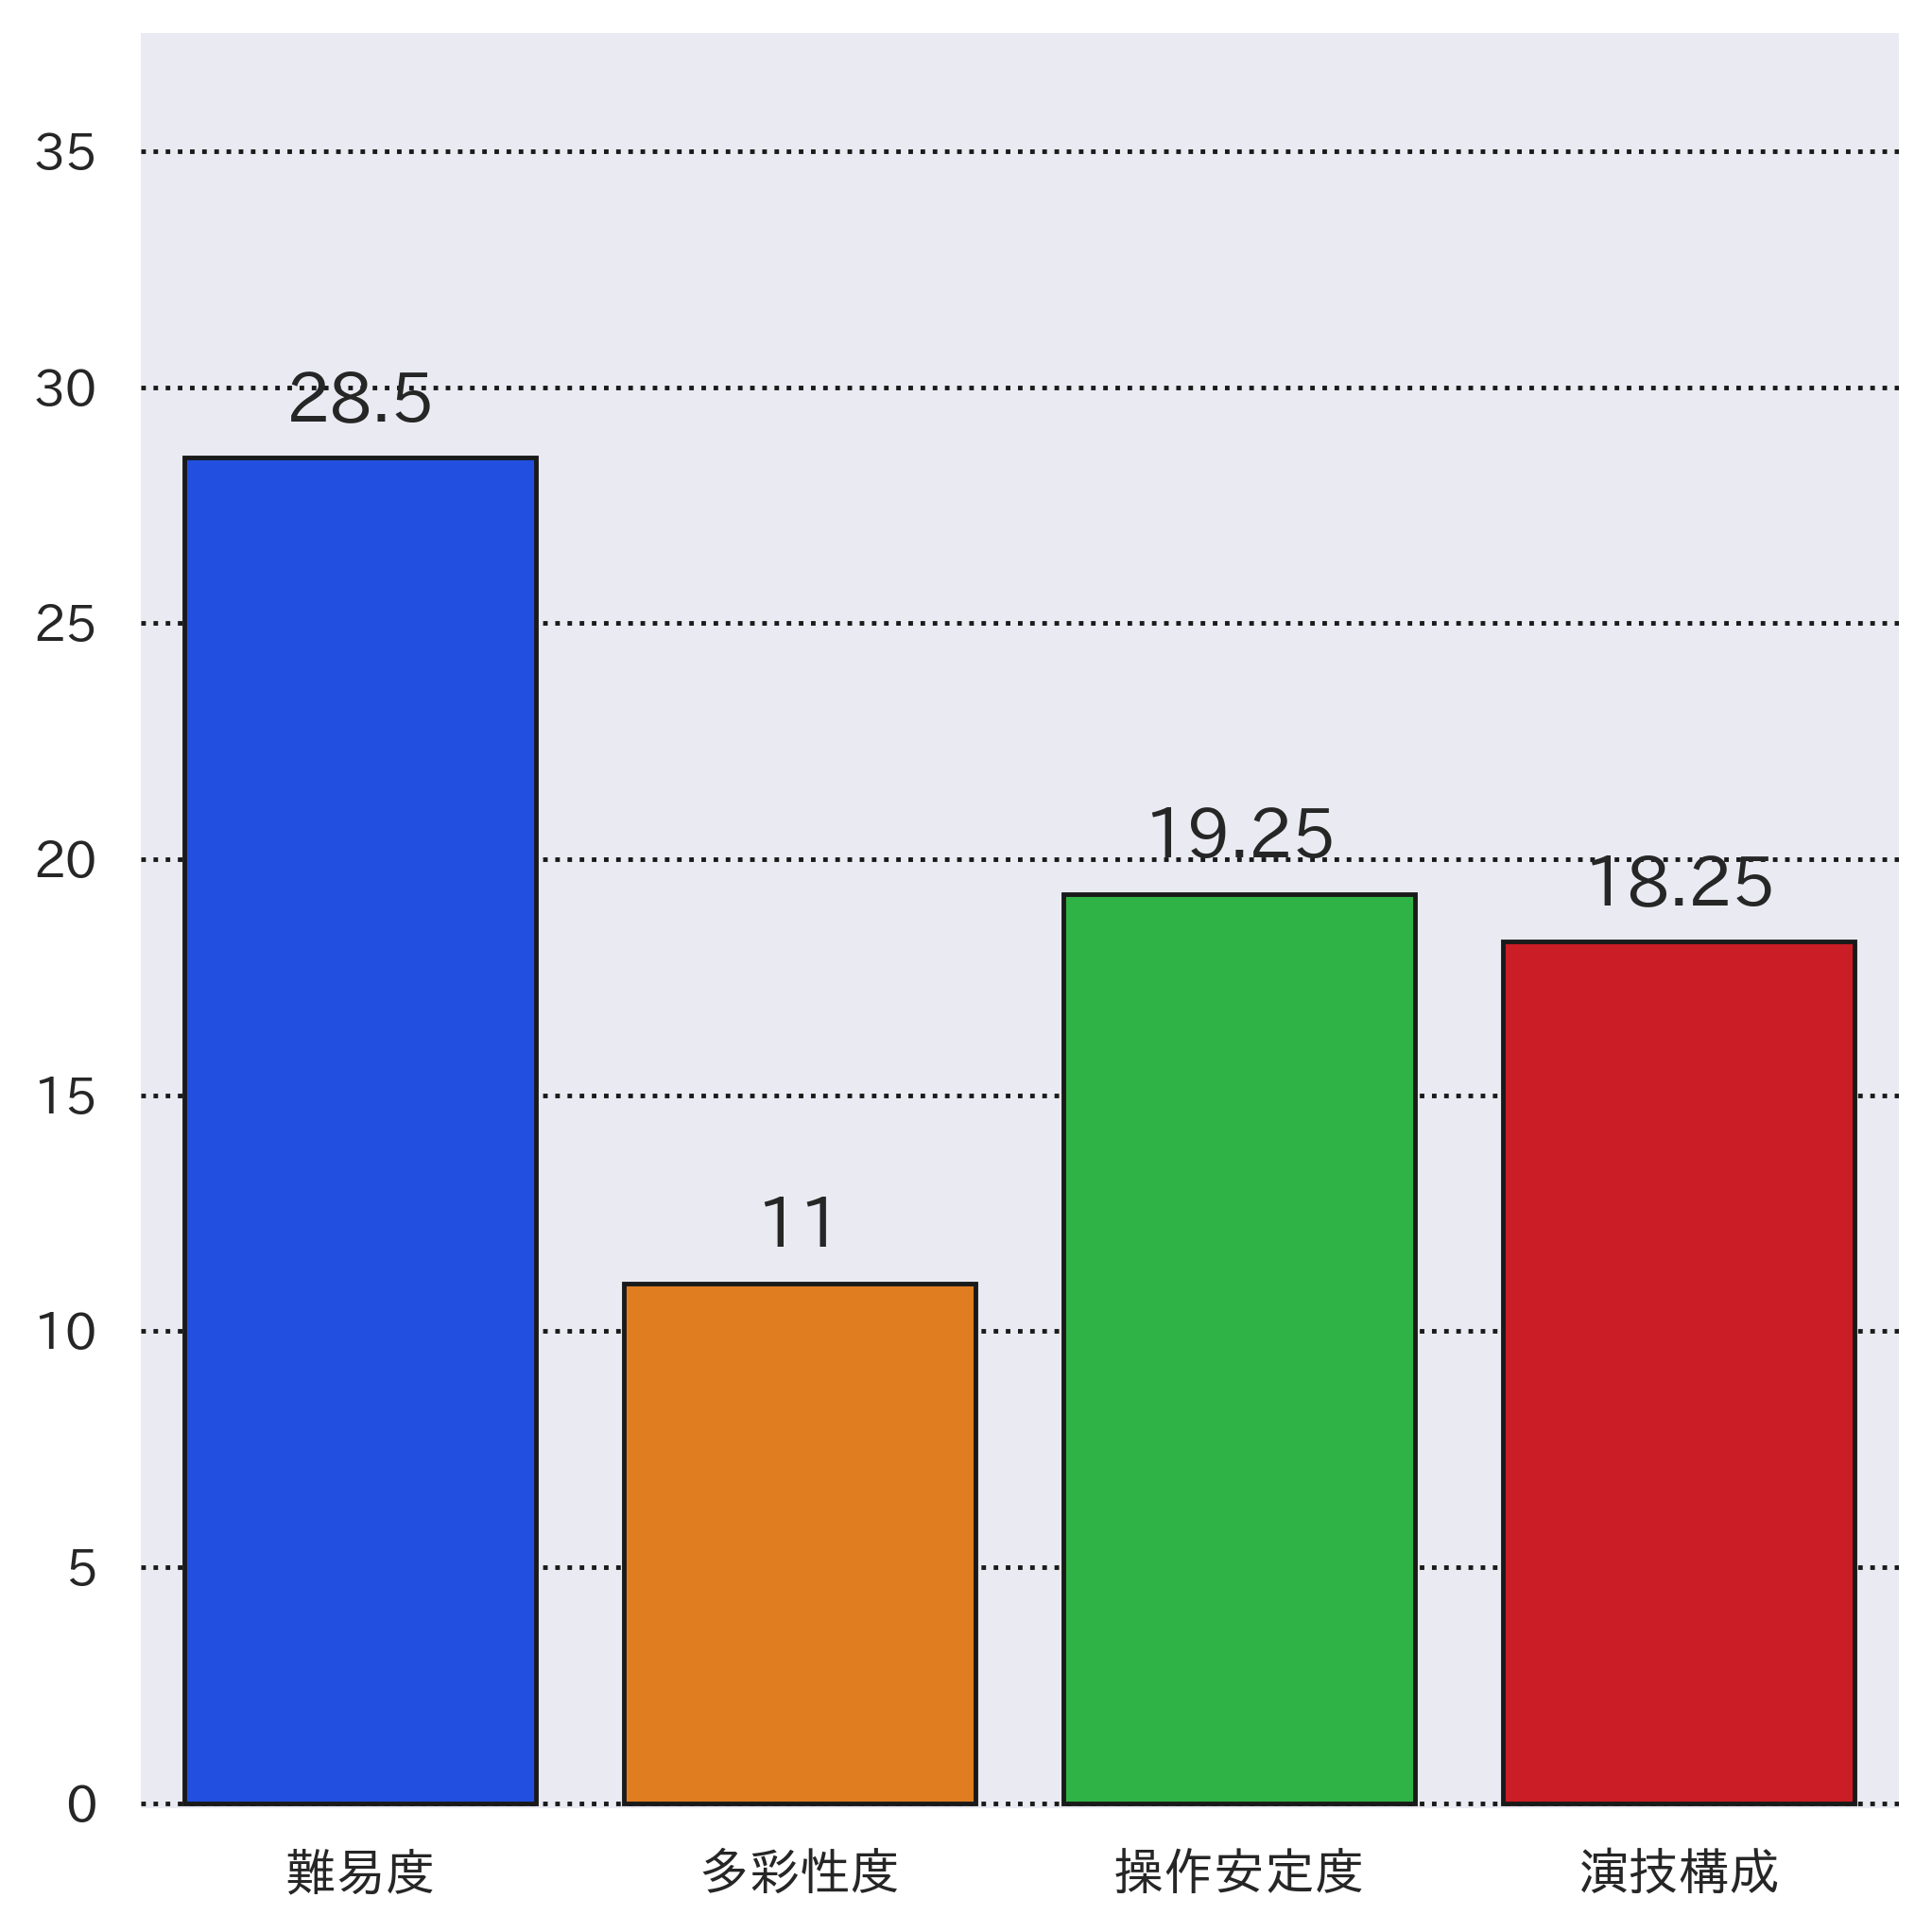

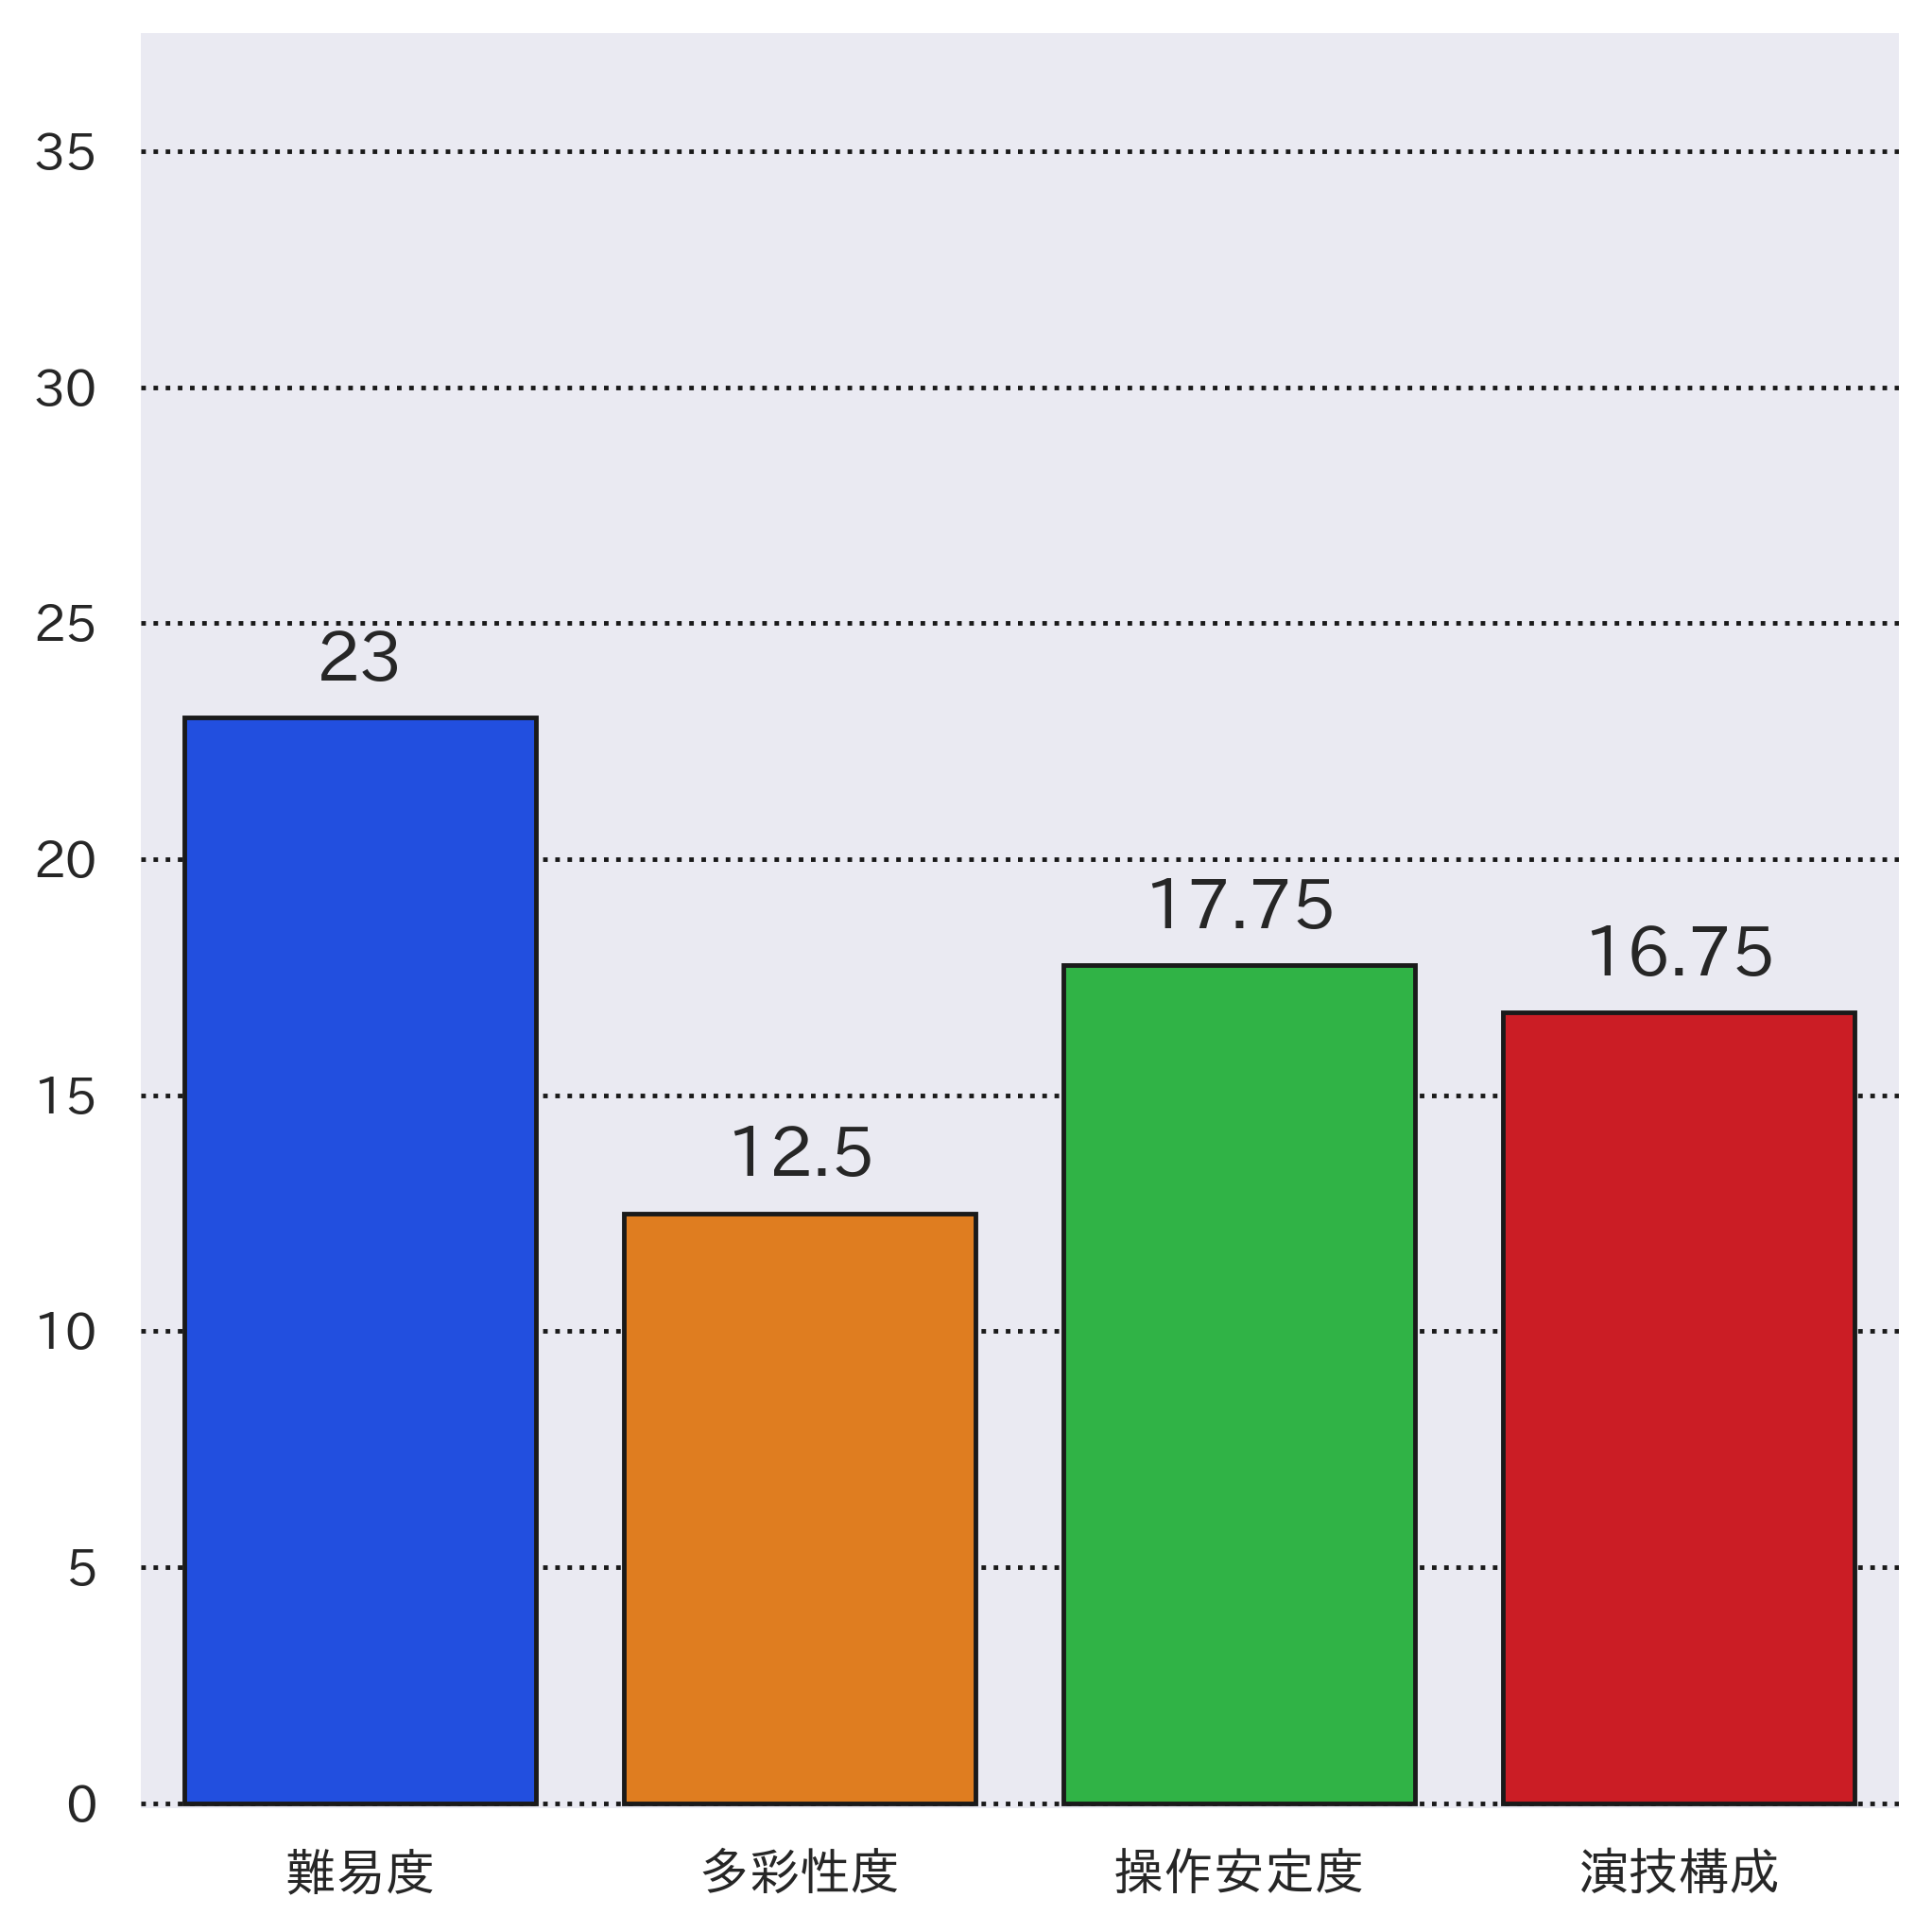

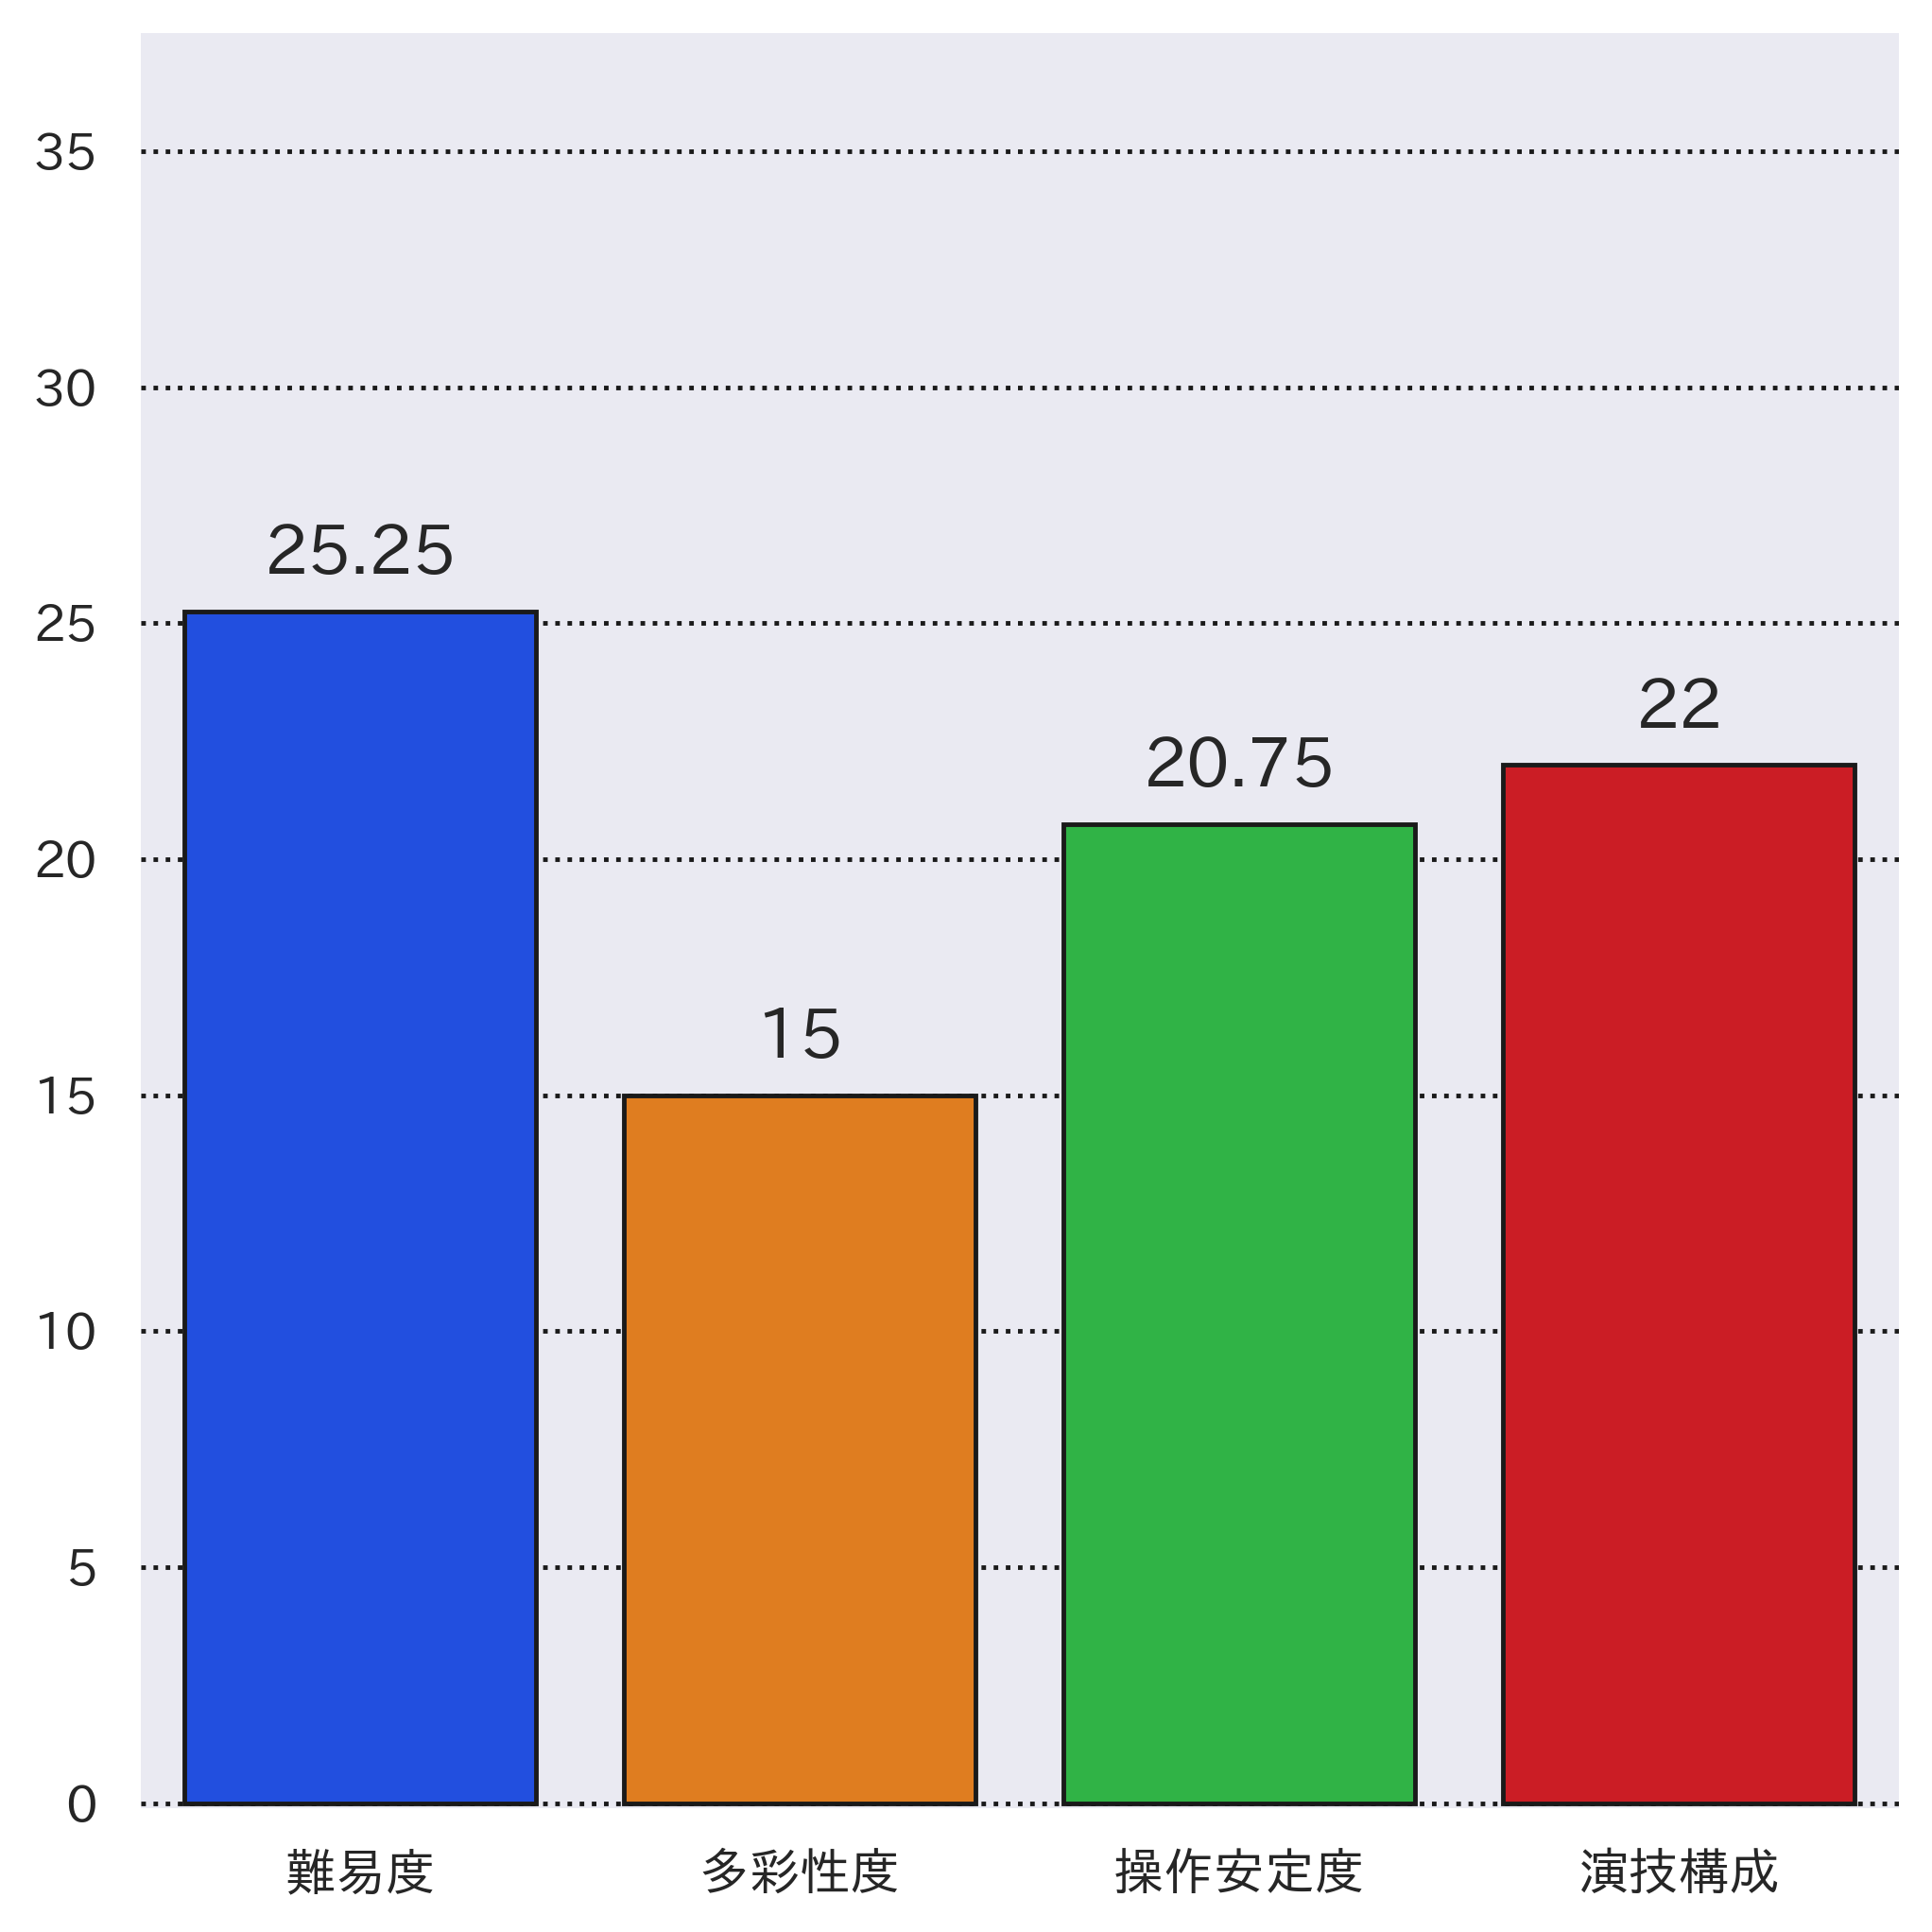

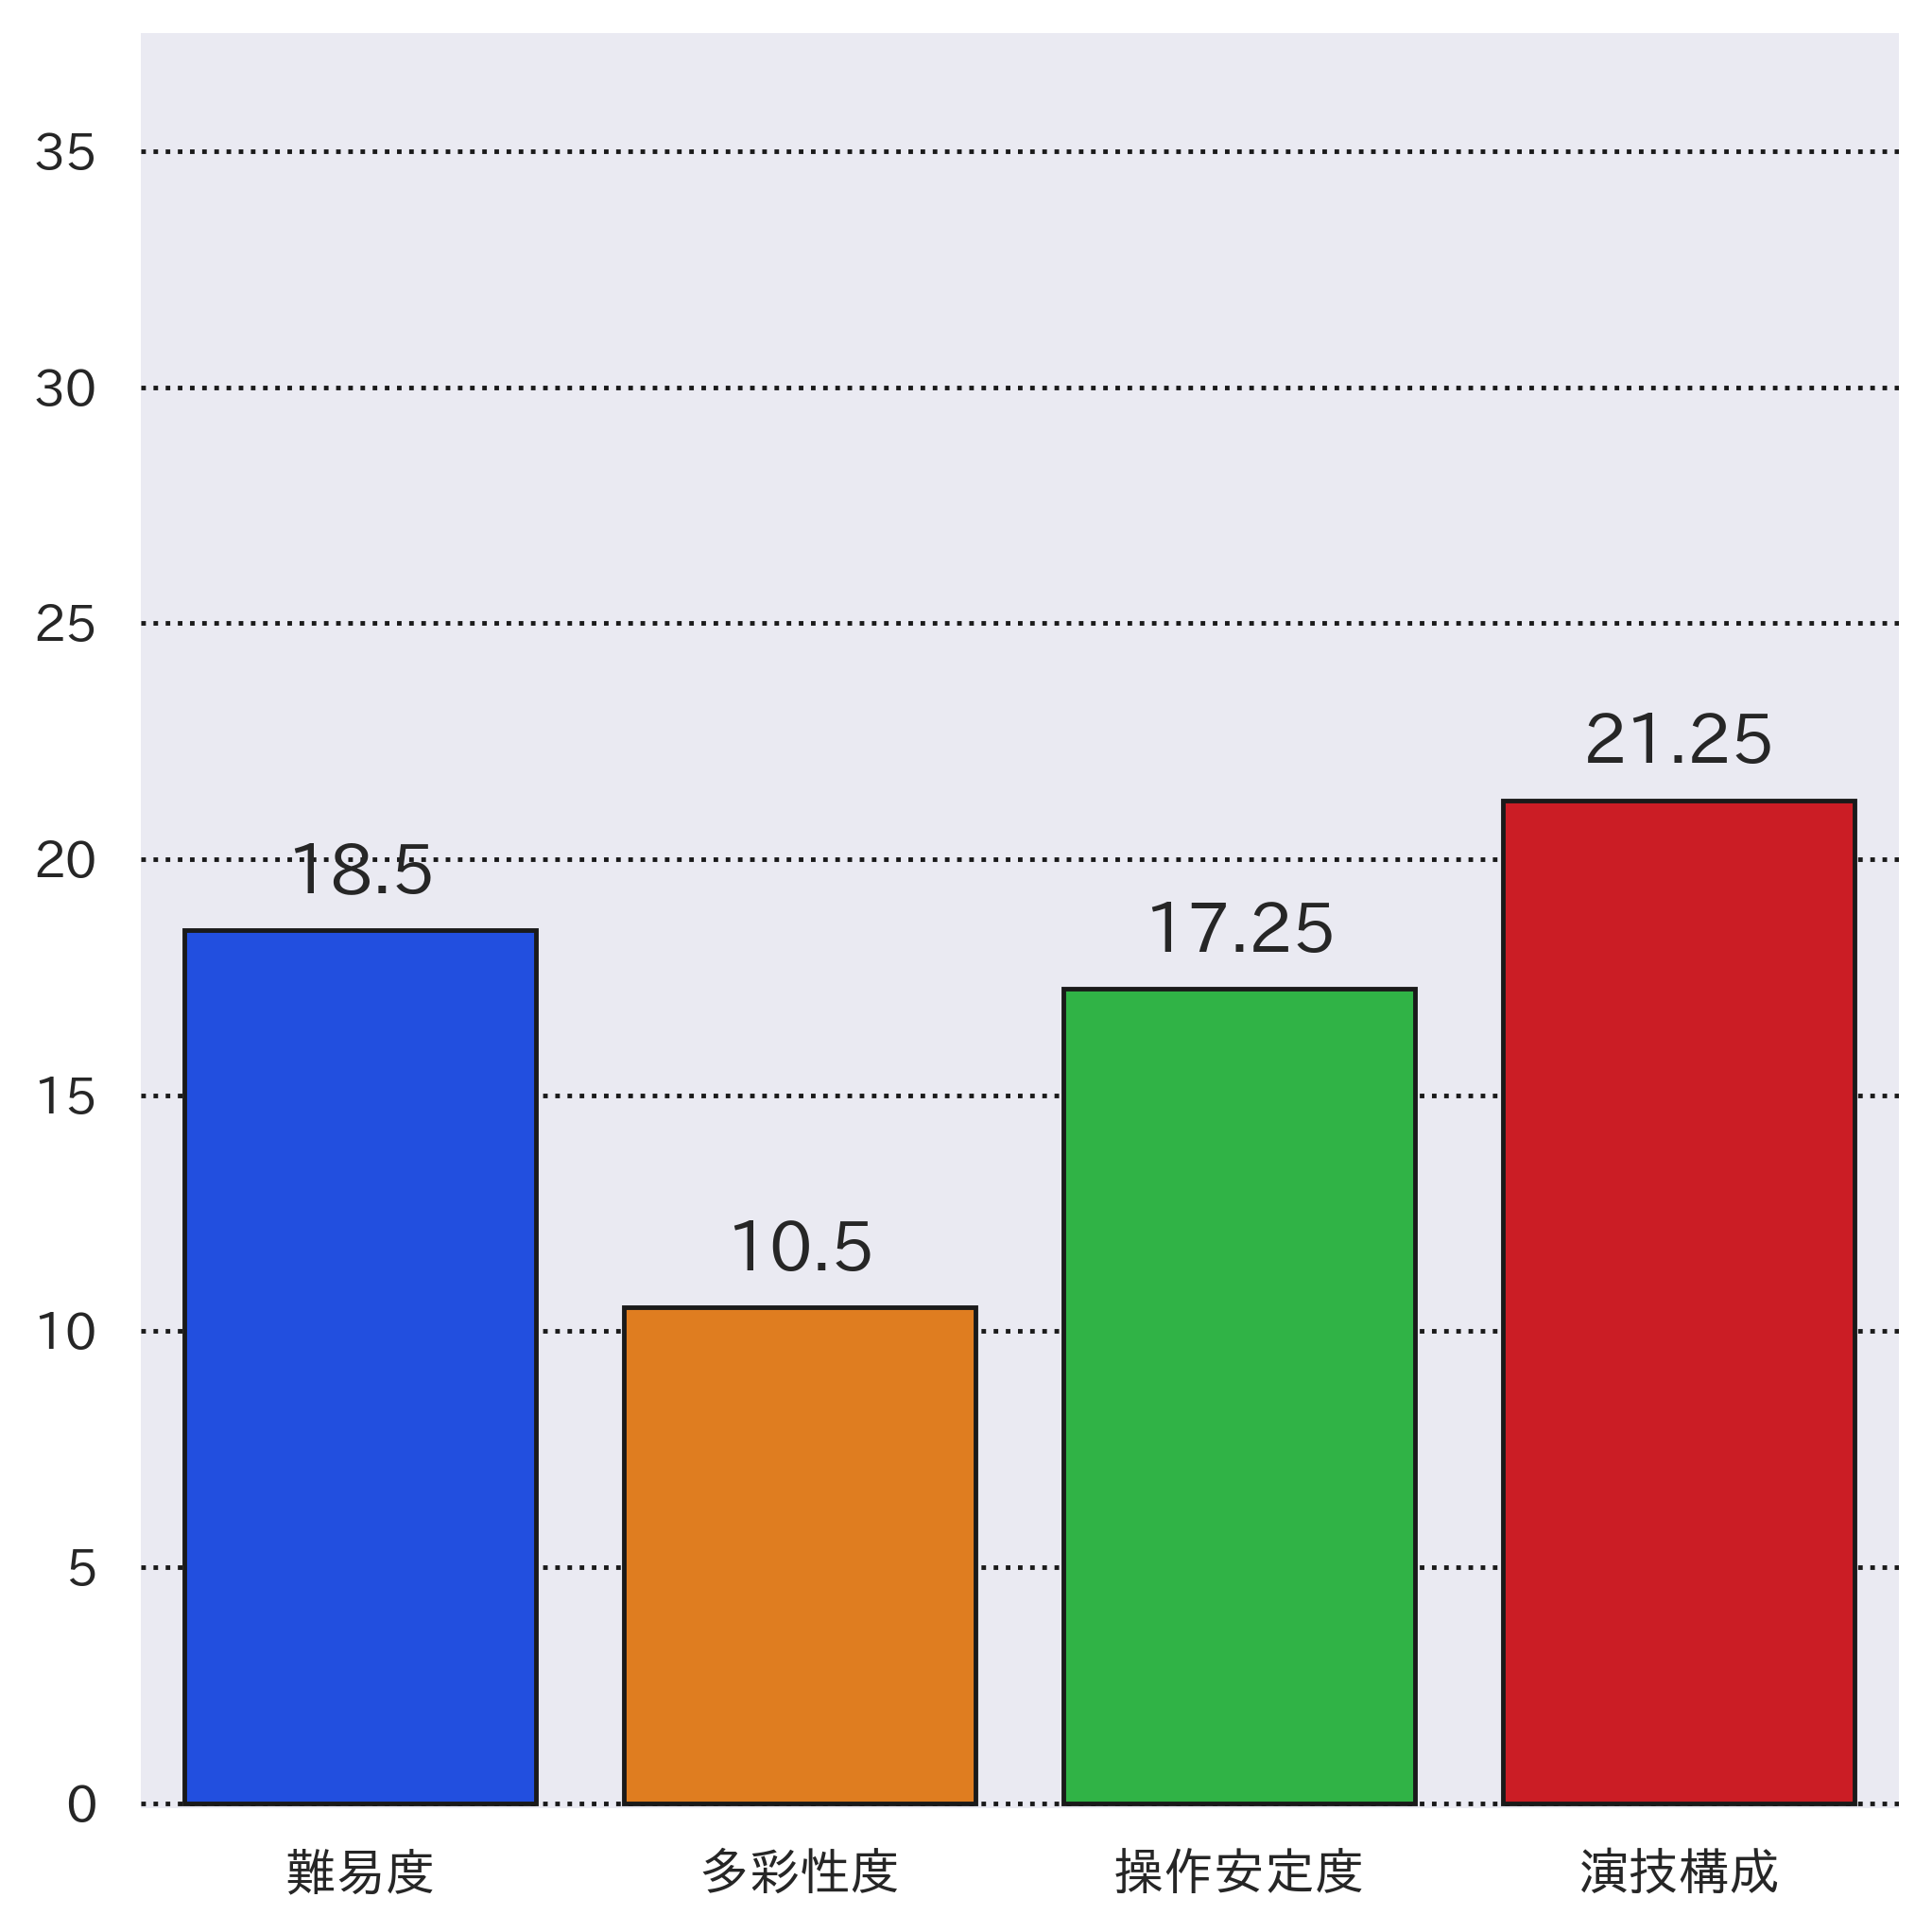

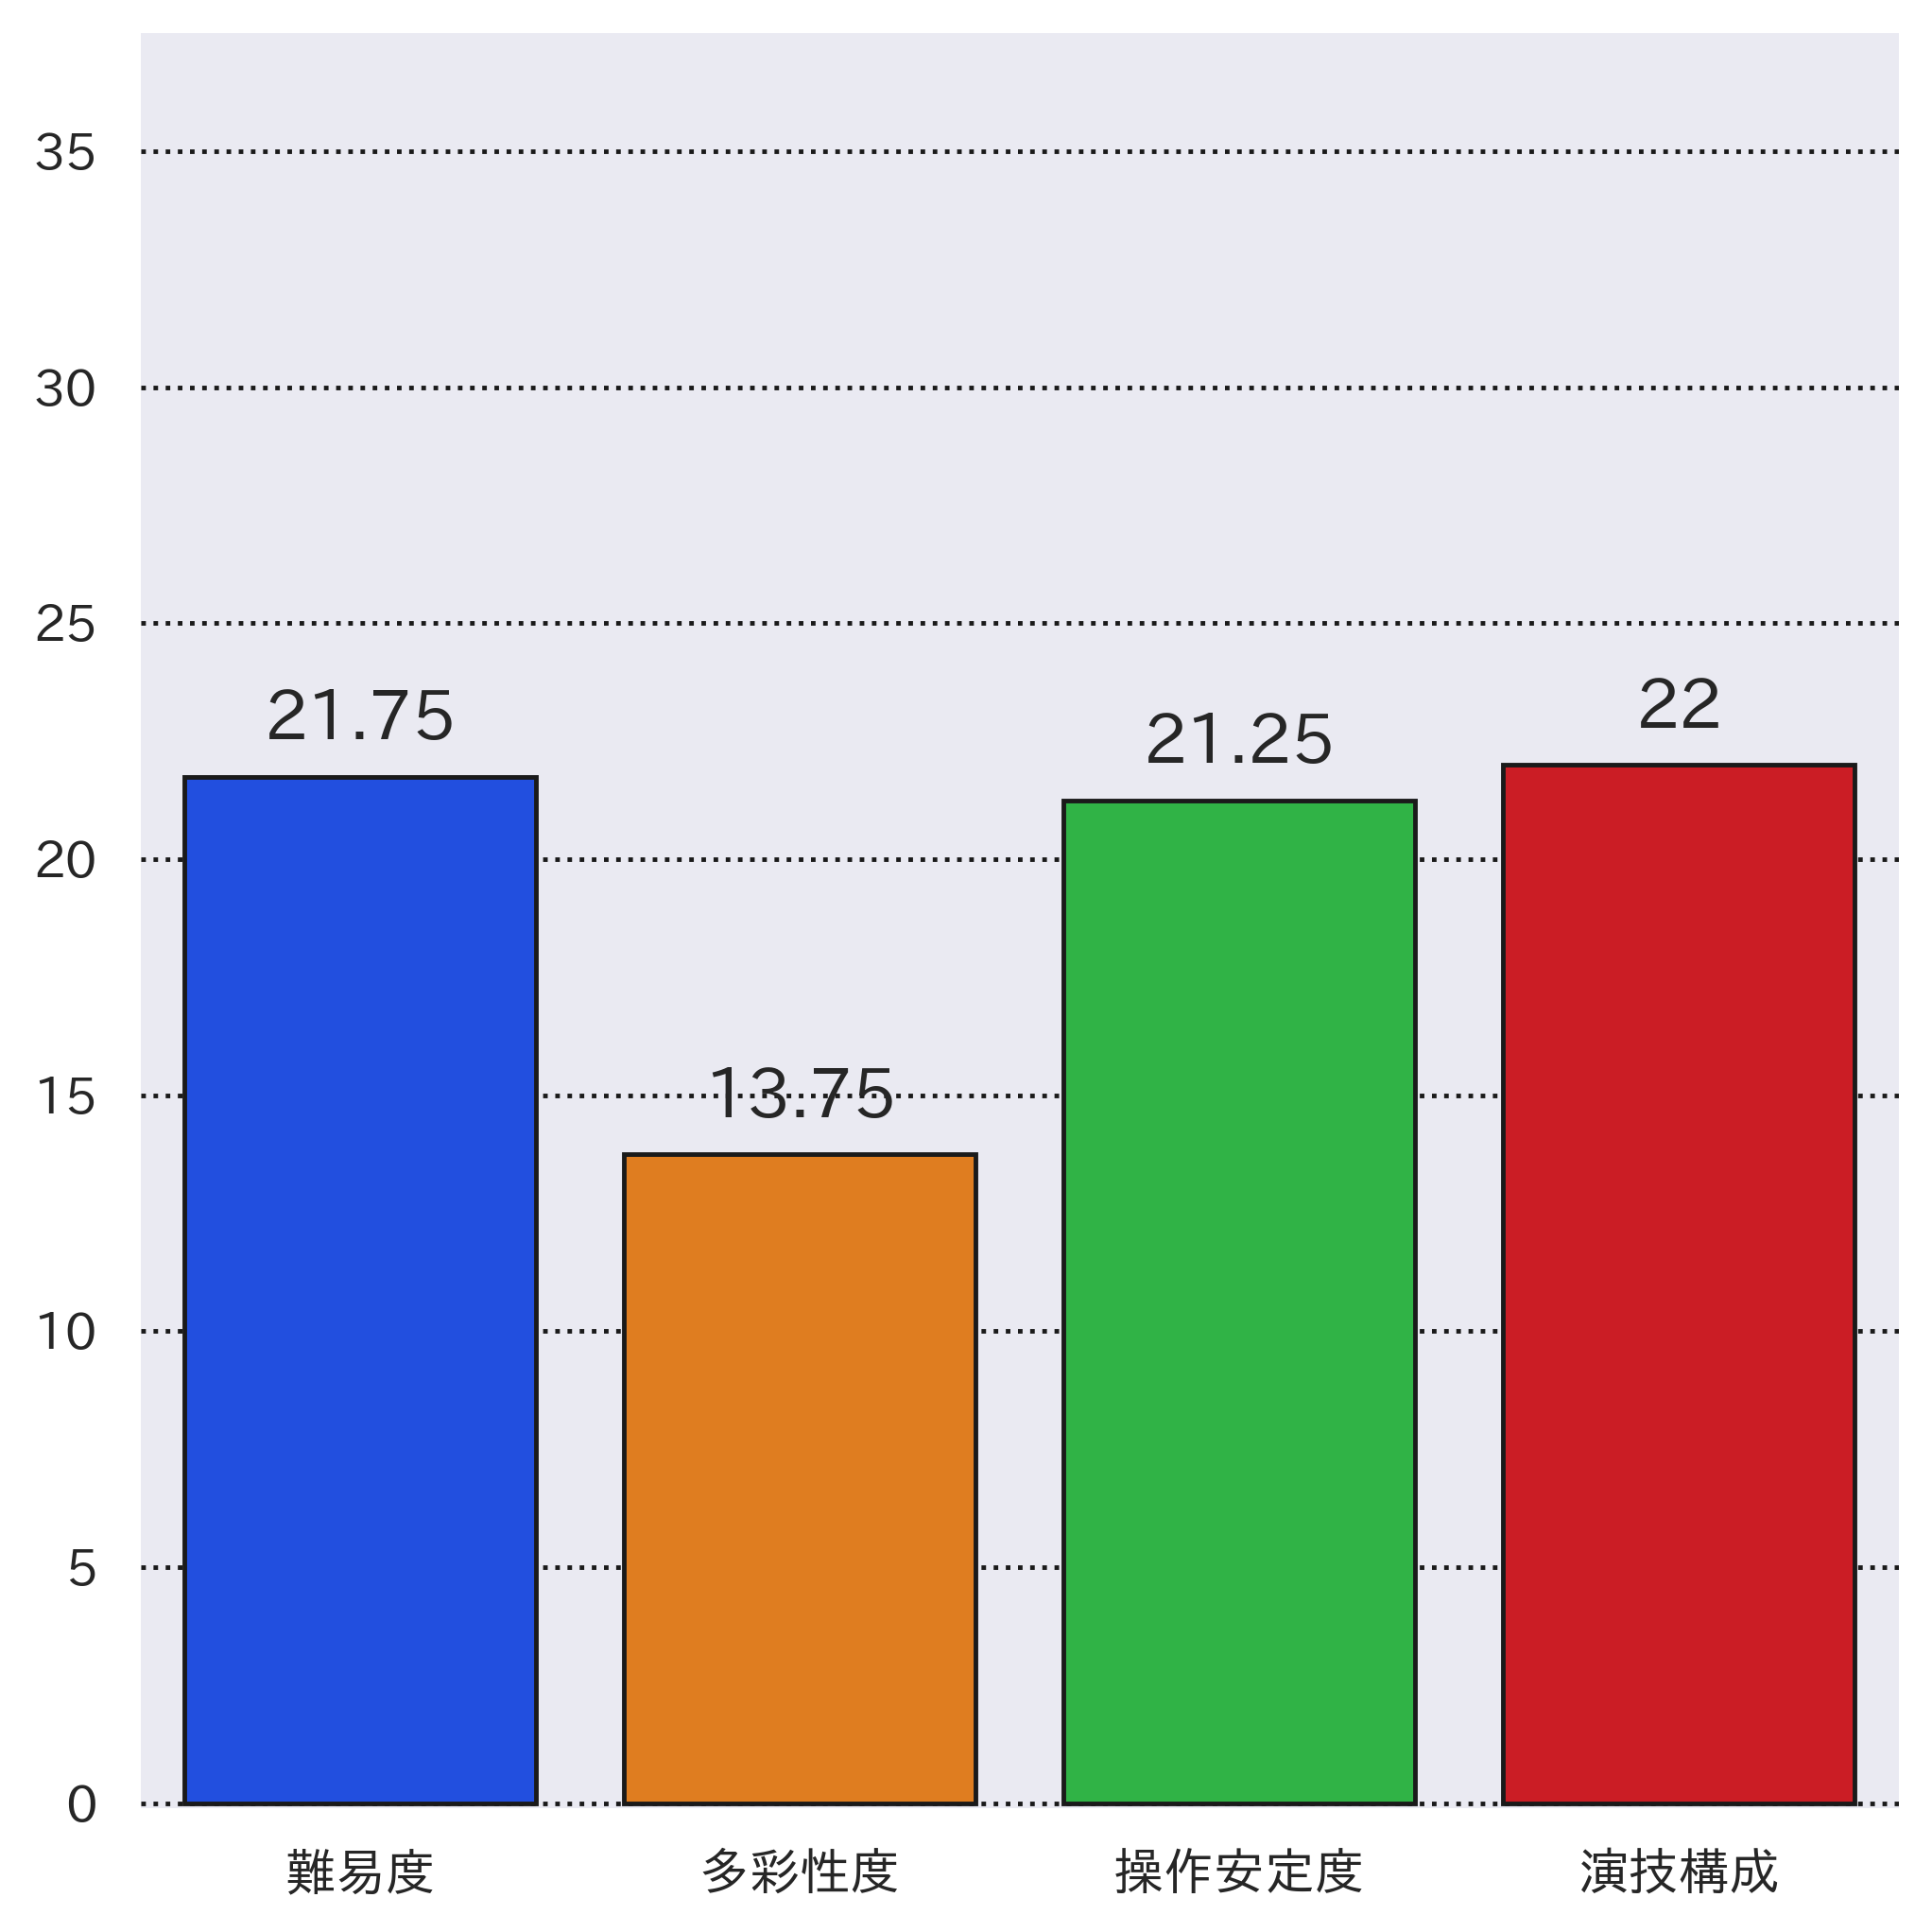

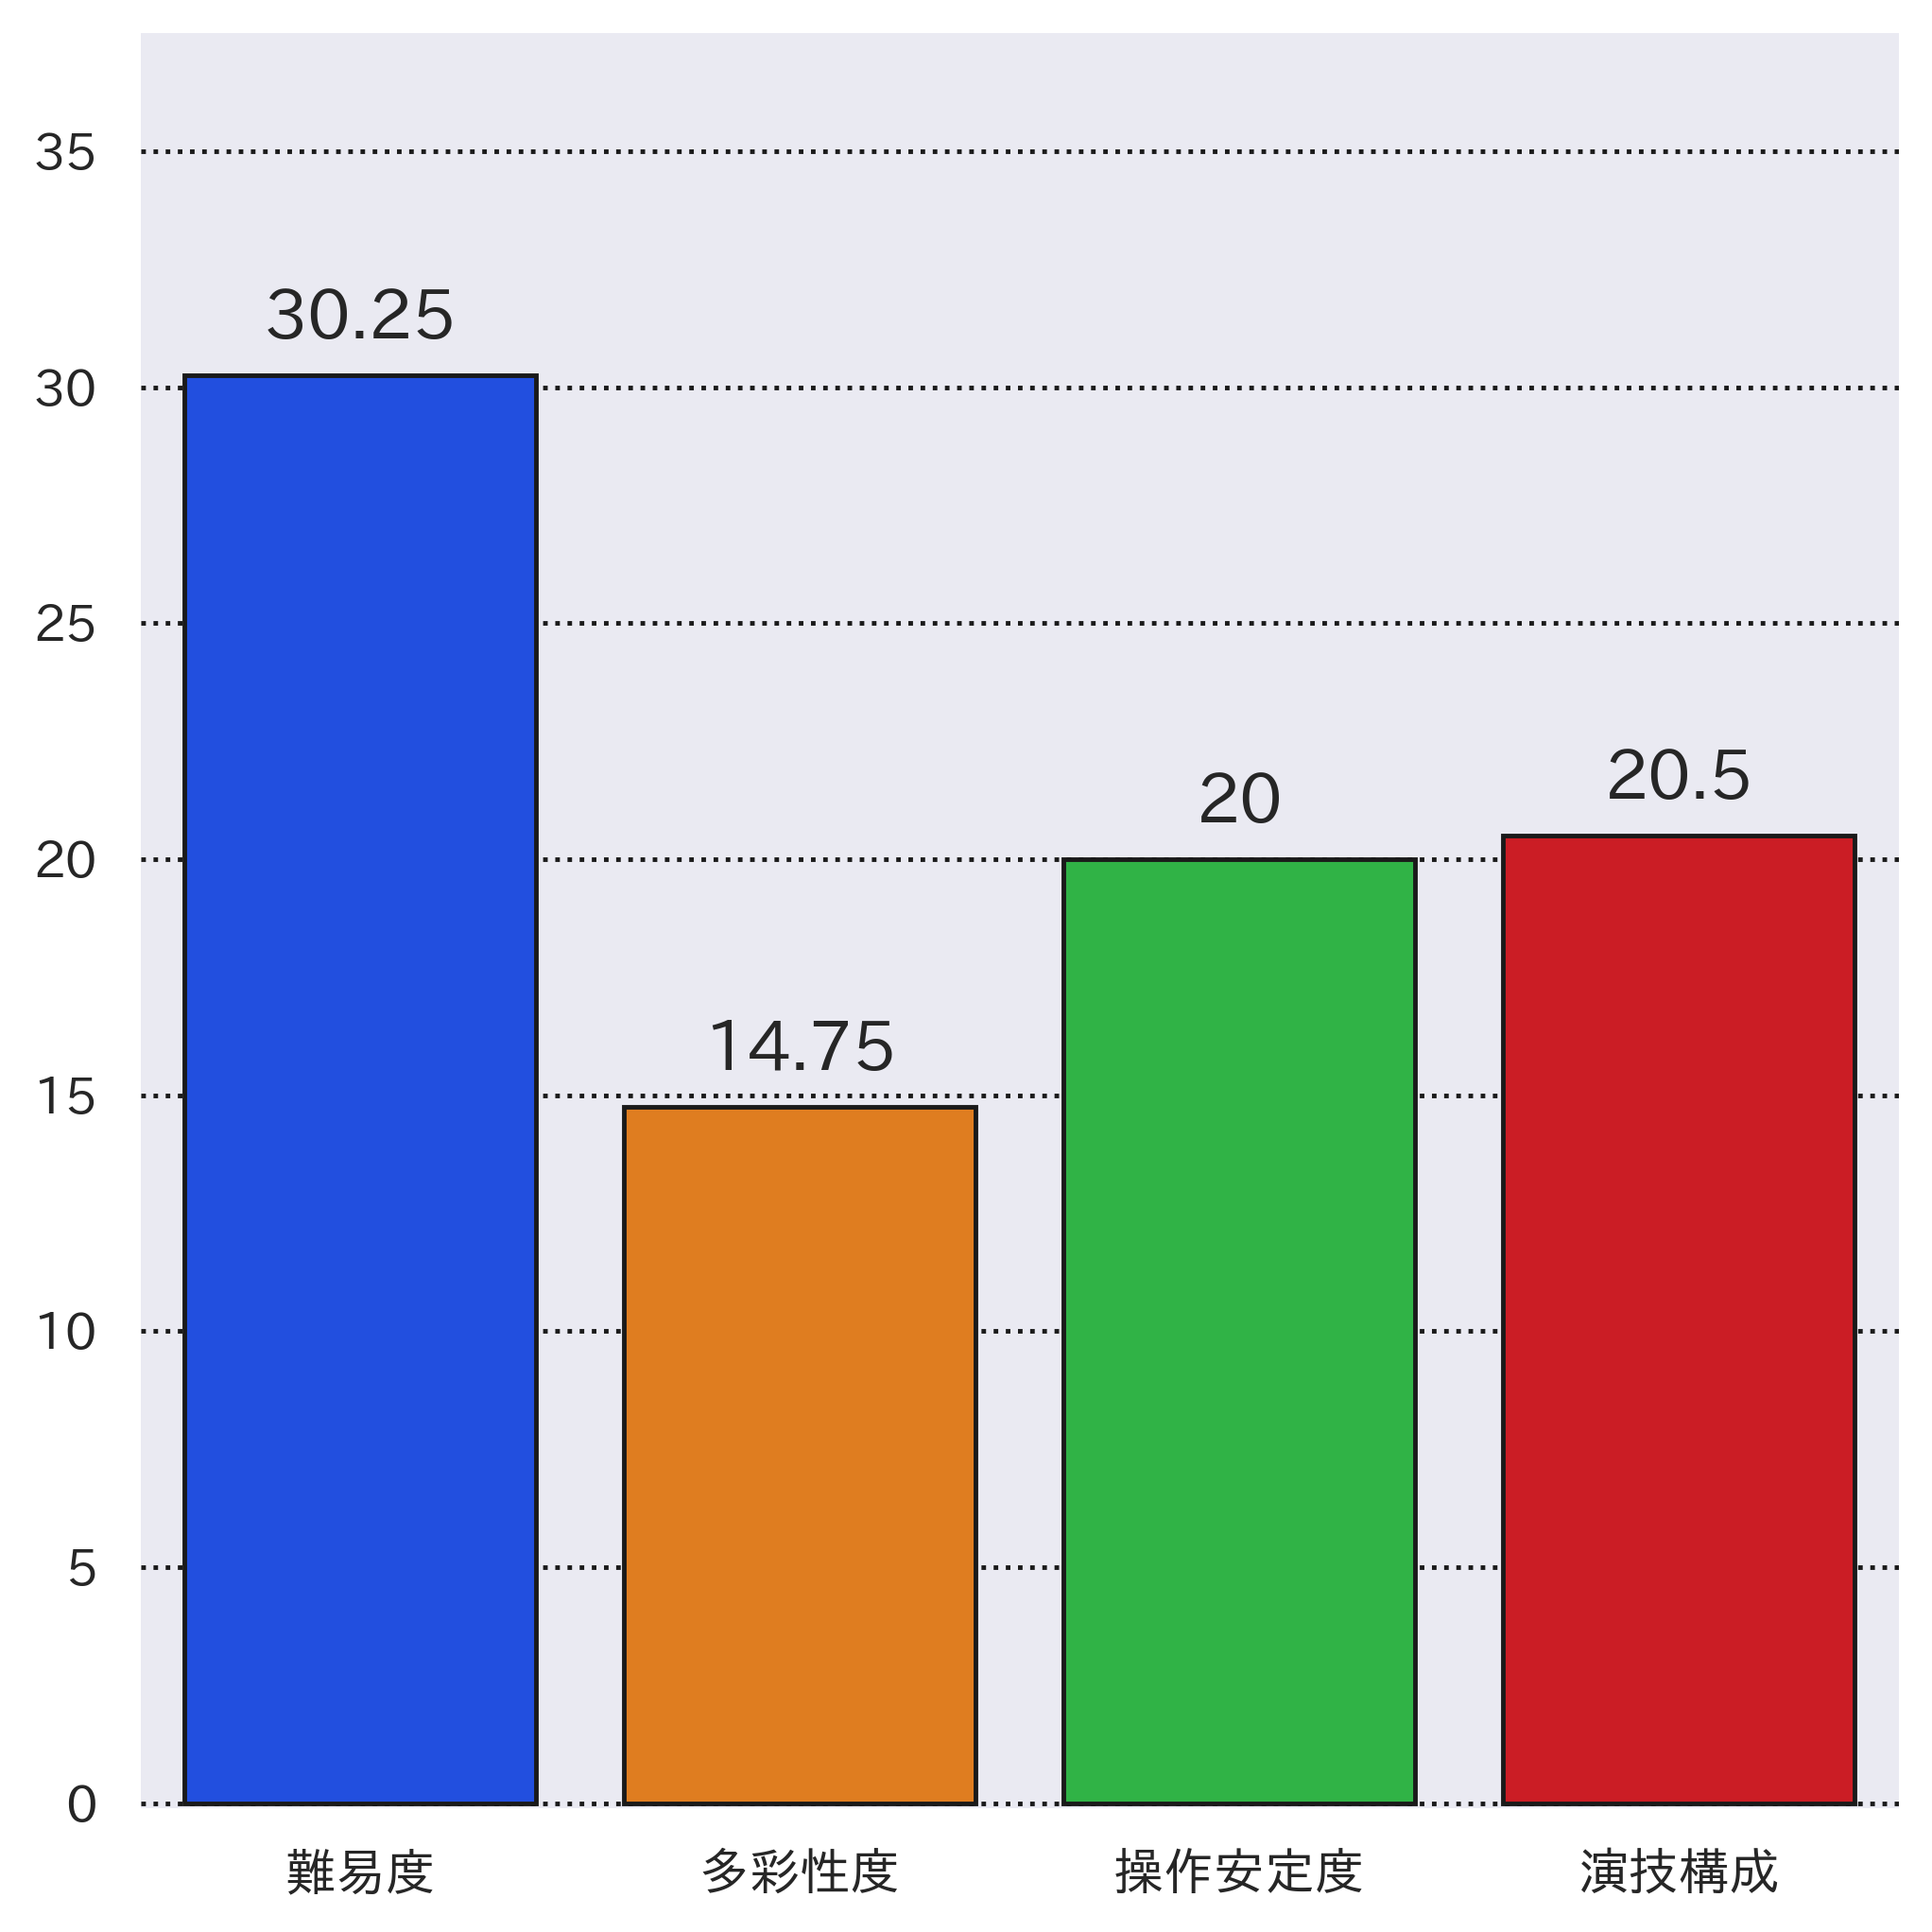

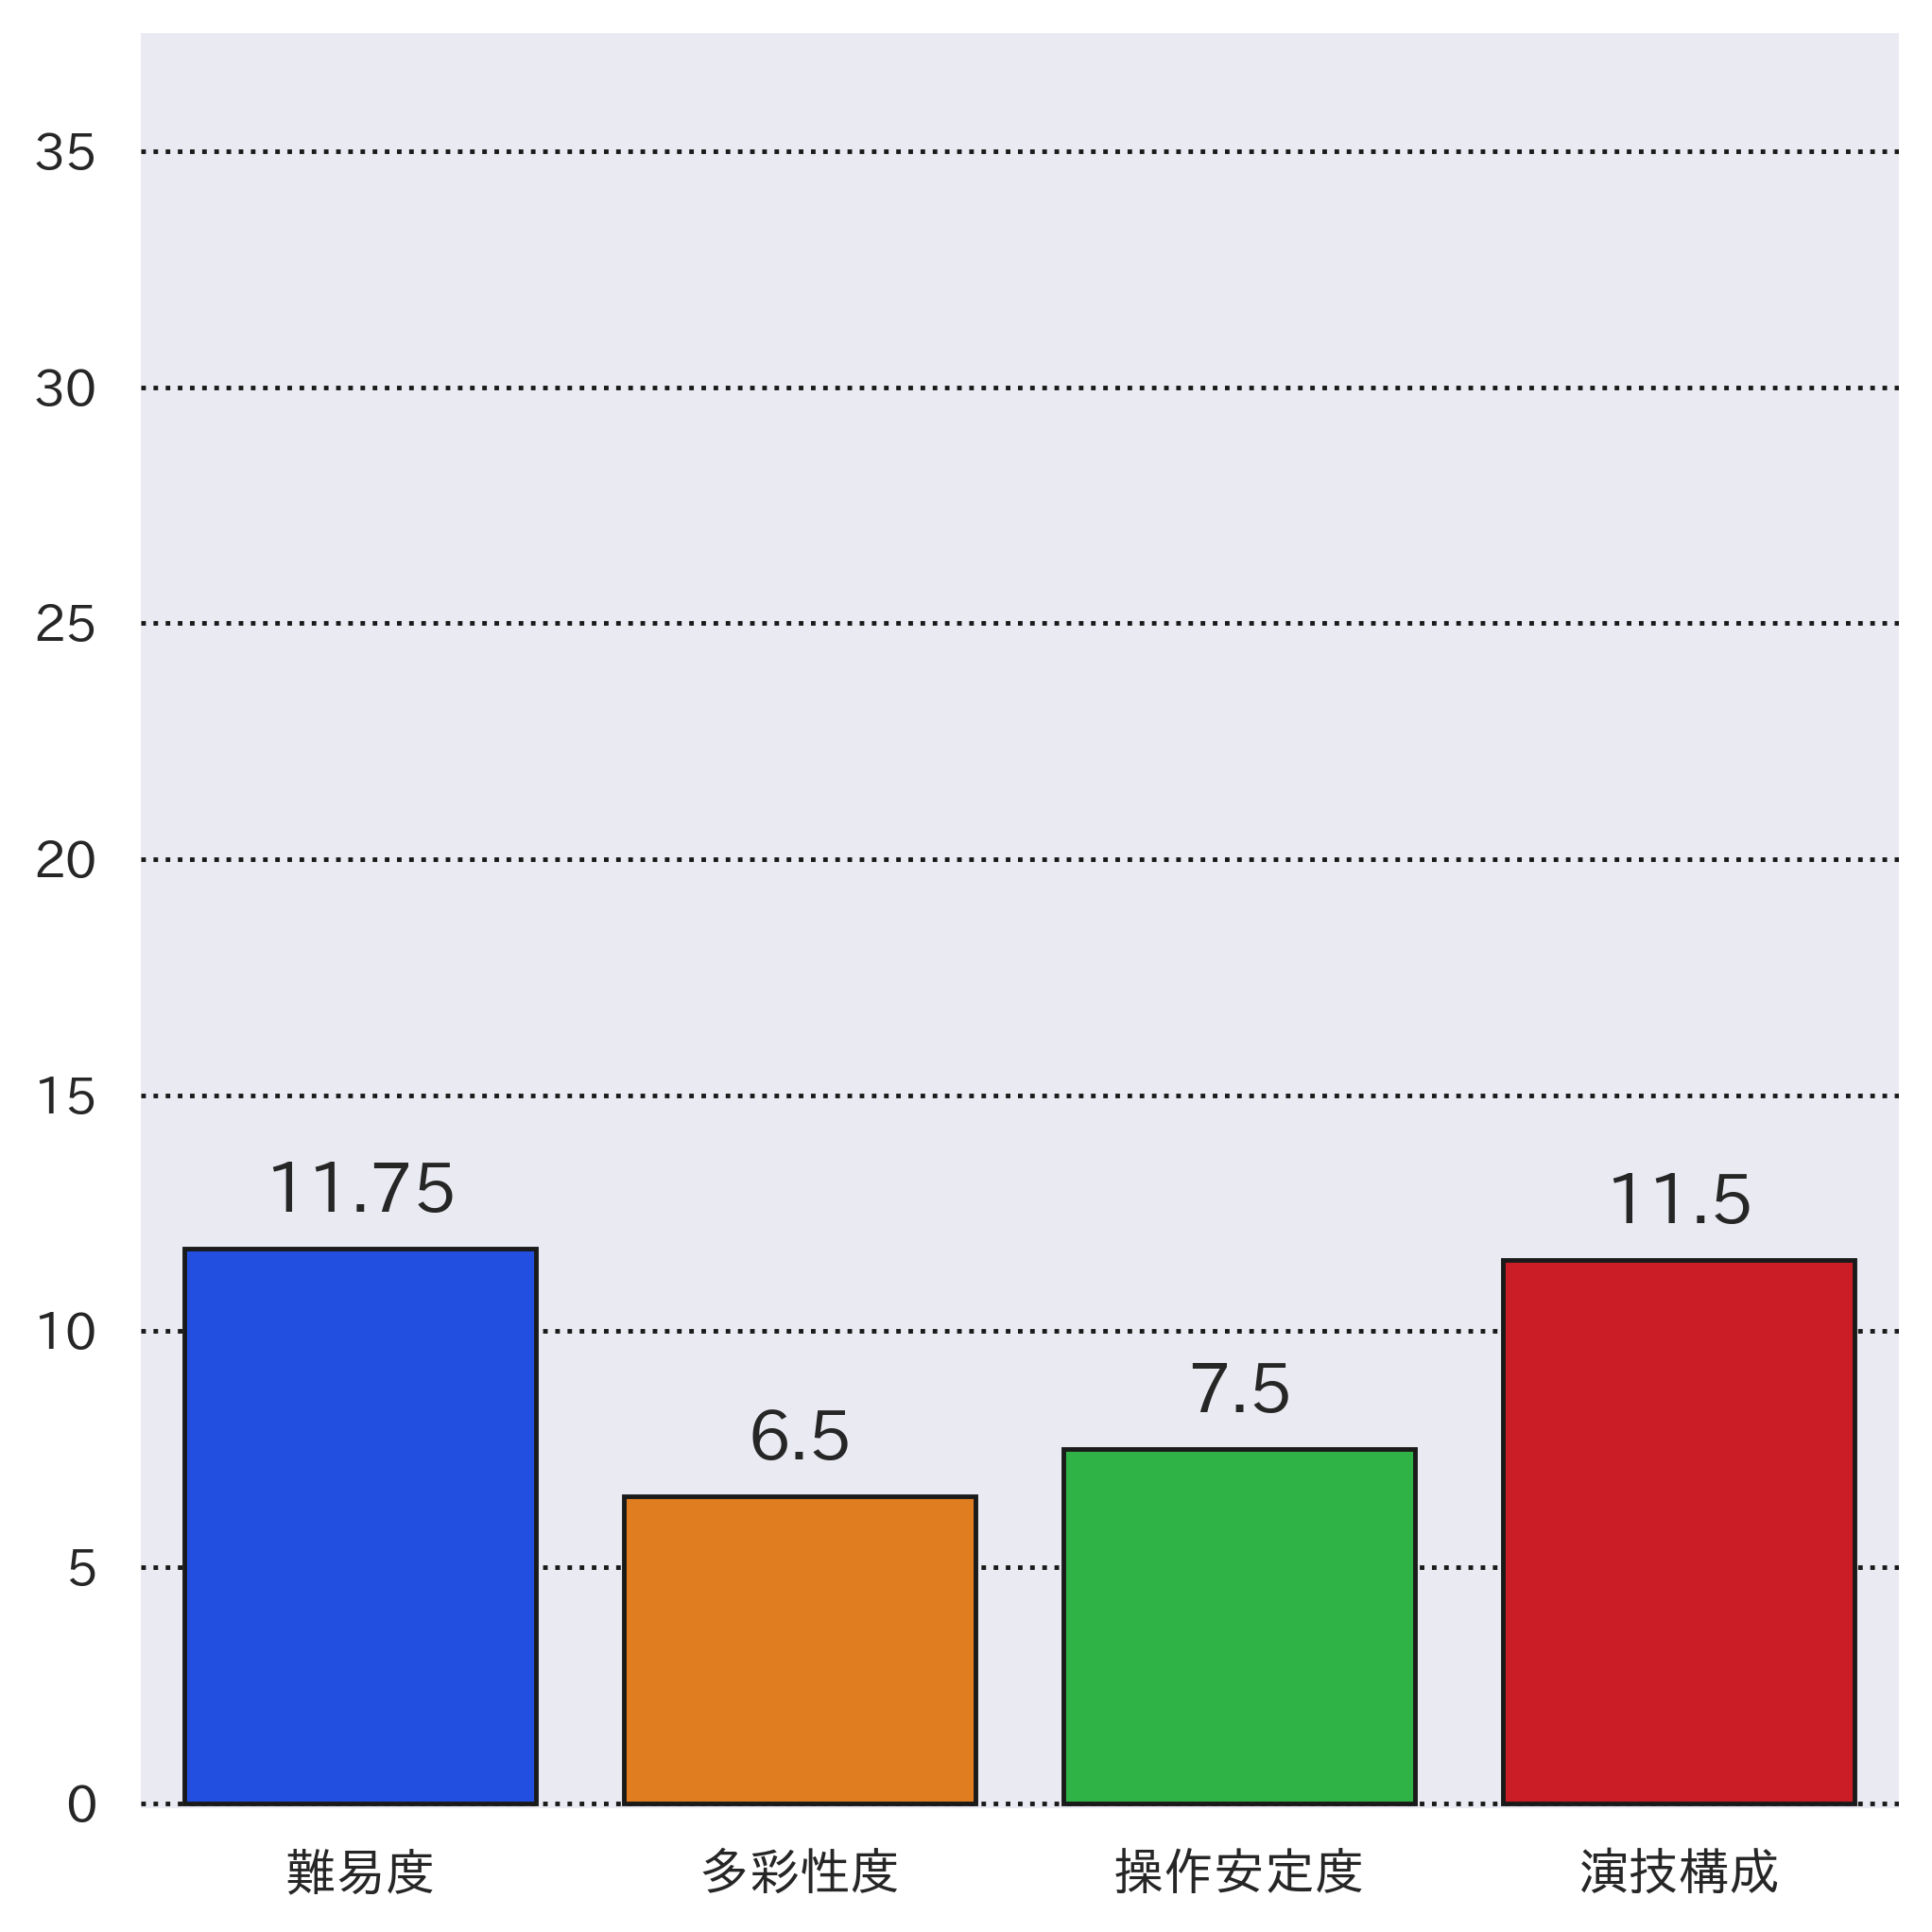

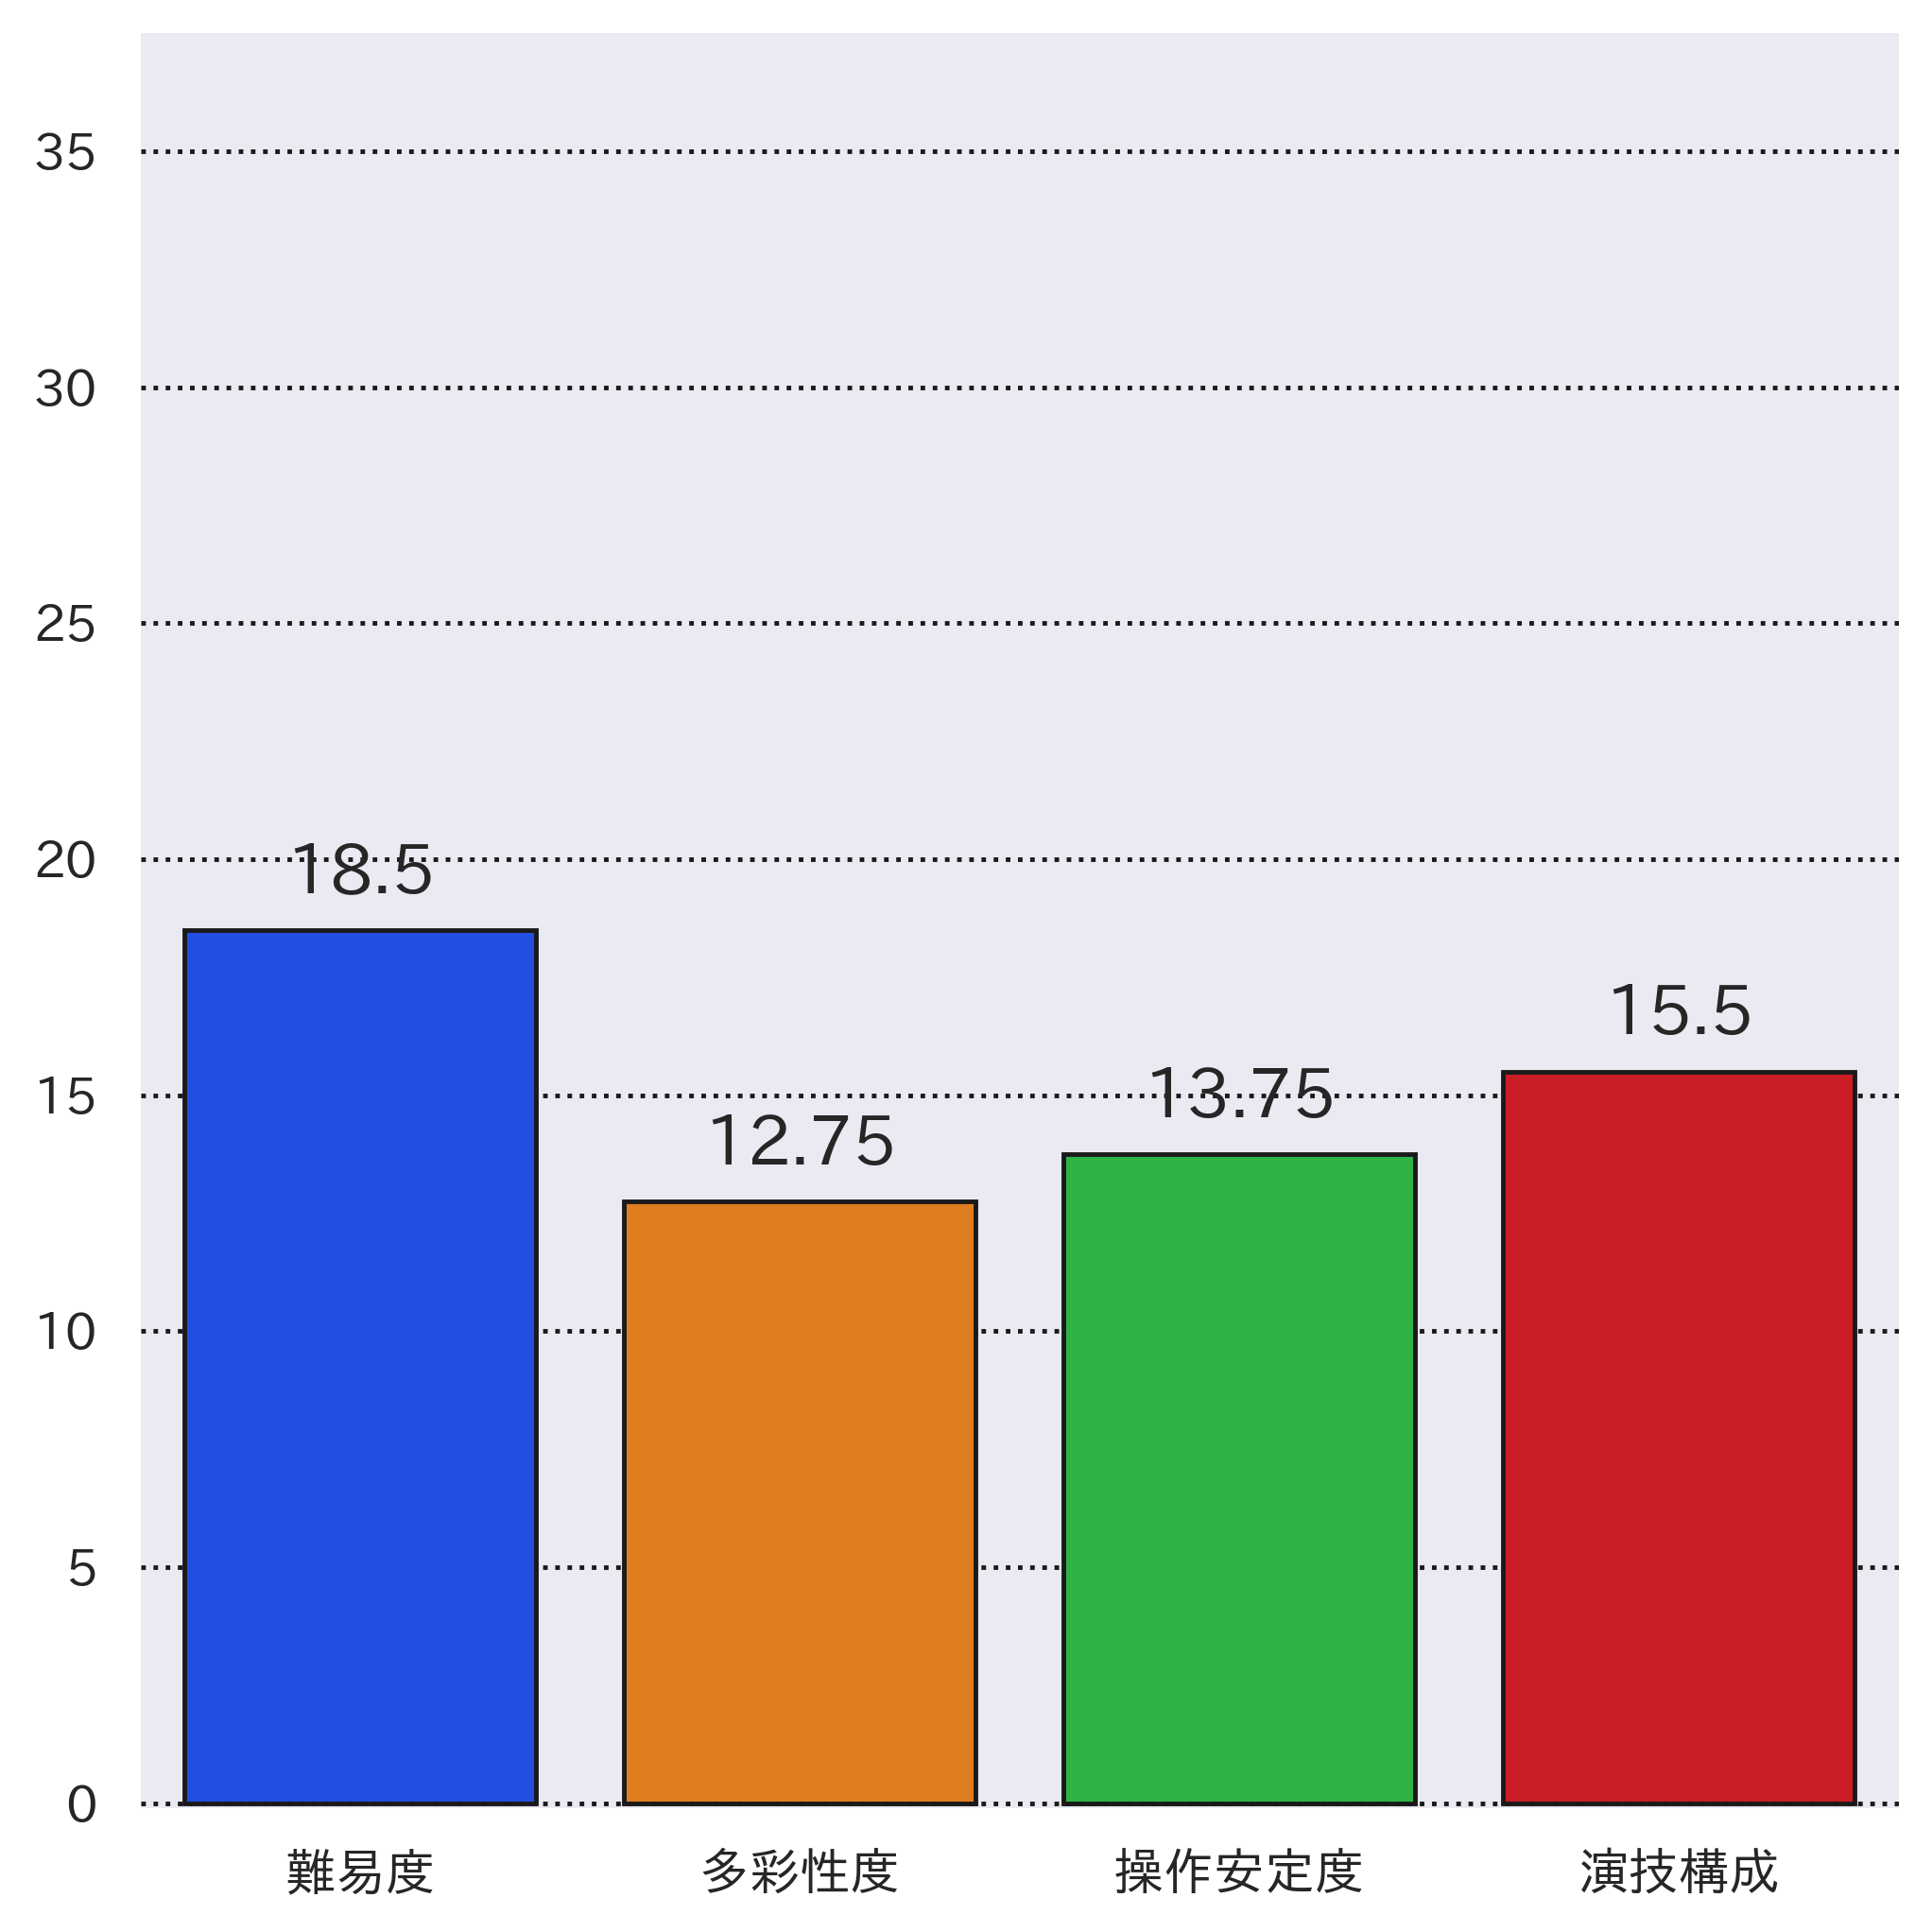

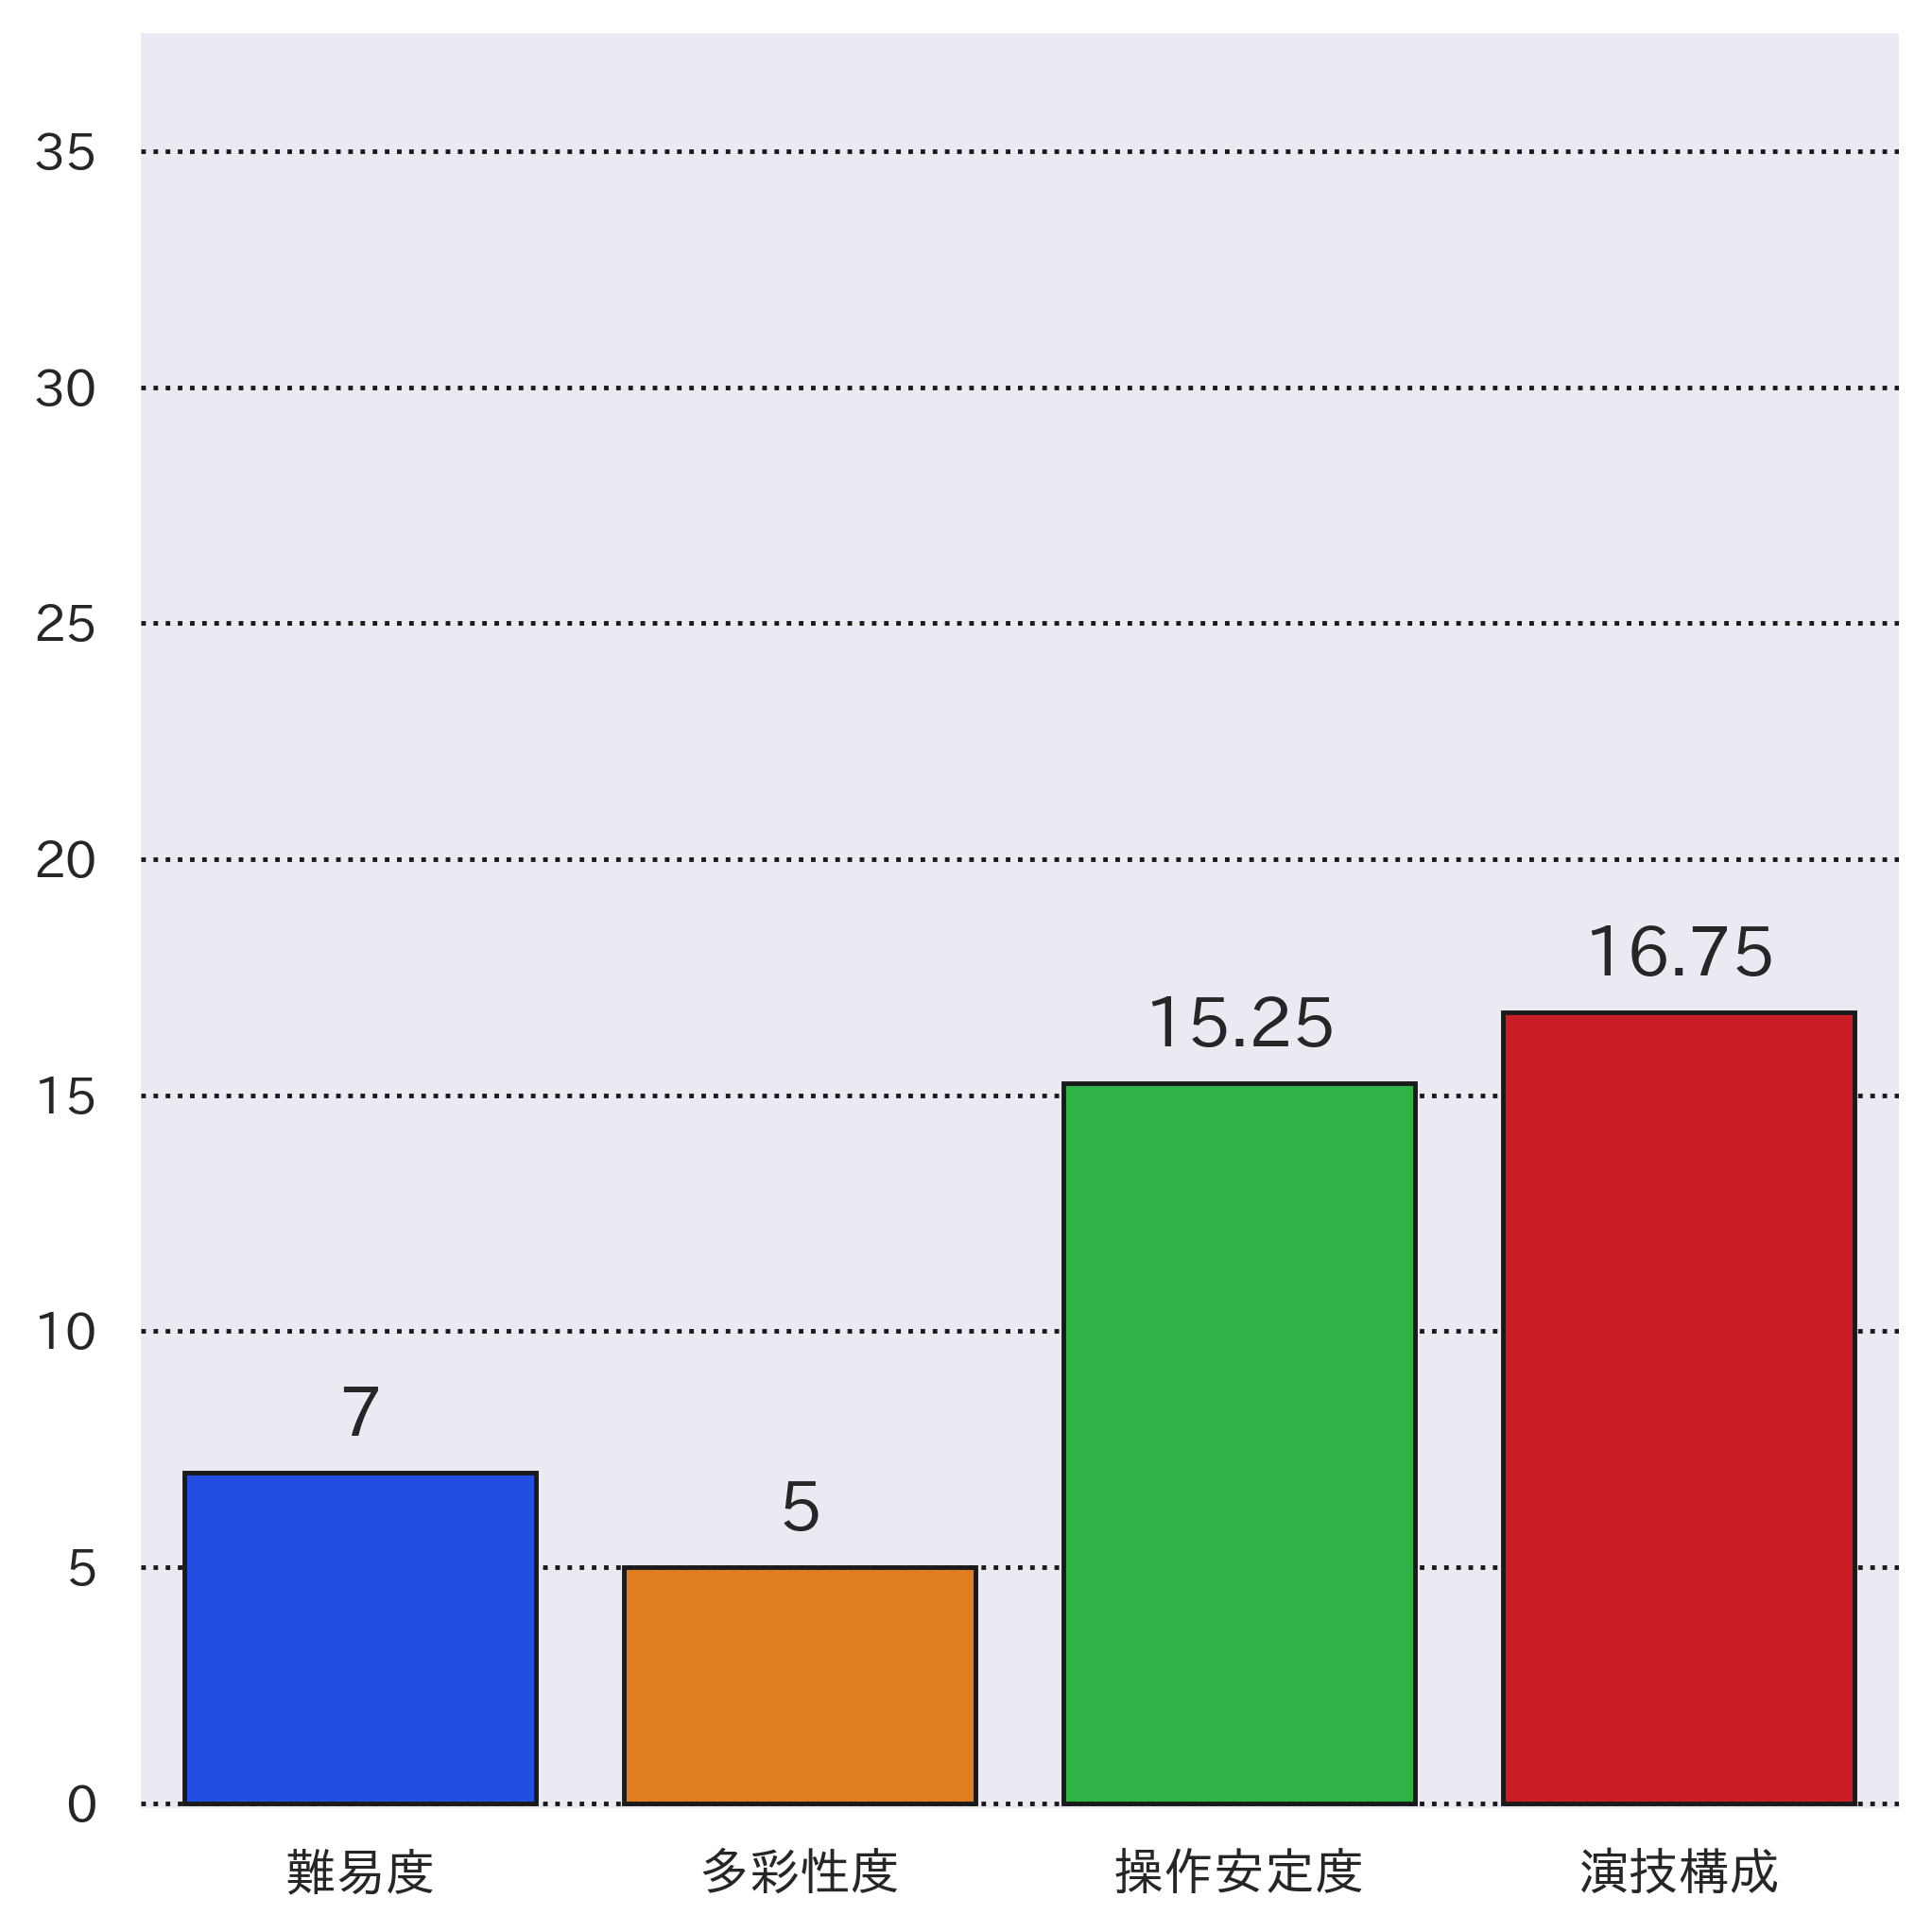

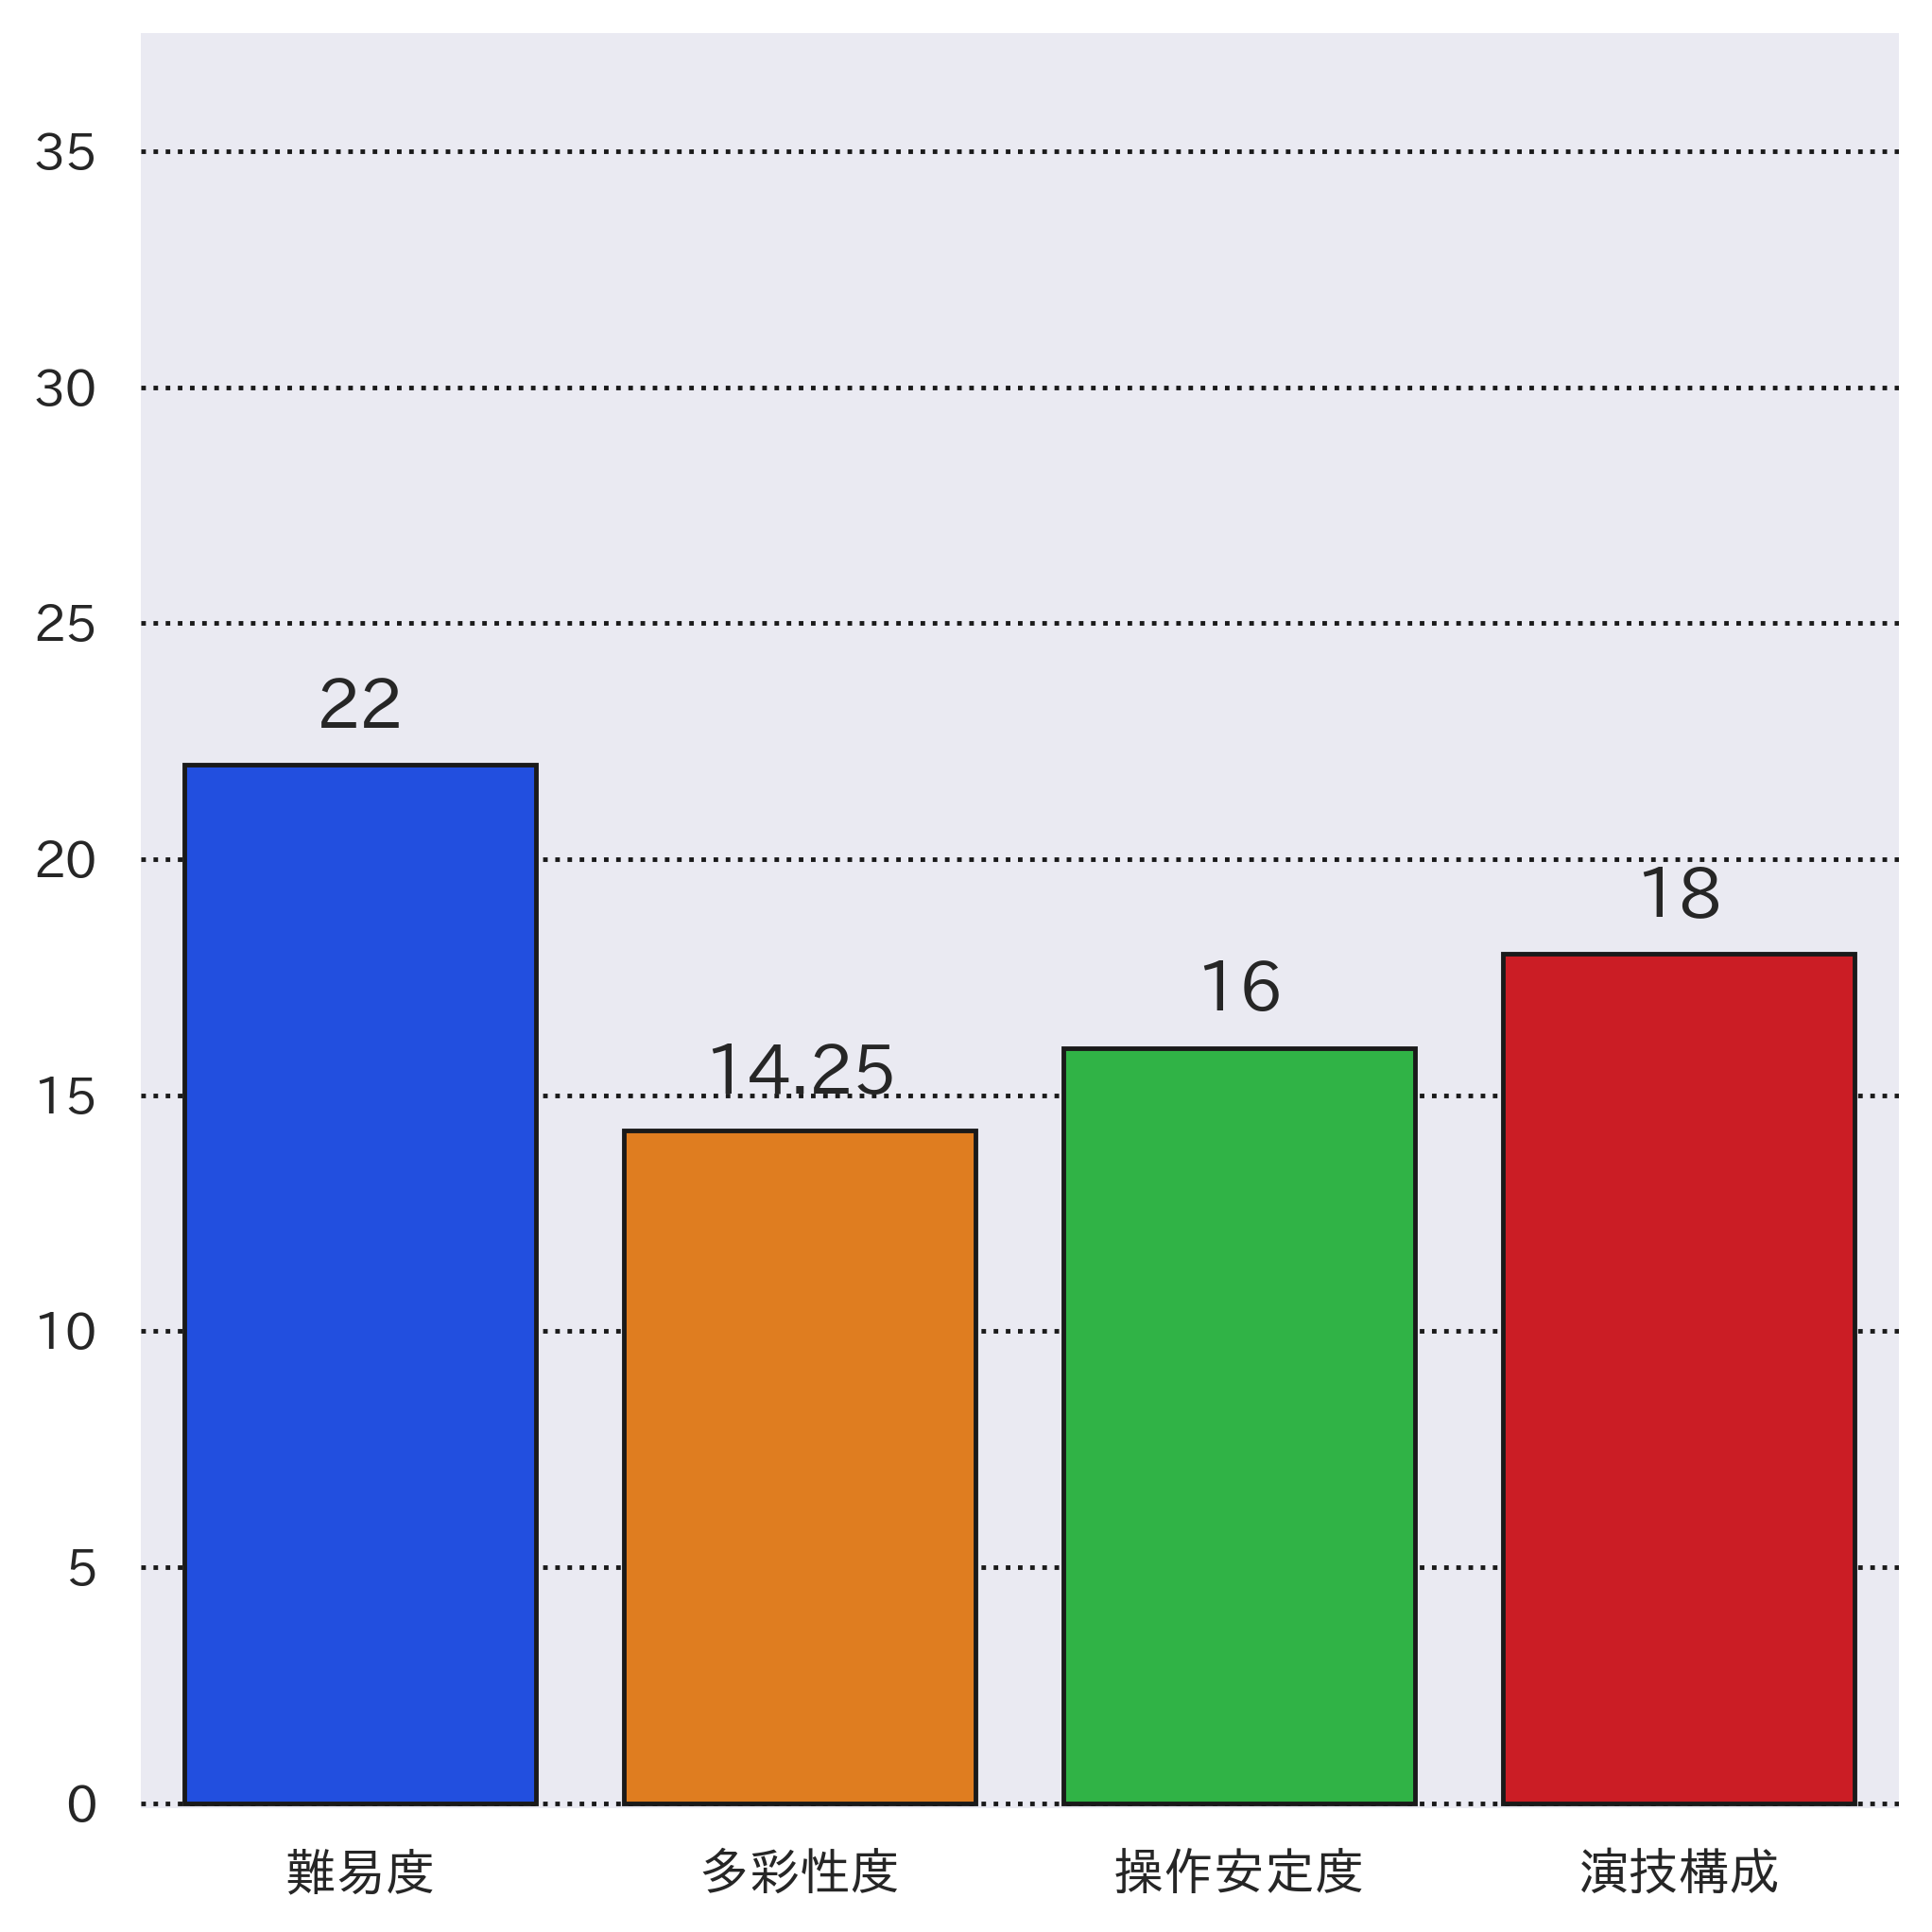

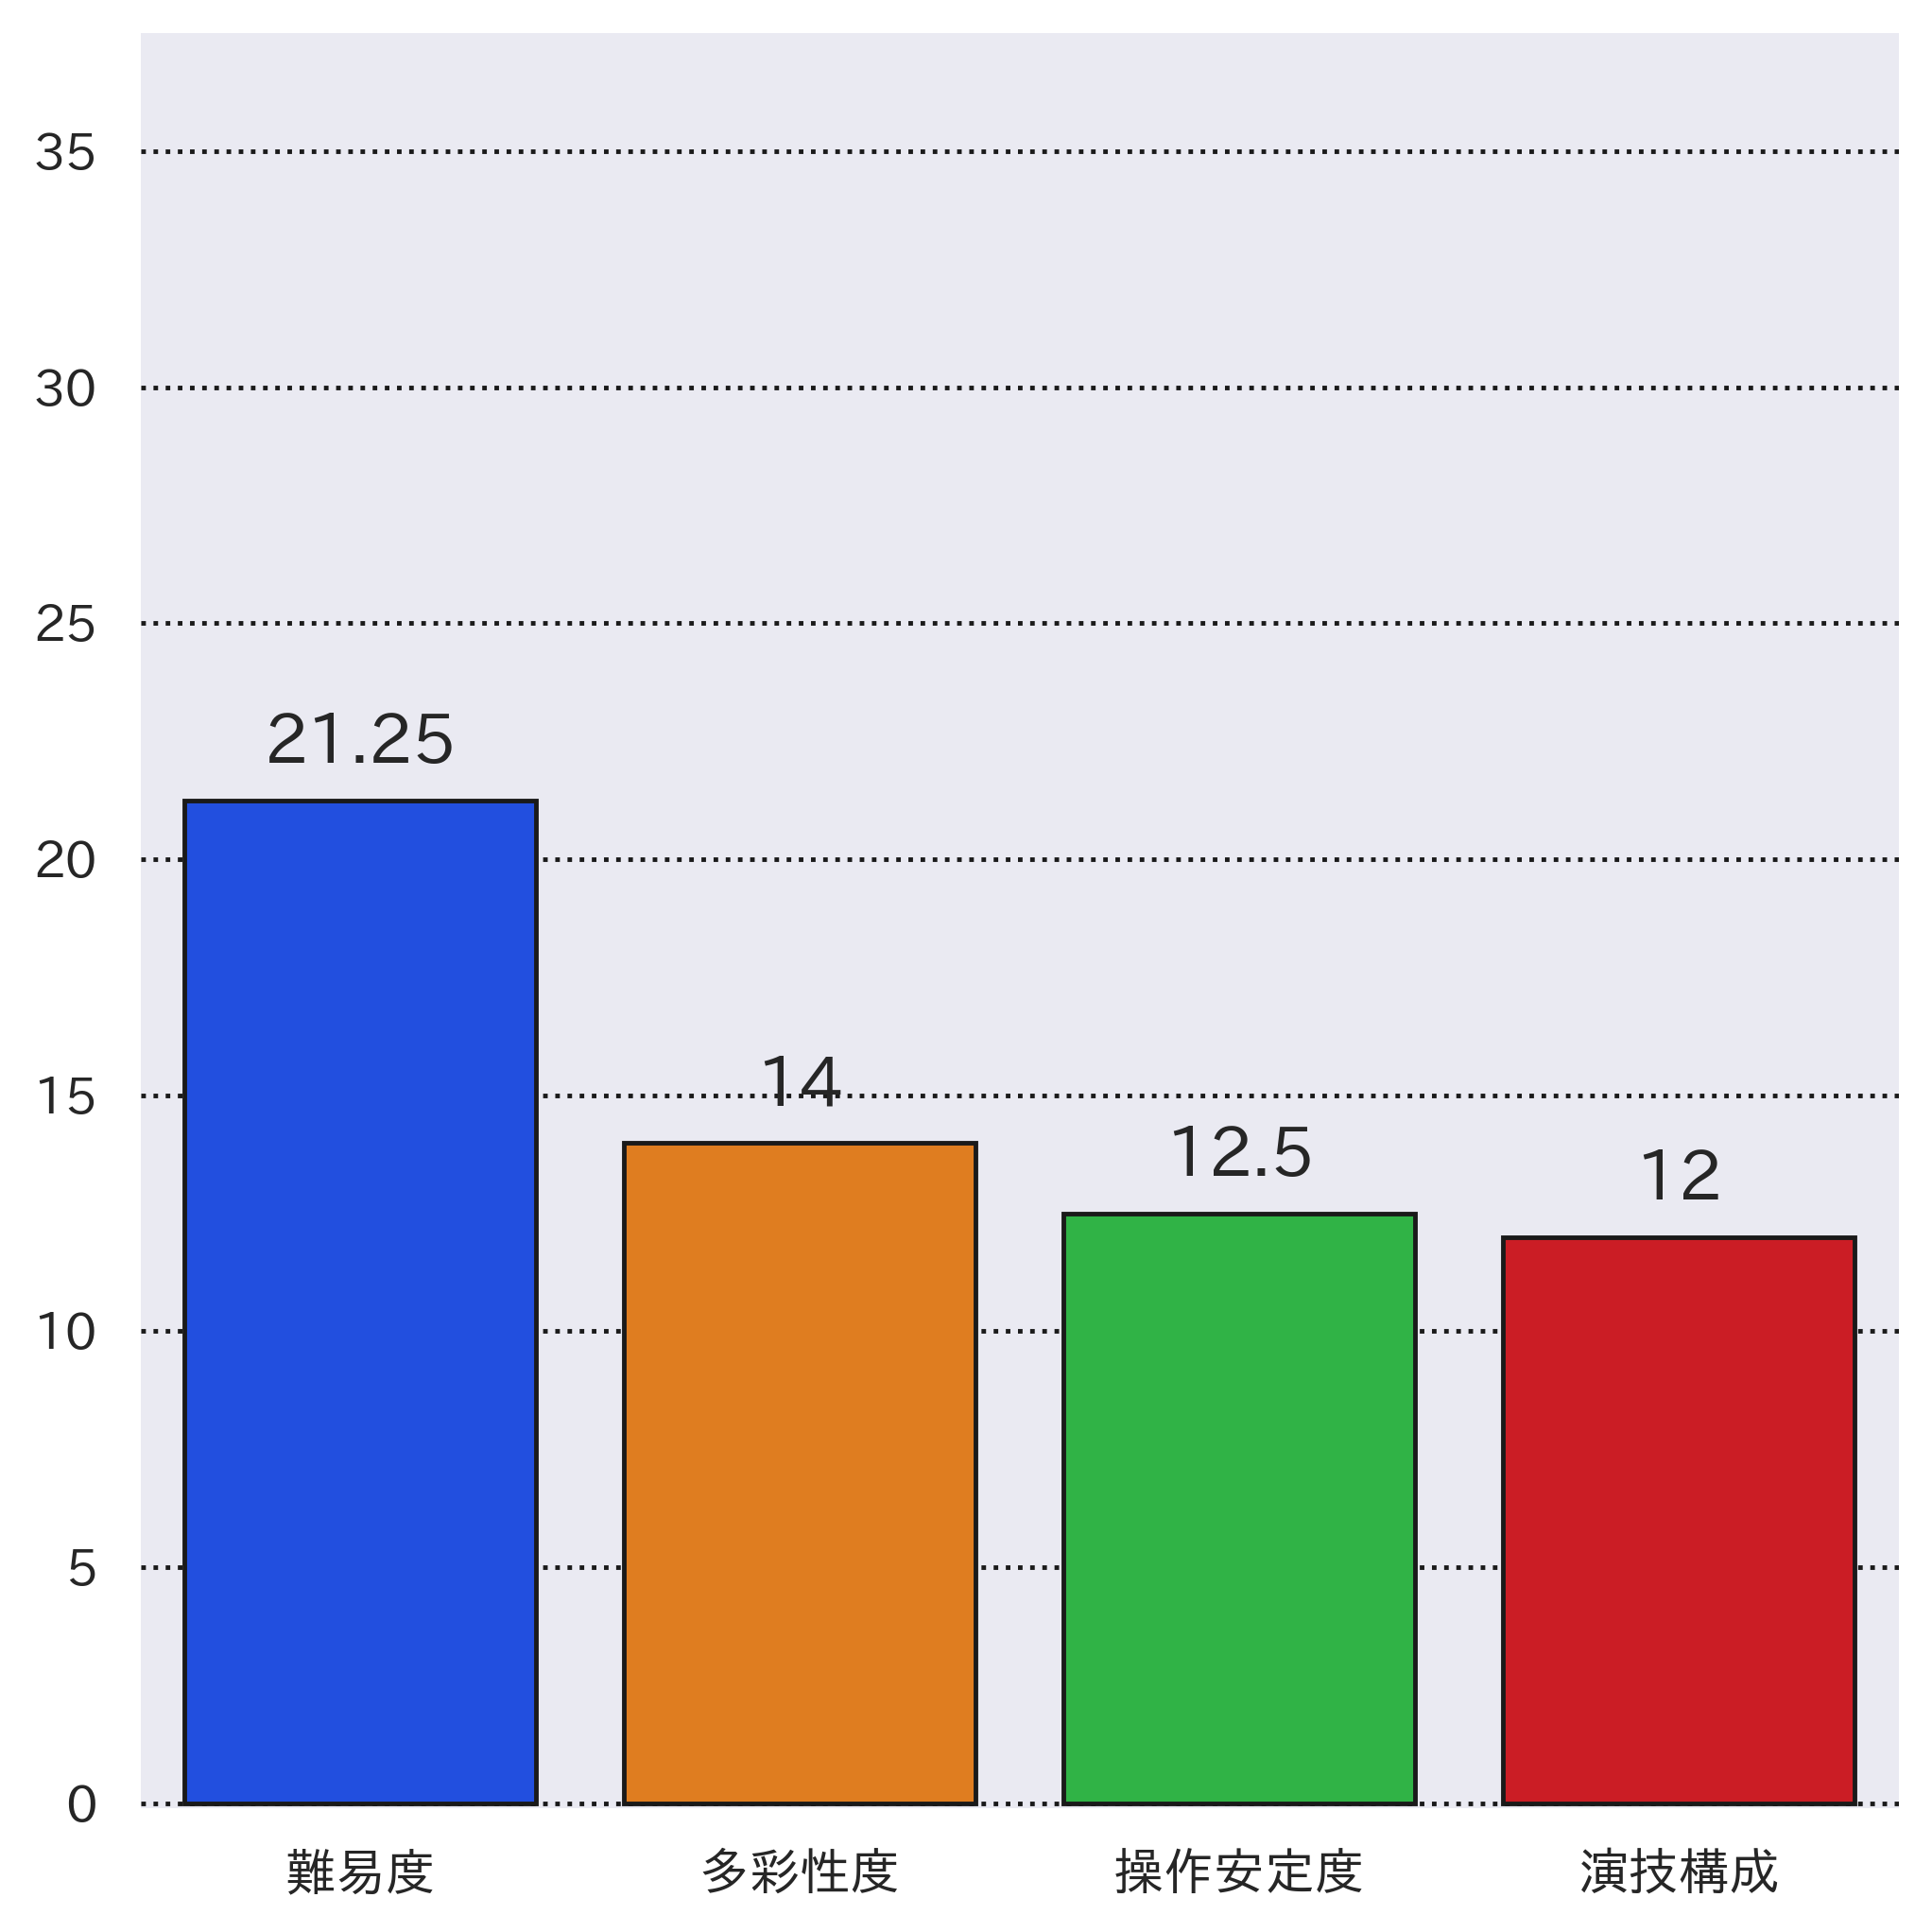

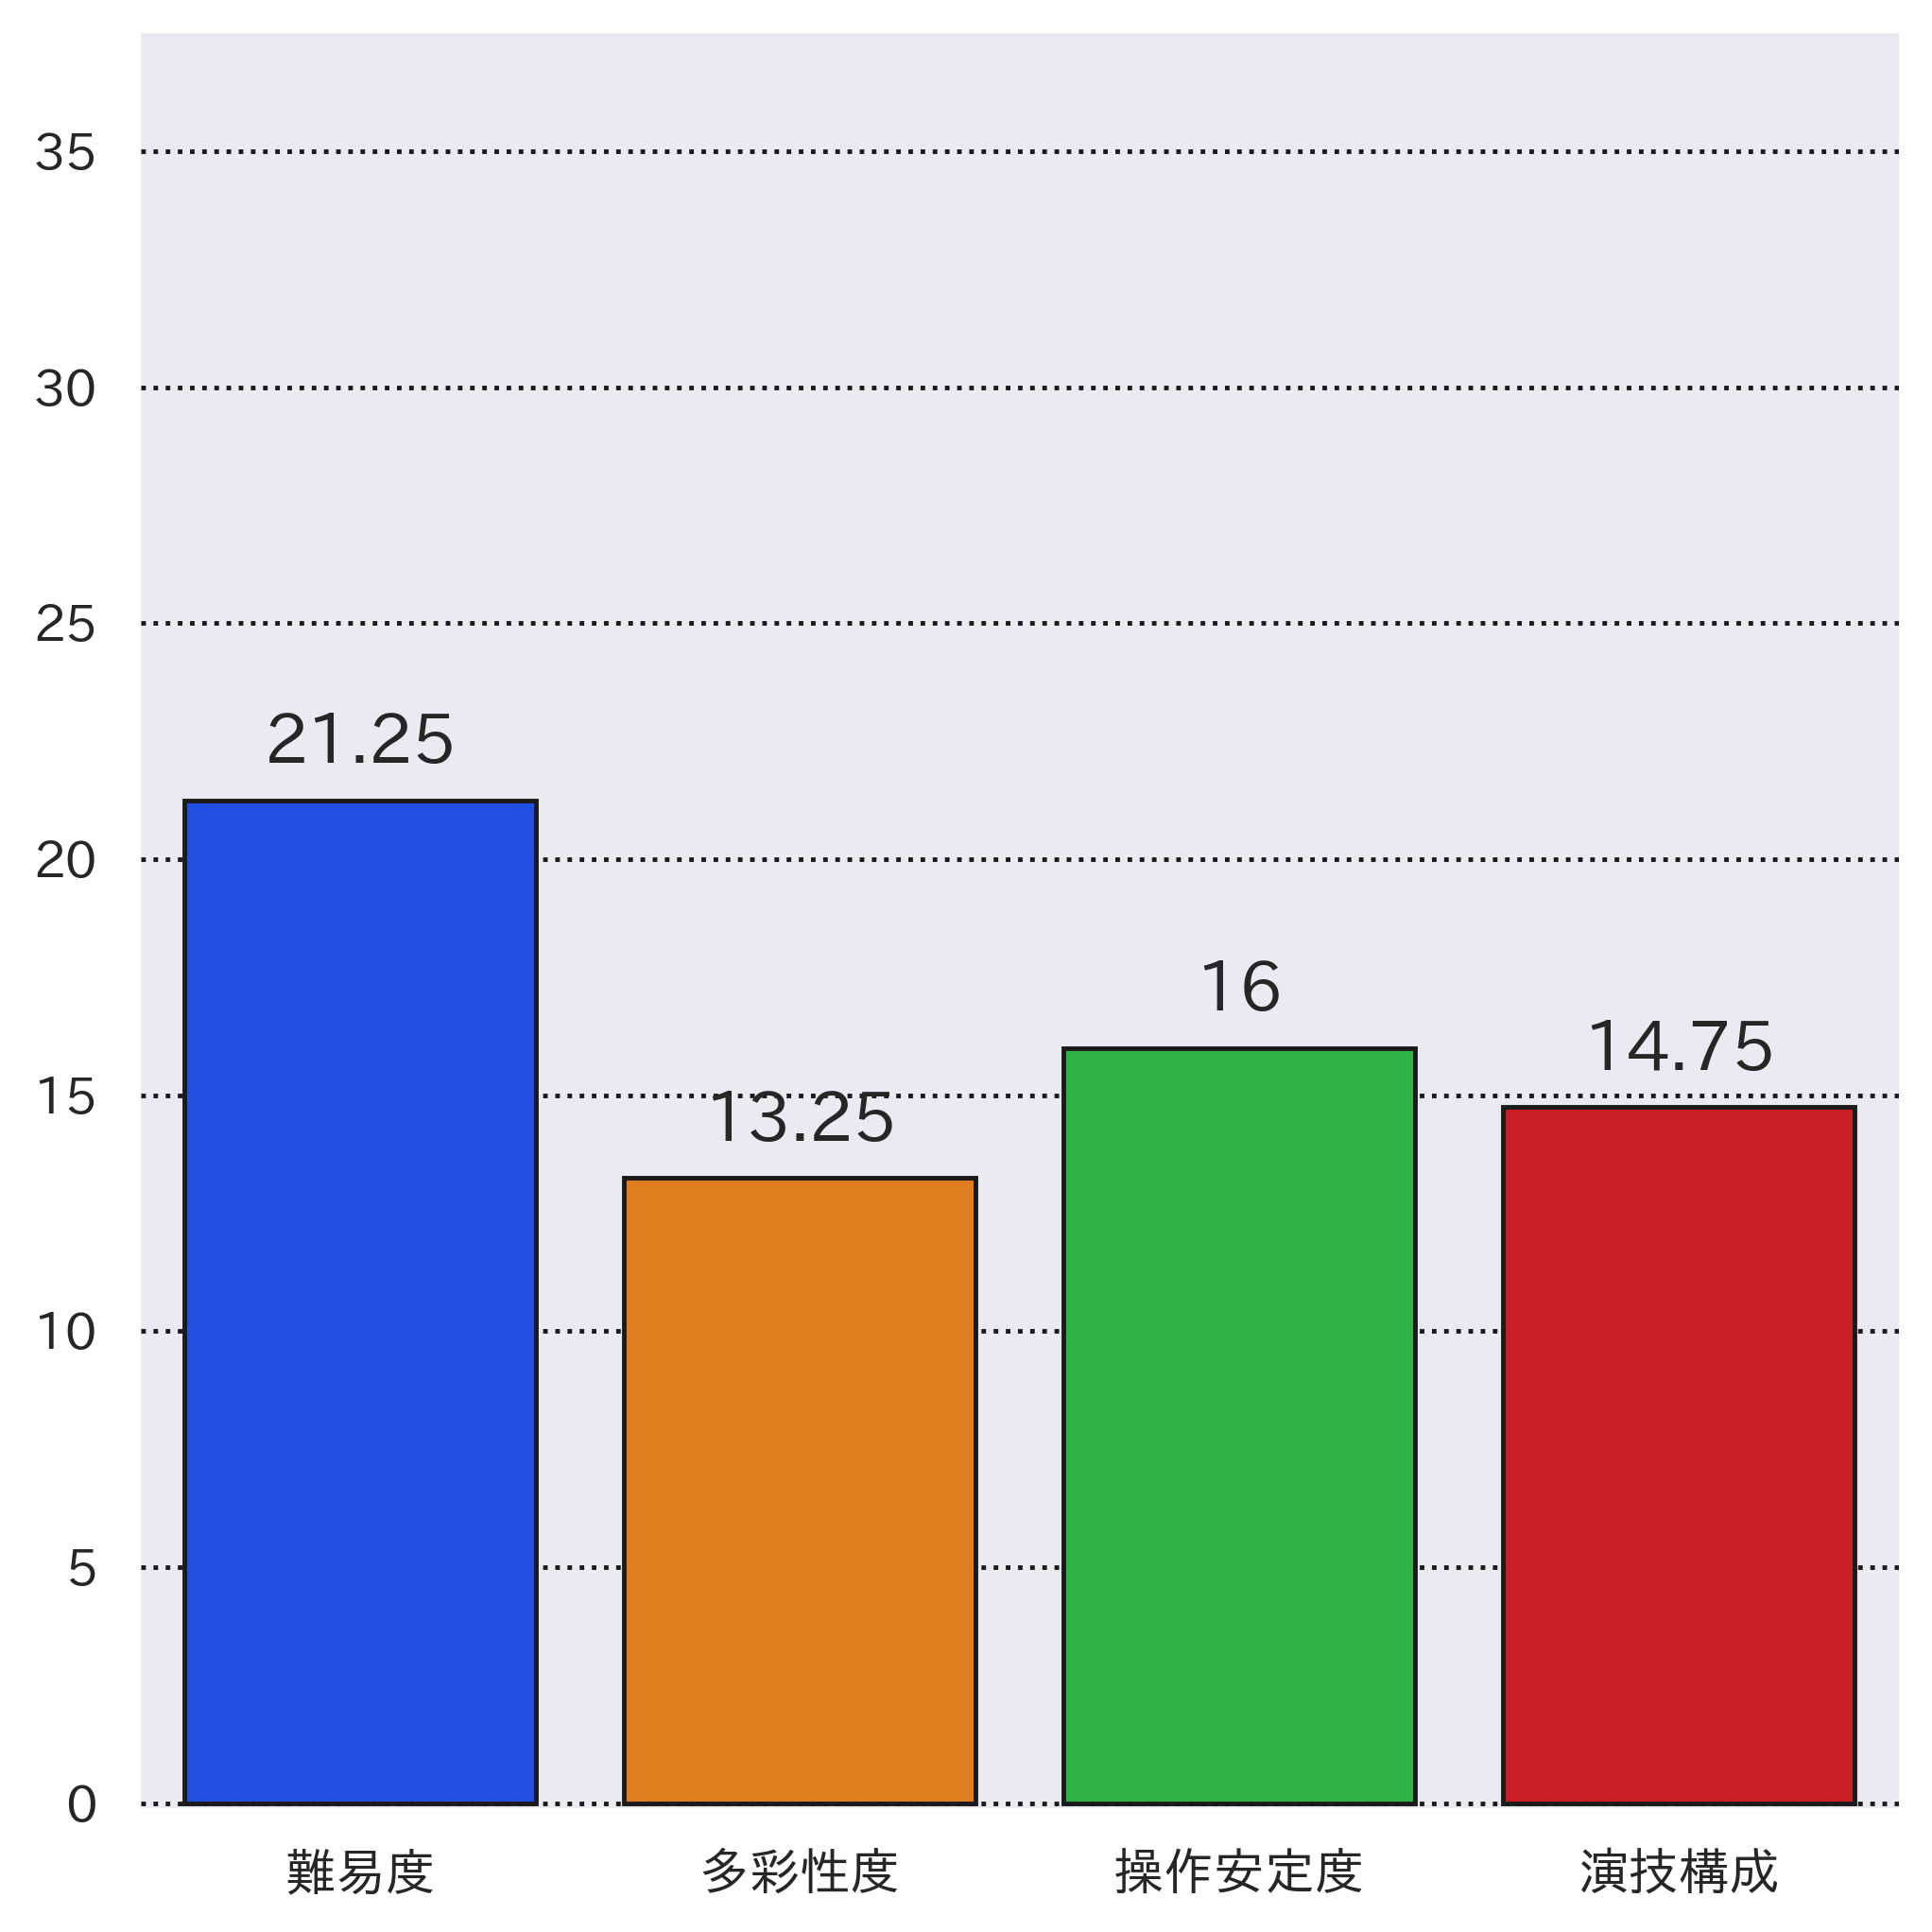

In [45]:
save_hist_chart(result_diabolo)
save_hist_chart(result_toss)

## レーダーチャート
もしかしたらいいかもしれないので、書いてみる

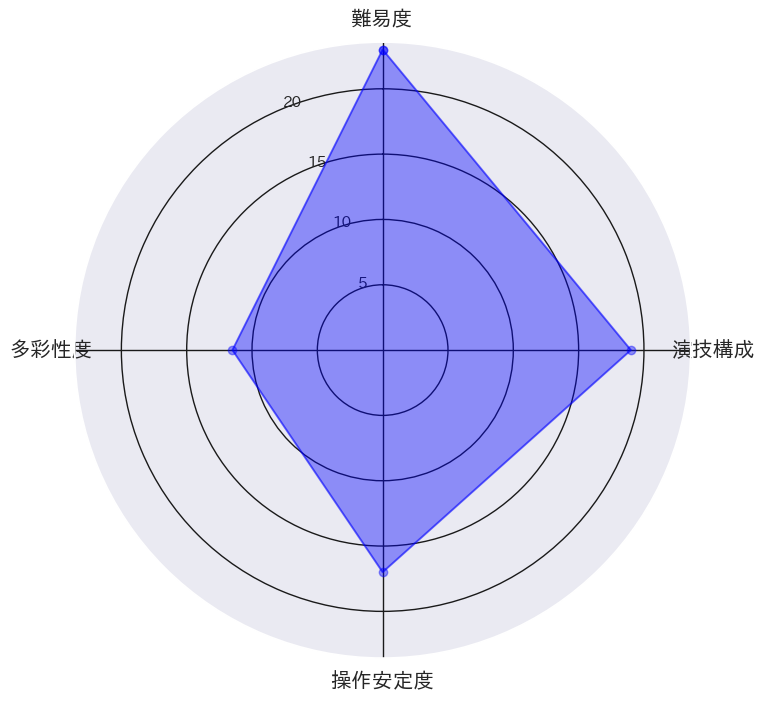

In [7]:
bar_plot_data = result_diabolo.query(f"選手名 == 'トムコム'")[columns].astype(float)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

# ラベル付
angles = np.array([0, 90, 180, 270, 0])
values = bar_plot_data.values.ravel()
values = np.concatenate([values, values[:1]])

ax.fill(
    angles * 2 * np.pi / 360,
    values,
    "o-",
    color="blue",
    alpha=0.4,
)
ax.plot(
    angles * 2 * np.pi / 360,
    values,
    "o-",
    color="blue",
    alpha=0.4,
)

ax.set_thetagrids(angles[:-1], columns, fontsize=15)
ax.set_theta_zero_location("N")


# gridlines = ax.yaxis.get_gridlines()
# gridlines[2].set_color("black")
# gridlines[2].set_linewidth(2)
# gridlines[2].set_linestyle("--")
